In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

<ipython-input-1-6262edb7c1a3>:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataTransformation import LowPassFilter
from scipy.signal import argrelextrema
from sklearn.metrics import mean_absolute_error

pd.options.mode.chained_assignment = None

In [2]:
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100
plt.rcParams["lines.linewidth"] = 2

In [3]:
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")
df = df[df["label"] != "rest"]

In [4]:
acc_r = df["acc_x"] ** 2 + df["acc_y"] ** 2 + df["acc_z"] ** 2
gyr_r = df["gyr_x"] ** 2 + df["gyr_y"] ** 2 + df["gyr_z"] ** 2

df["acc_r"] = np.sqrt(acc_r)
df["gyr_r"] = np.sqrt(gyr_r)

In [5]:
bench_df = df[df["label"] == "bench"]
squat_df = df[df["label"] == "squat"]
row_df = df[df["label"] == "row"]
ohp_df = df[df["label"] == "ohp"]
dead_df = df[df["label"] == "dead"]

<AxesSubplot: xlabel='epoch (ms)'>

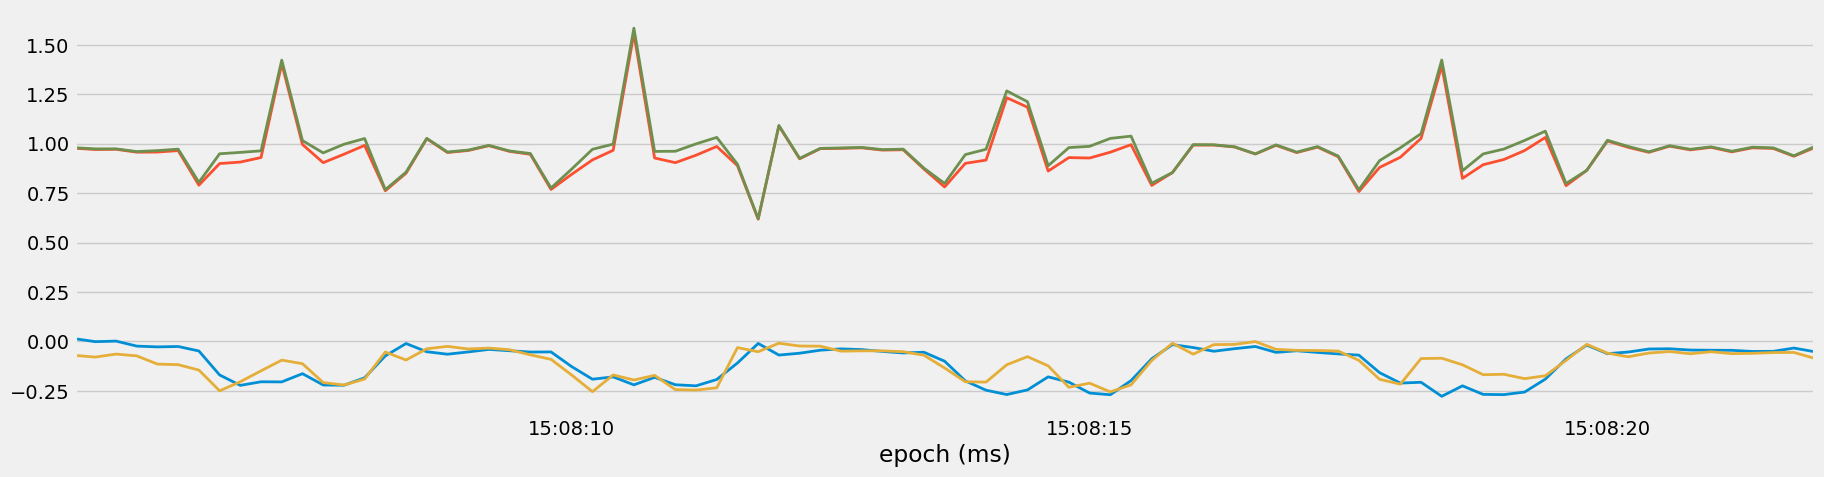

In [6]:
plot_df = bench_df
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_x"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_y"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_z"].plot()
plot_df[plot_df["set"] == plot_df["set"].unique()[0]]["acc_r"].plot()

In [7]:
fs = 1000 / 200  # 5 instances per second
LowPass = LowPassFilter()

In [8]:
bench_set = bench_df[bench_df["set"] == bench_df["set"].unique()[0]]
squat_set = squat_df[squat_df["set"] == squat_df["set"].unique()[0]]
row_set = row_df[row_df["set"] == row_df["set"].unique()[0]]
ohp_set = ohp_df[ohp_df["set"] == ohp_df["set"].unique()[0]]
dead_set = dead_df[dead_df["set"] == dead_df["set"].unique()[0]]

<AxesSubplot: xlabel='epoch (ms)'>

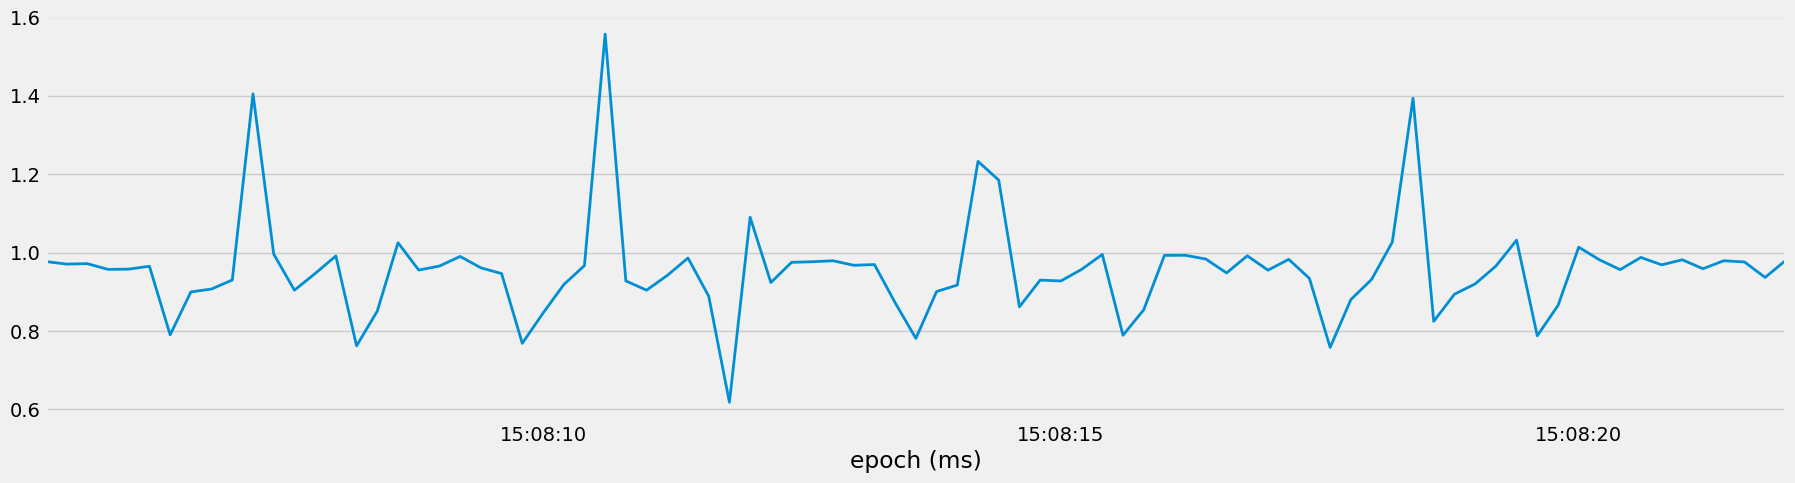

In [9]:
bench_set["acc_y"].plot()

<AxesSubplot: xlabel='epoch (ms)'>

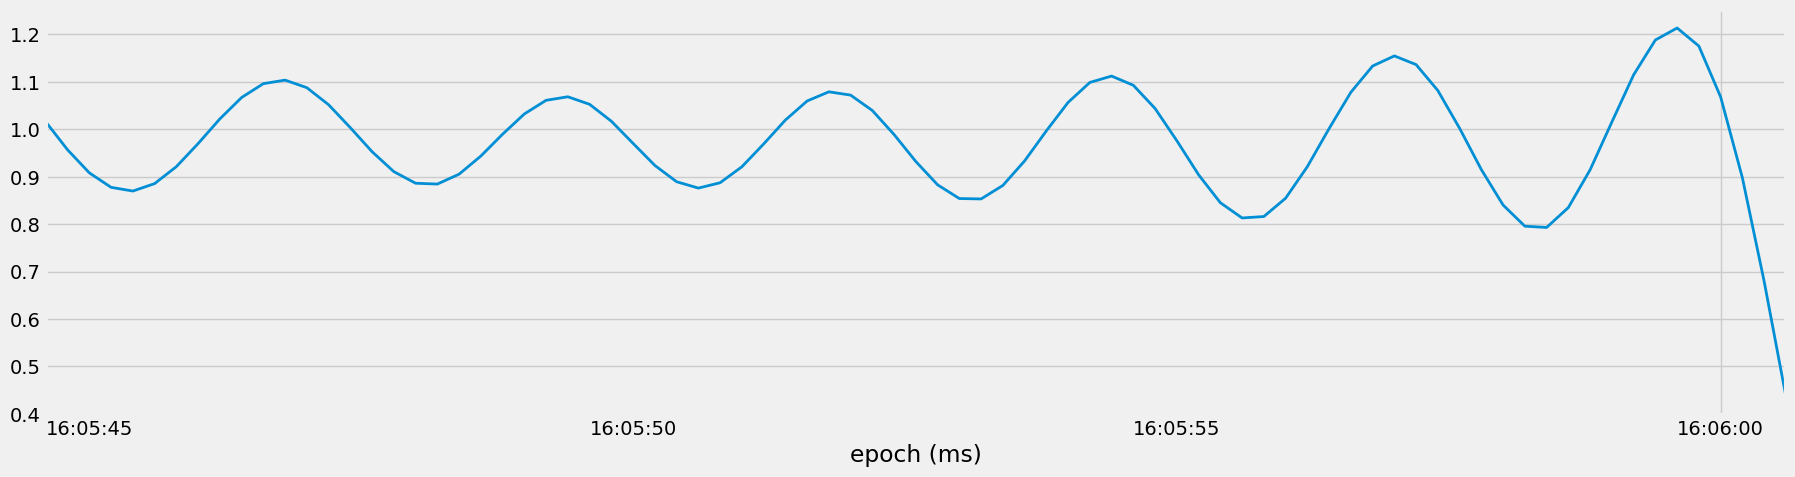

In [11]:
column = "acc_r"
LowPass.low_pass_filter(
    squat_set, col=column, sampling_frequency=fs, cutoff_frequency=0.4, order=10
)[column + "_lowpass"].plot()

In [12]:
def count_repetitions(dataset, cutoff=0.4, order=10, column="acc_r"):
    data = LowPass.low_pass_filter(
        dataset, col=column, sampling_frequency=fs, cutoff_frequency=cutoff, order=order
    )
    indices = argrelextrema(data[column + "_lowpass"].values, np.greater)
    peaks = data.iloc[indices]

    fig, ax = plt.subplots()
    plt.plot(dataset[f"{column}_lowpass"])
    plt.plot(peaks[f"{column}_lowpass"], "o", color="red")
    ax.set_ylabel(f"{column}_lowpass")
    exercise = dataset["label"].iloc[0].title()
    category = dataset["category"].iloc[0].title()
    plt.title(f"{category} {exercise}:{len(peaks)} Reps")
    plt.show()

    return len(peaks)

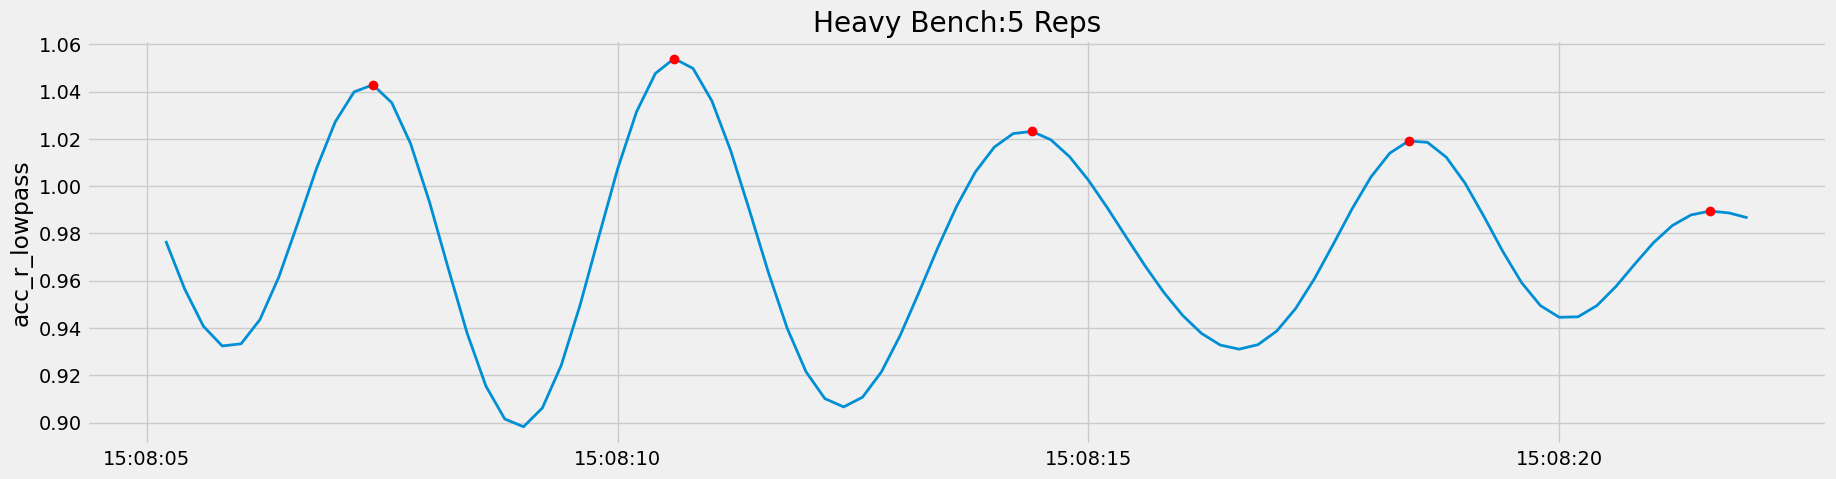

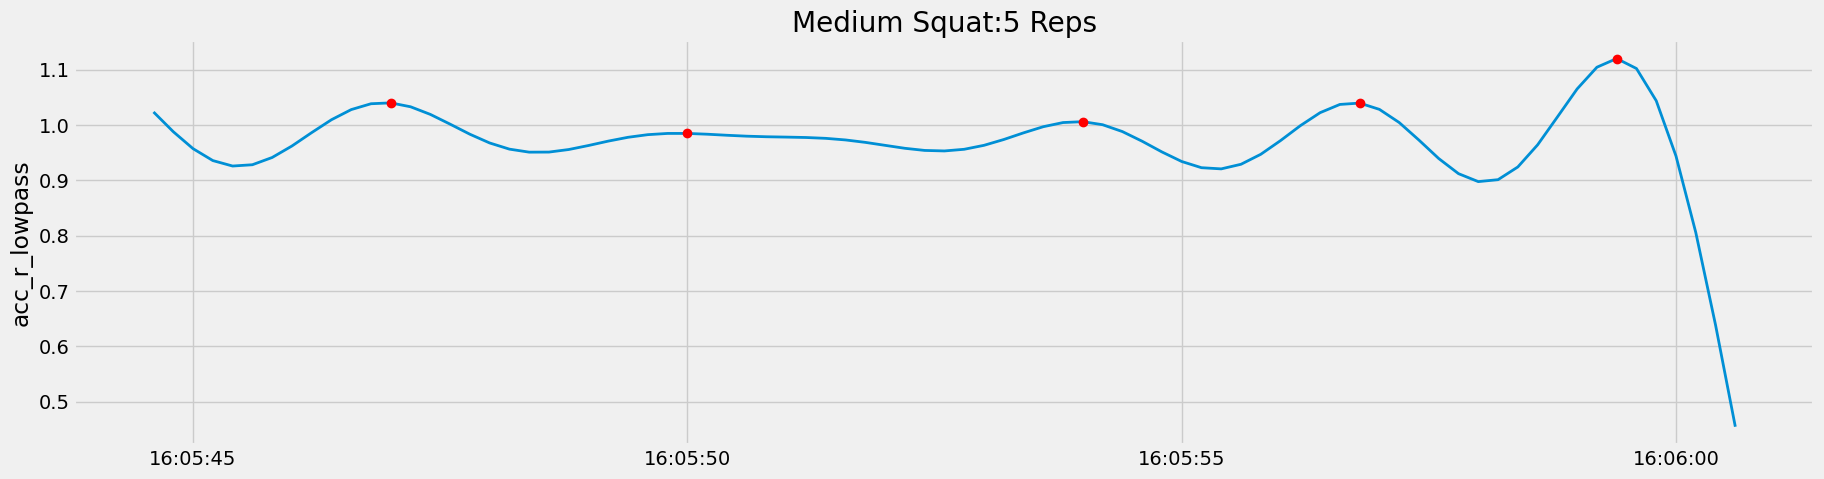

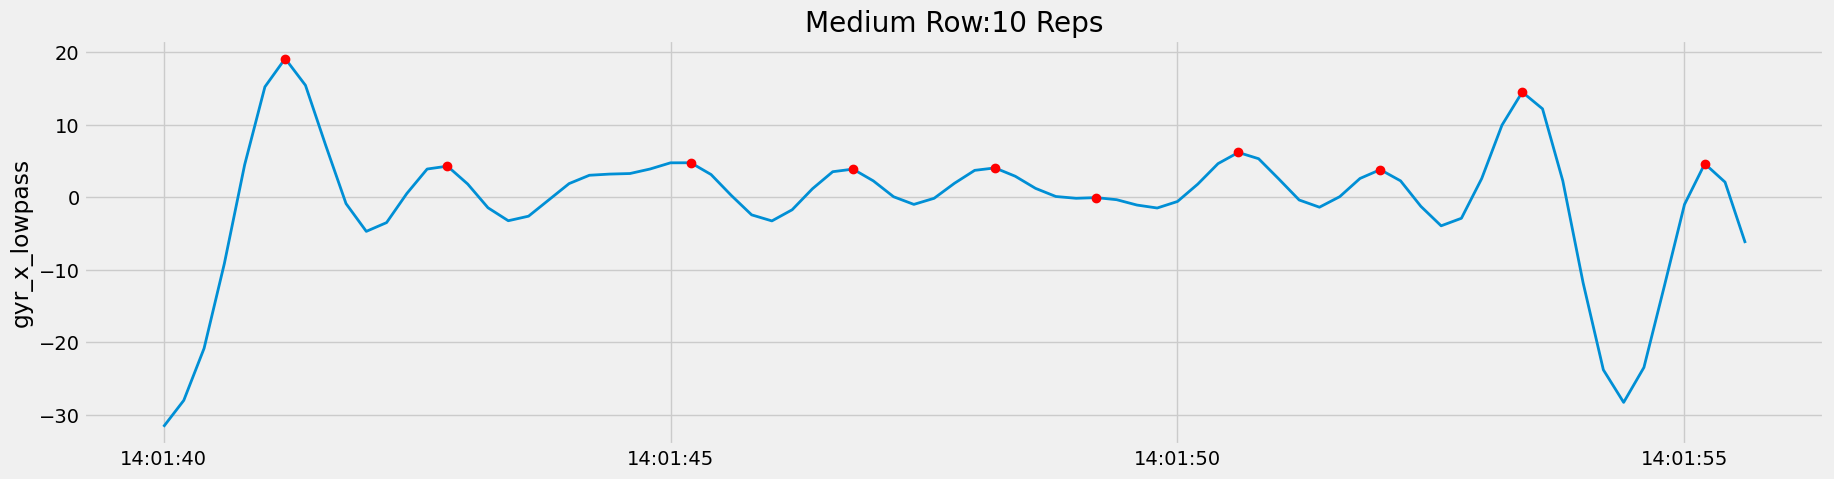

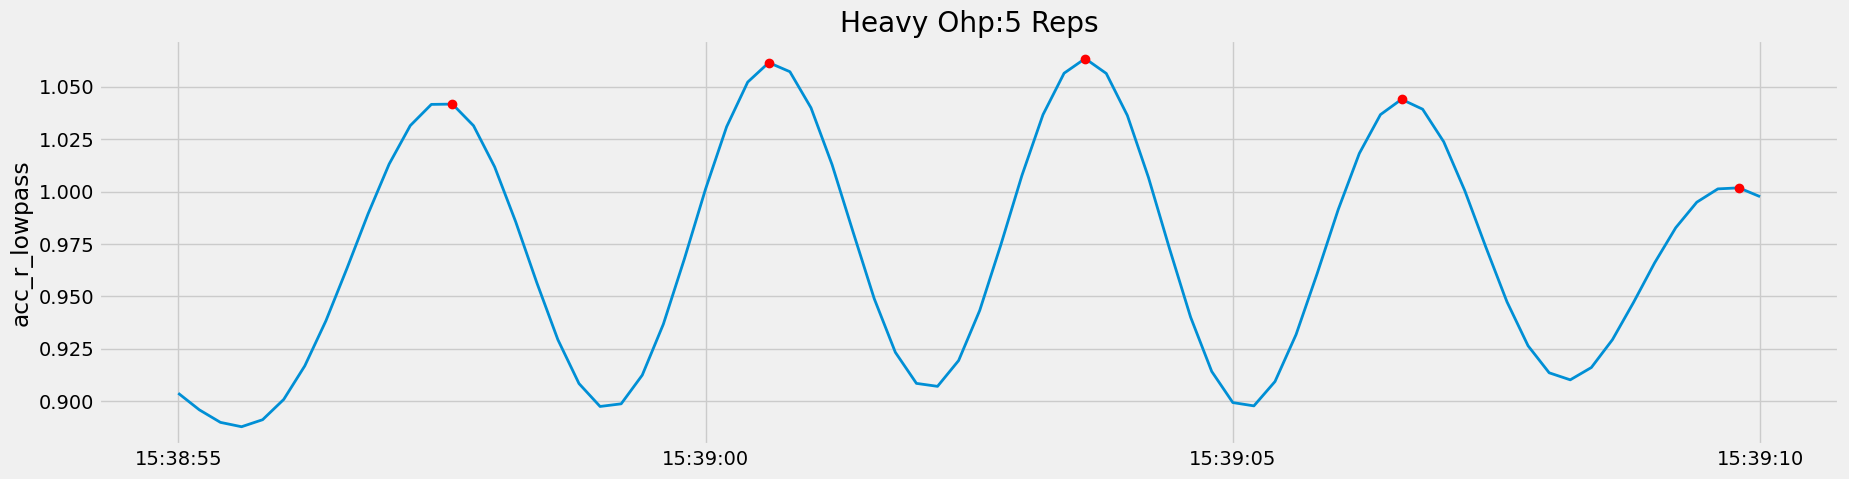

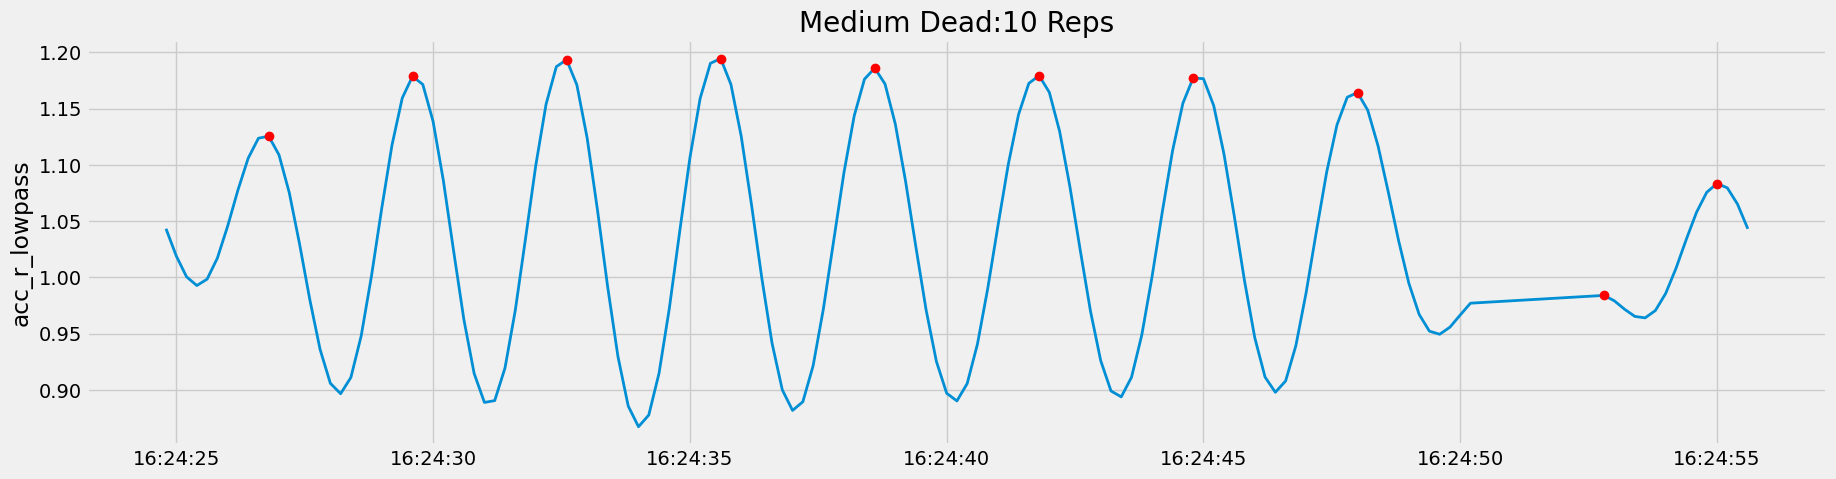

10

In [13]:
count_repetitions(bench_set, cutoff=0.4)
count_repetitions(squat_set, cutoff=0.35)
count_repetitions(row_set, cutoff=0.65, column="gyr_x")
count_repetitions(ohp_set, cutoff=0.35)
count_repetitions(dead_set, cutoff=0.4)

In [14]:
df["reps"] = df["category"].apply(lambda x: 5 if x == "heavy" else 10)
rep_df = df.groupby(["label", "category", "set"])["reps"].max().reset_index()

In [17]:
df["reps"] = df["category"].apply(lambda x: 5 if x == "heavy" else 10)

In [18]:
rep_df = df.groupby(["label", "category", "set"])["reps"].max().reset_index()

In [20]:
rep_df

label category  set  reps
0   bench    heavy    1     5
1   bench    heavy    2     5
2   bench    heavy    3     5
3   bench    heavy    4     5
4   bench    heavy   30     5
..    ...      ...  ...   ...
80  squat   medium   28    10
81  squat   medium   29    10
82  squat   medium   38    10
83  squat   medium   63    10
84  squat   medium   64    10

[85 rows x 4 columns]

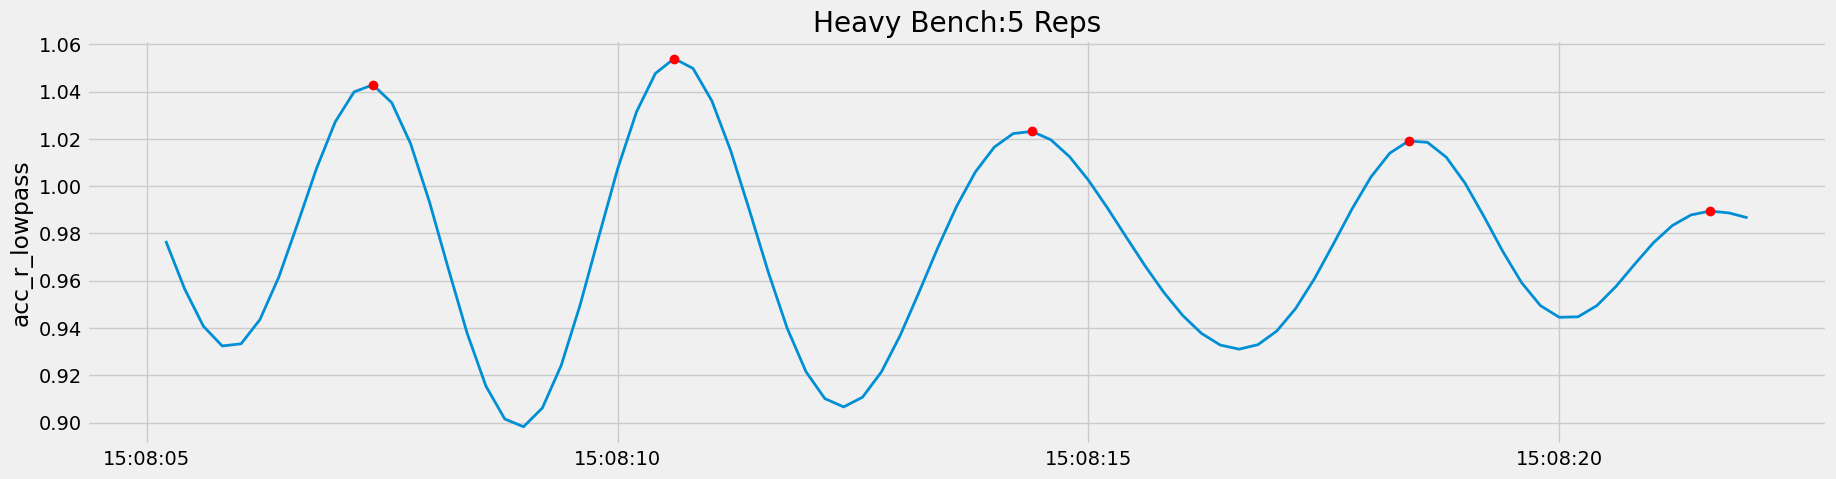

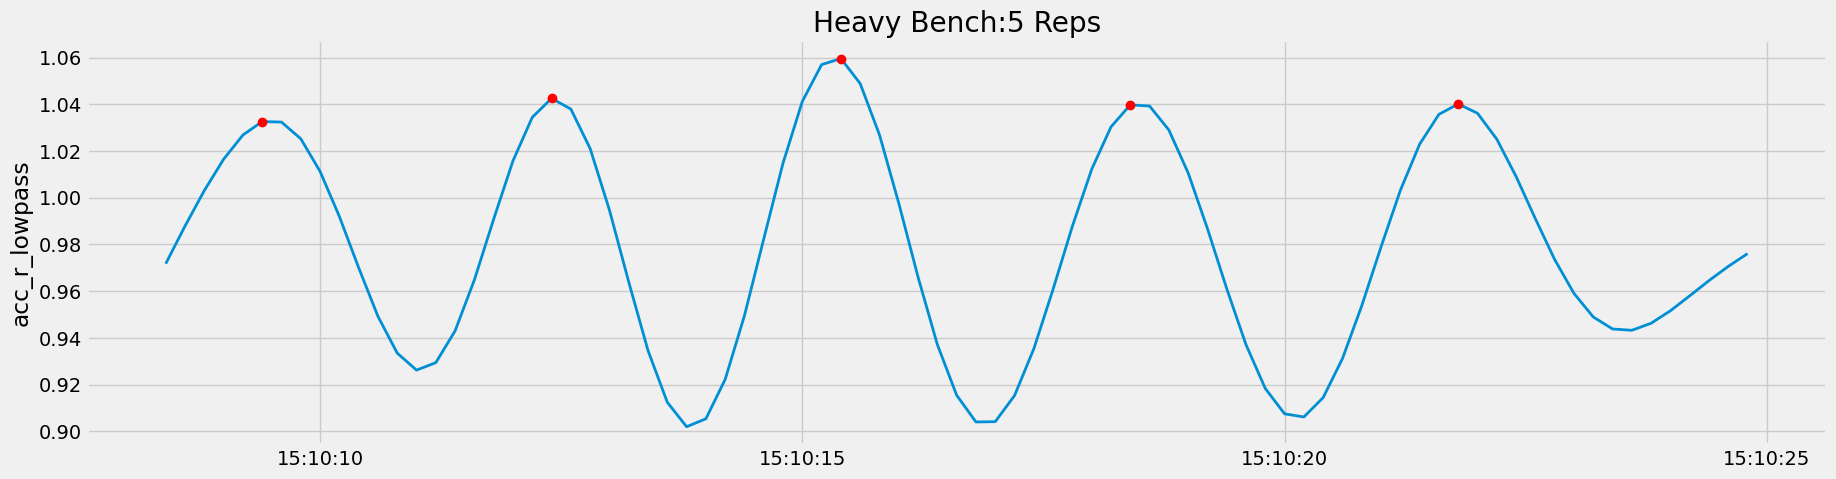

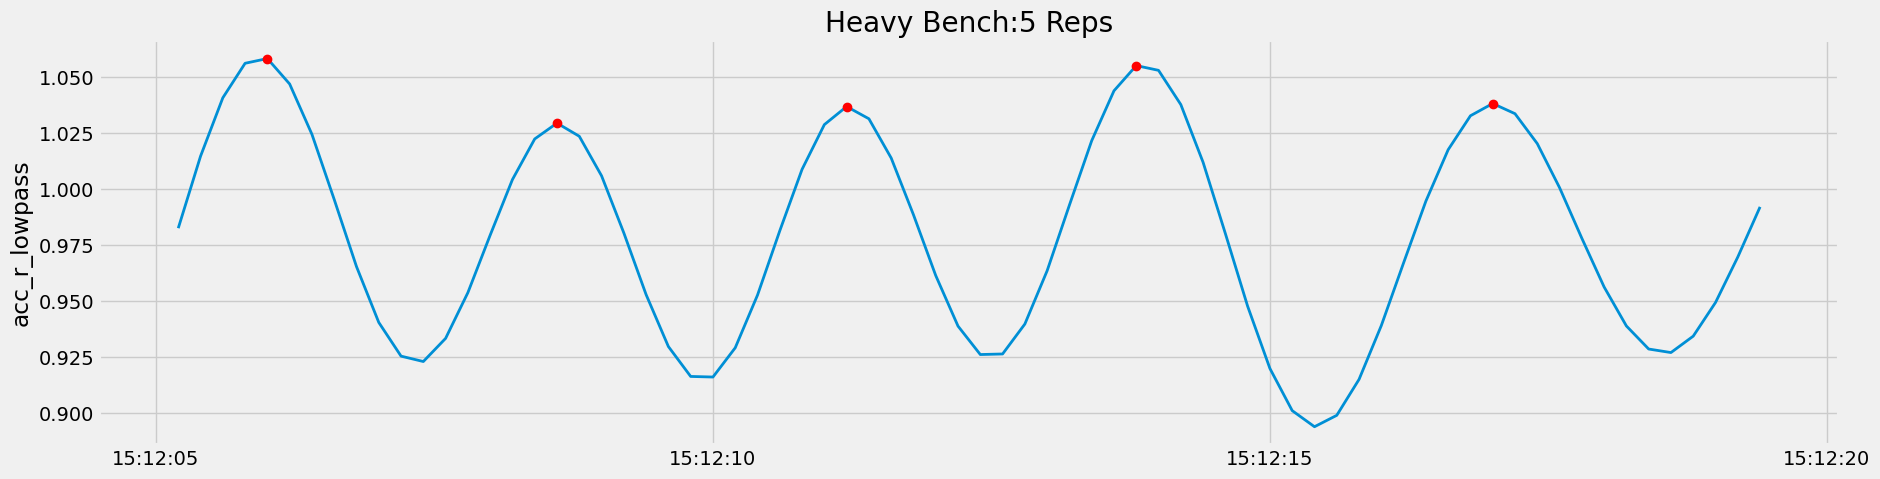

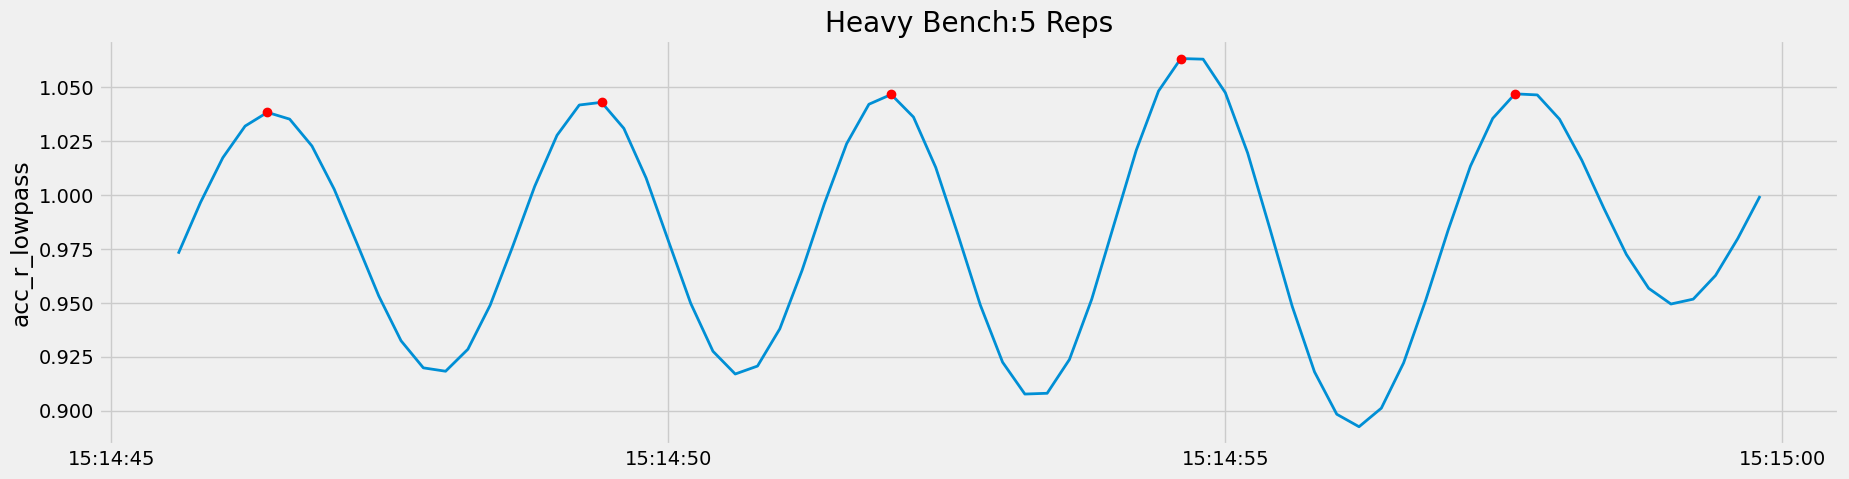

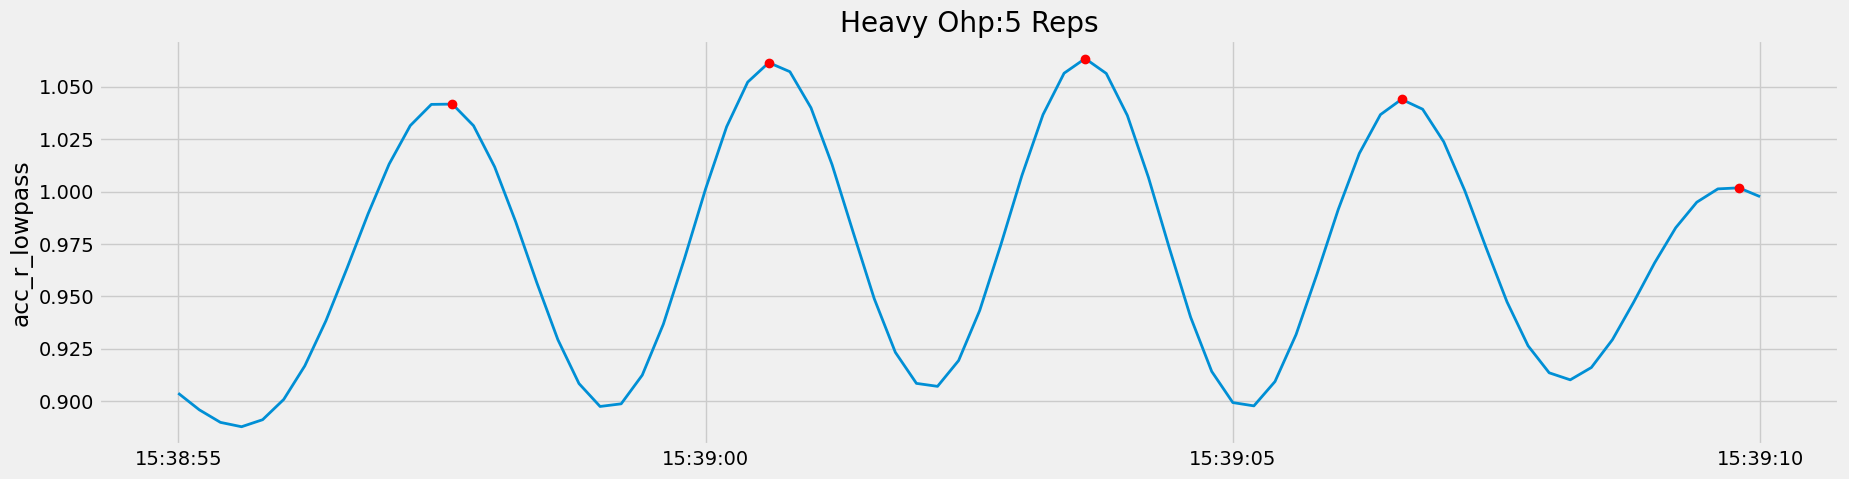

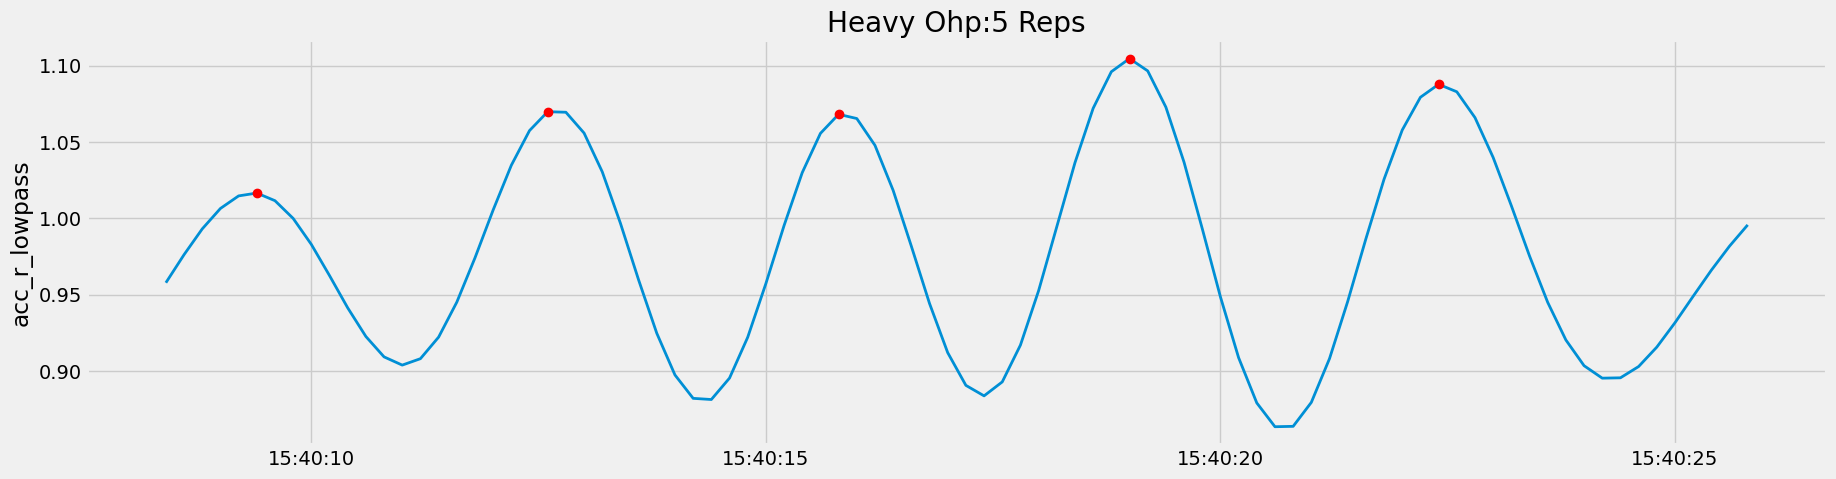

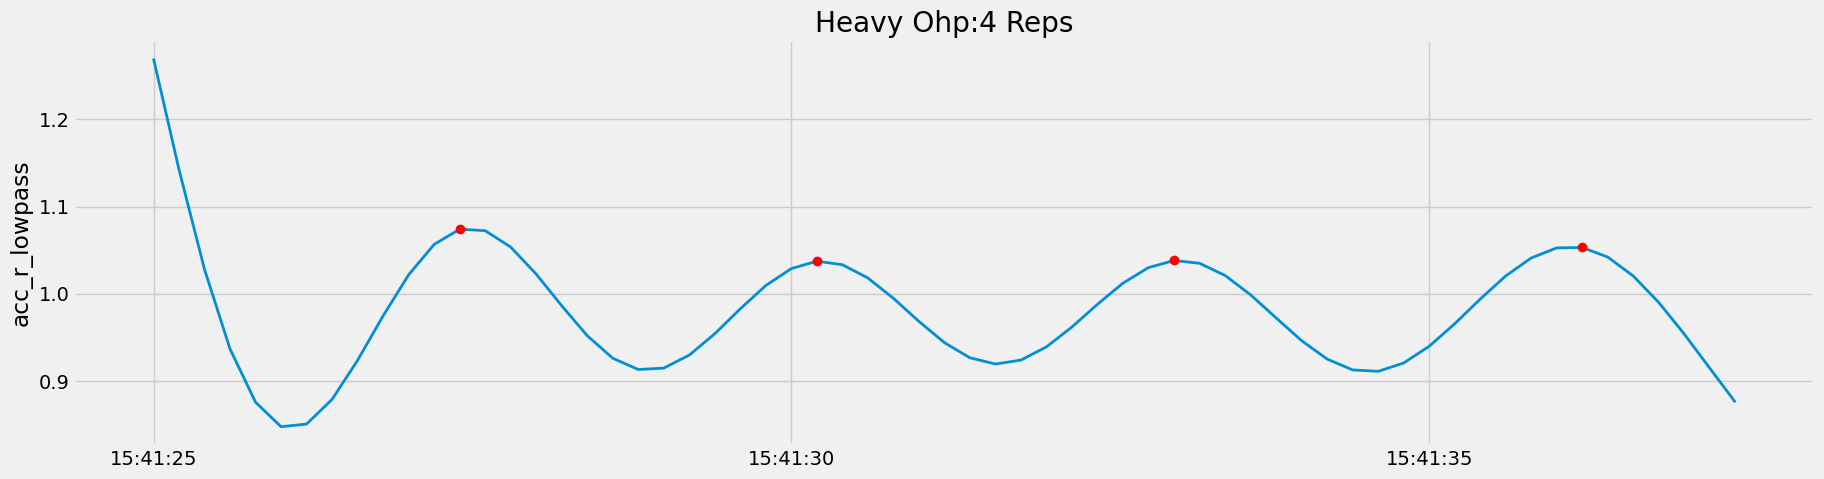

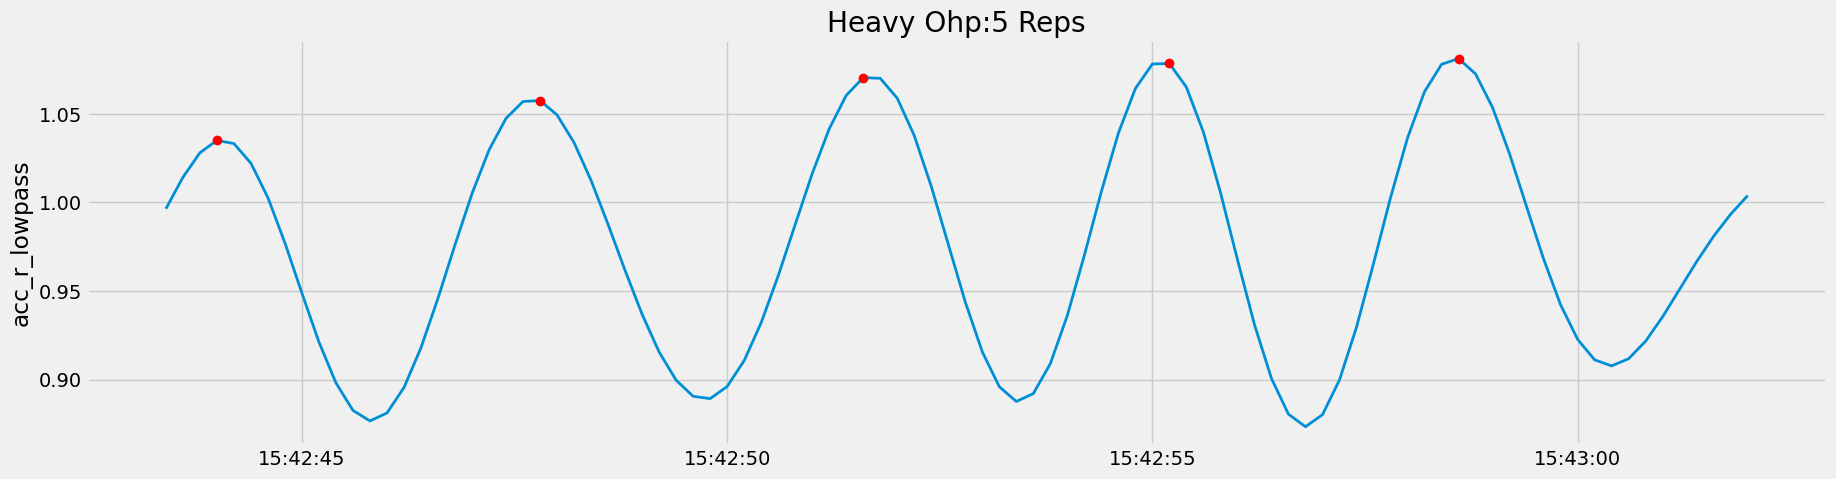

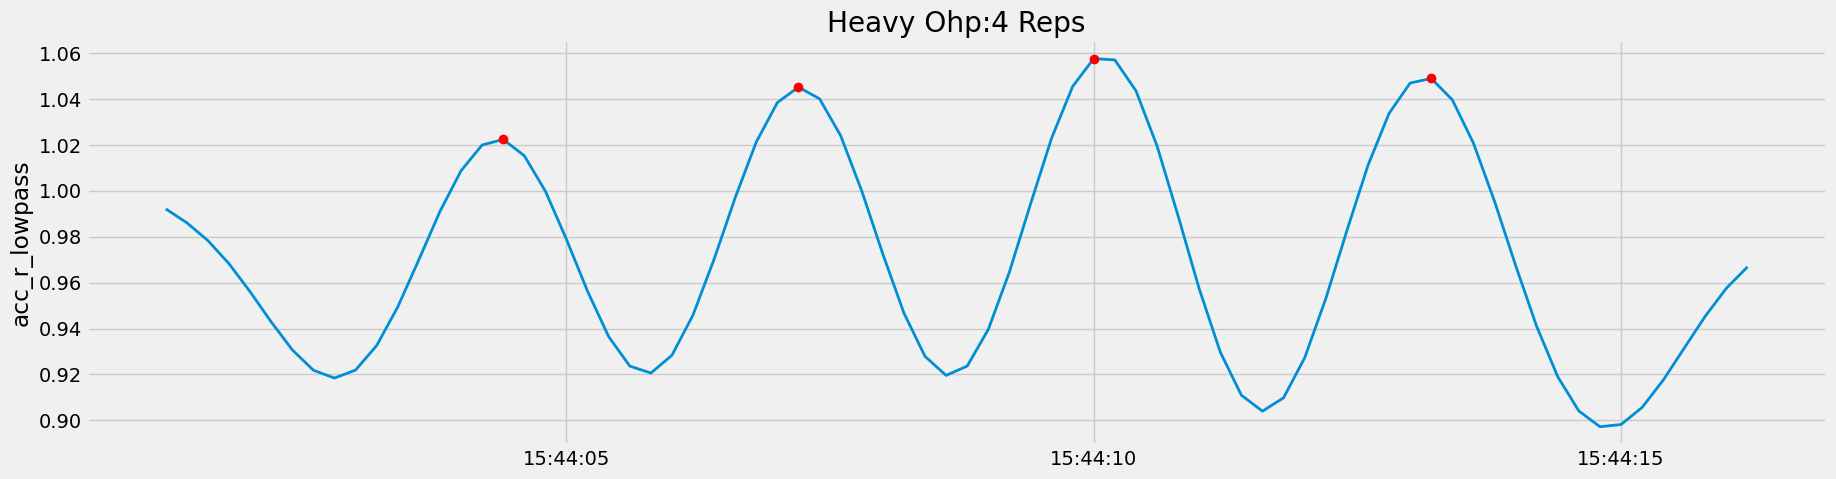

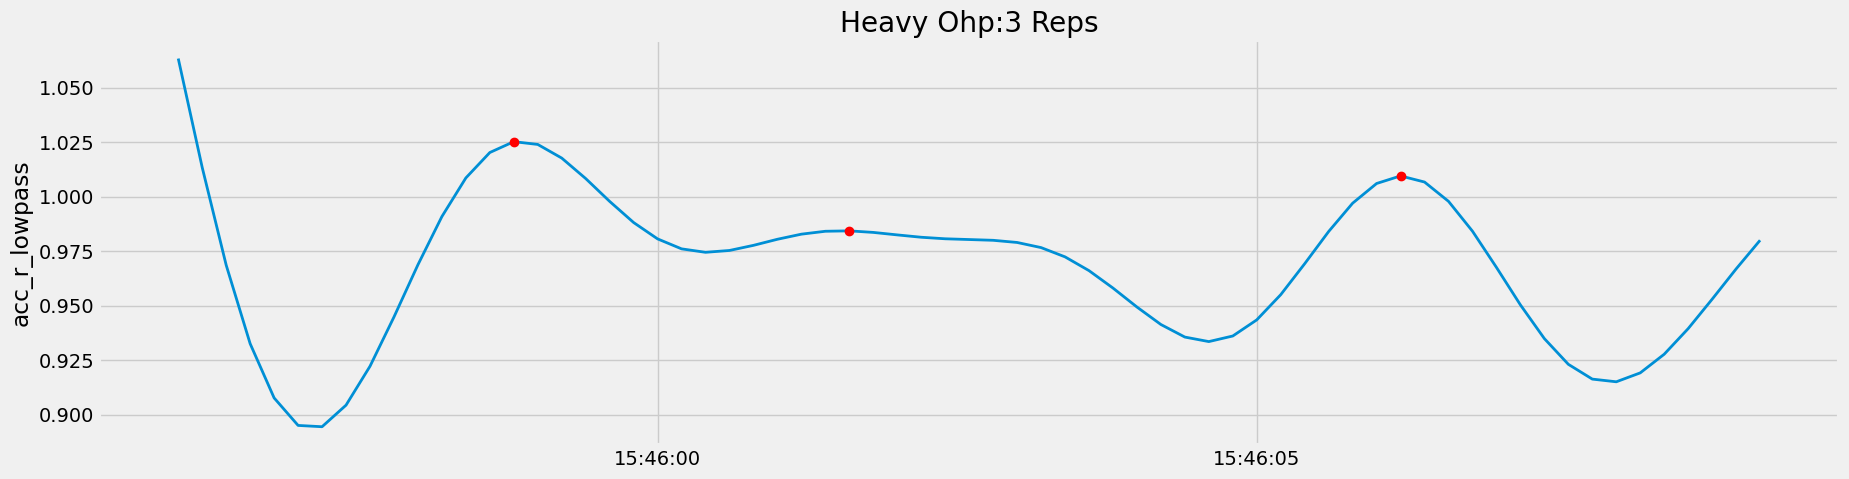

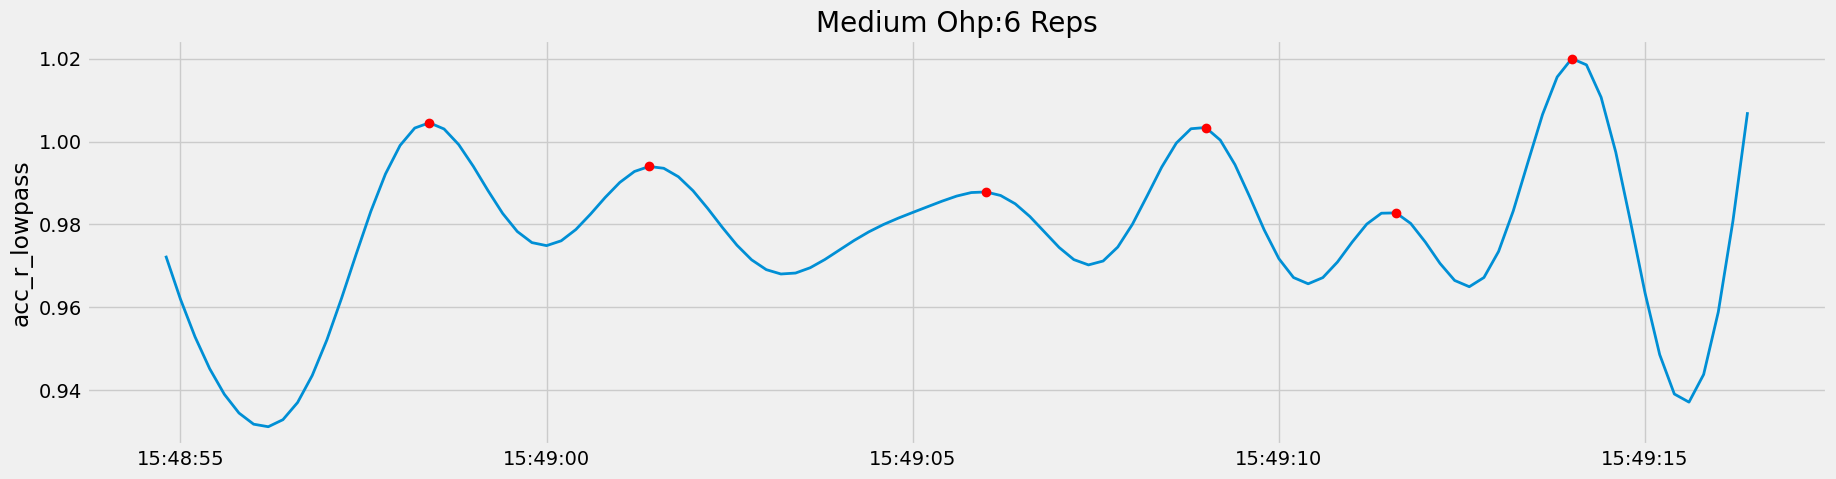

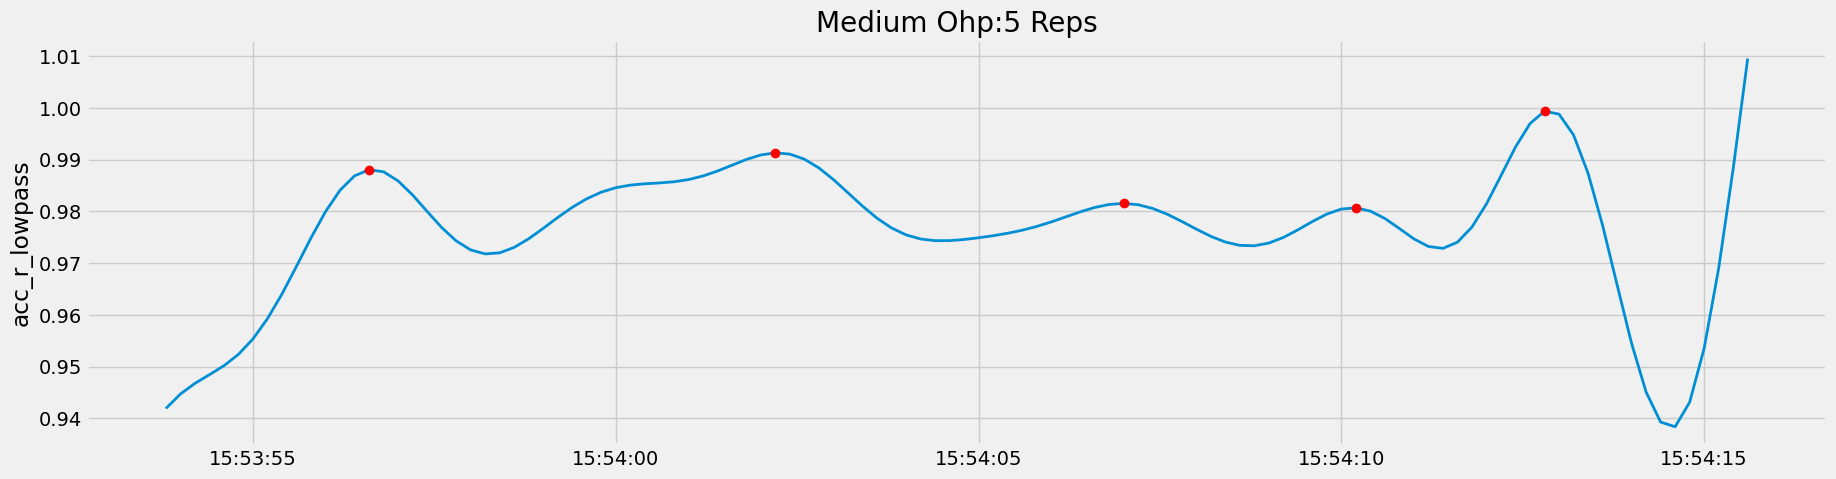

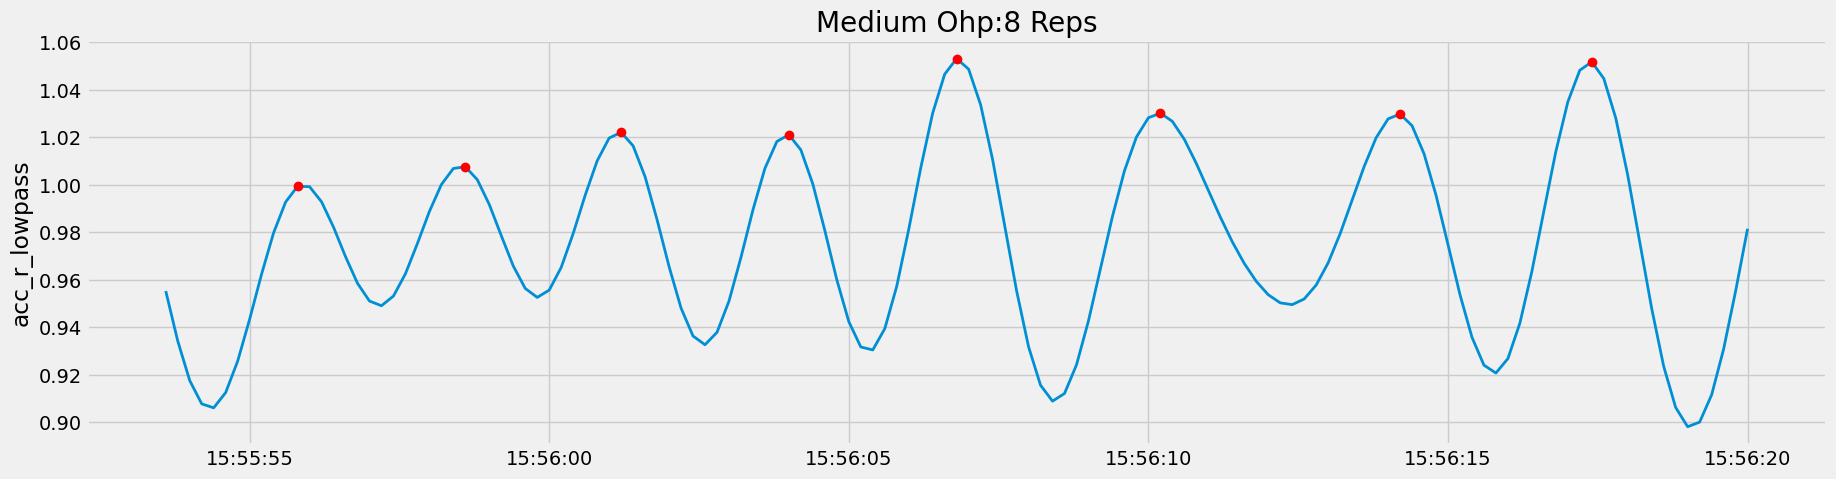

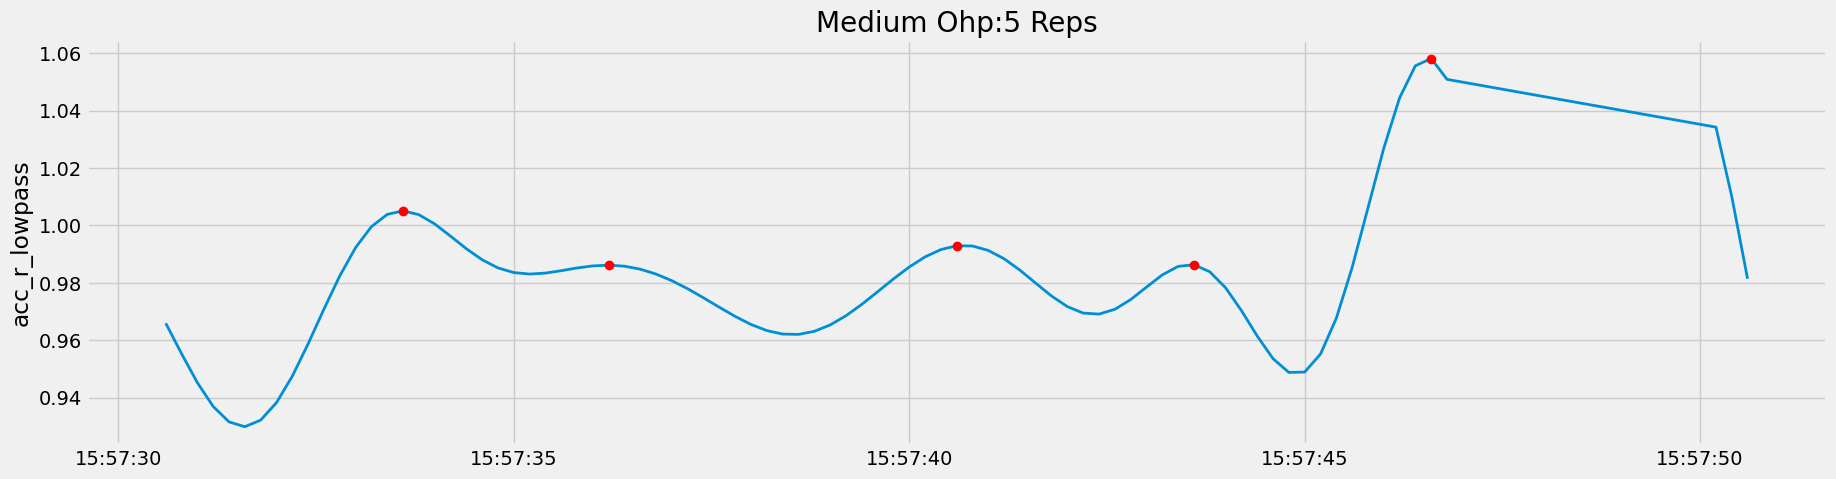

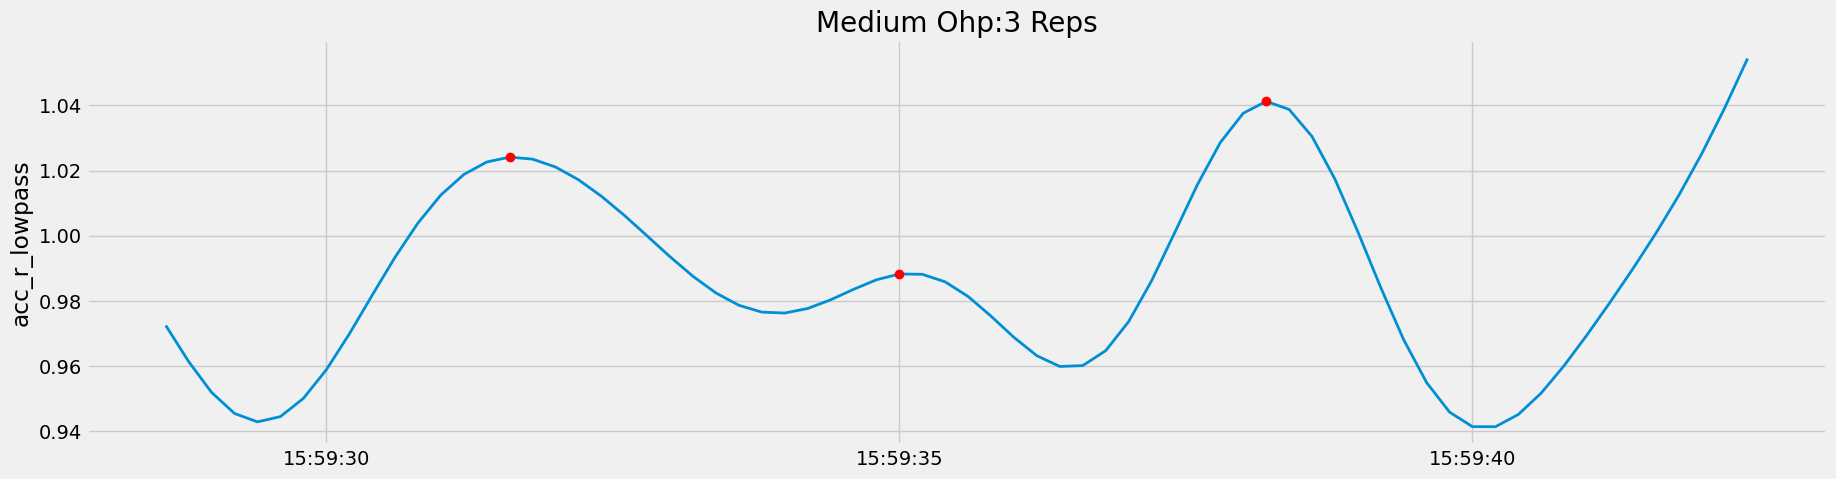

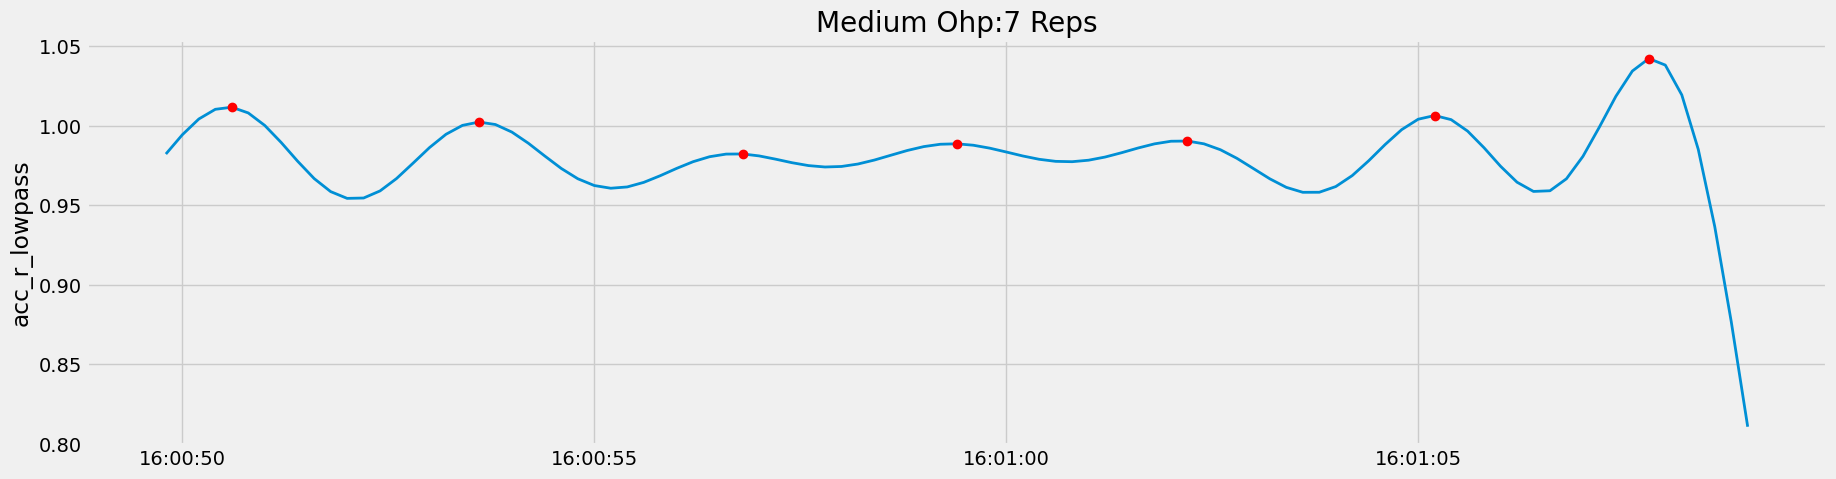

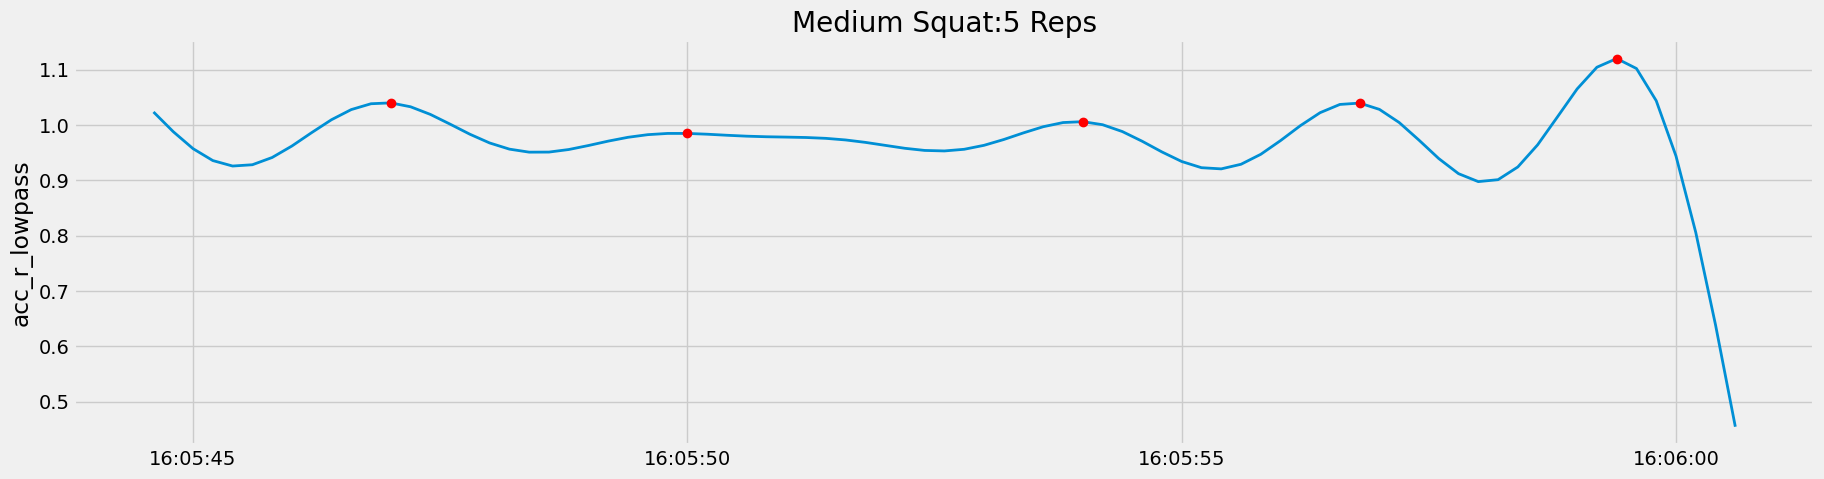

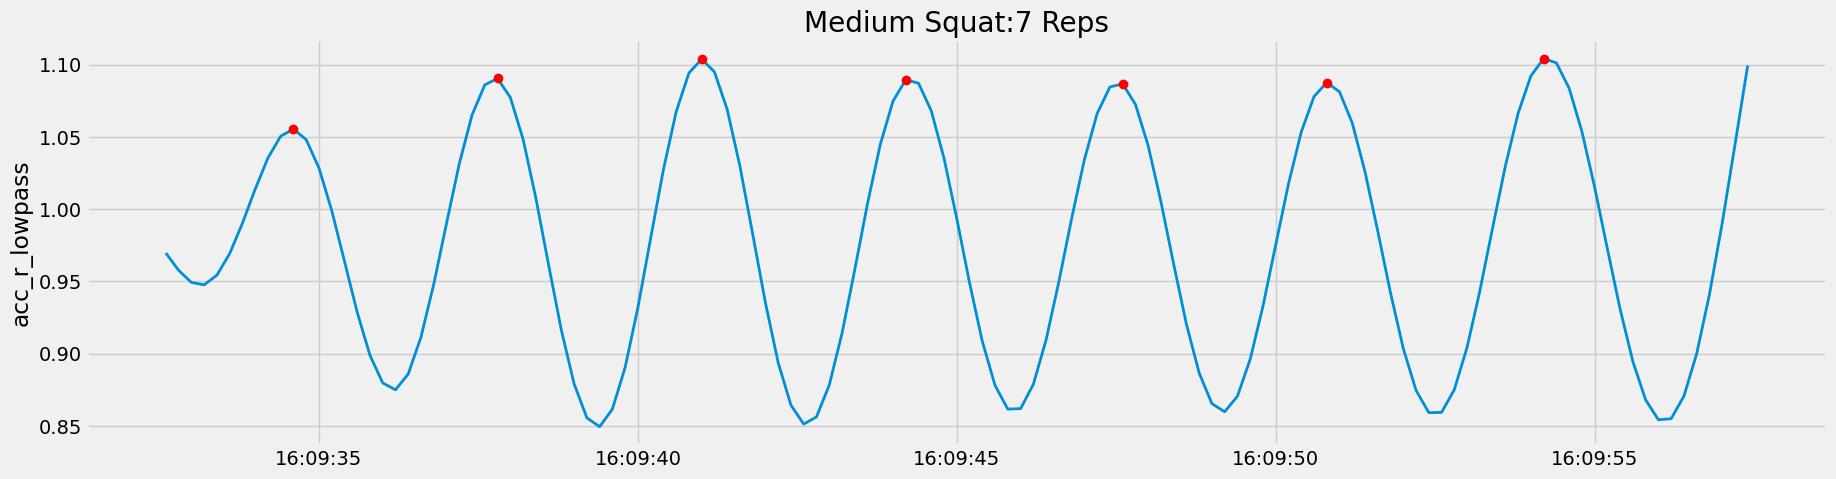

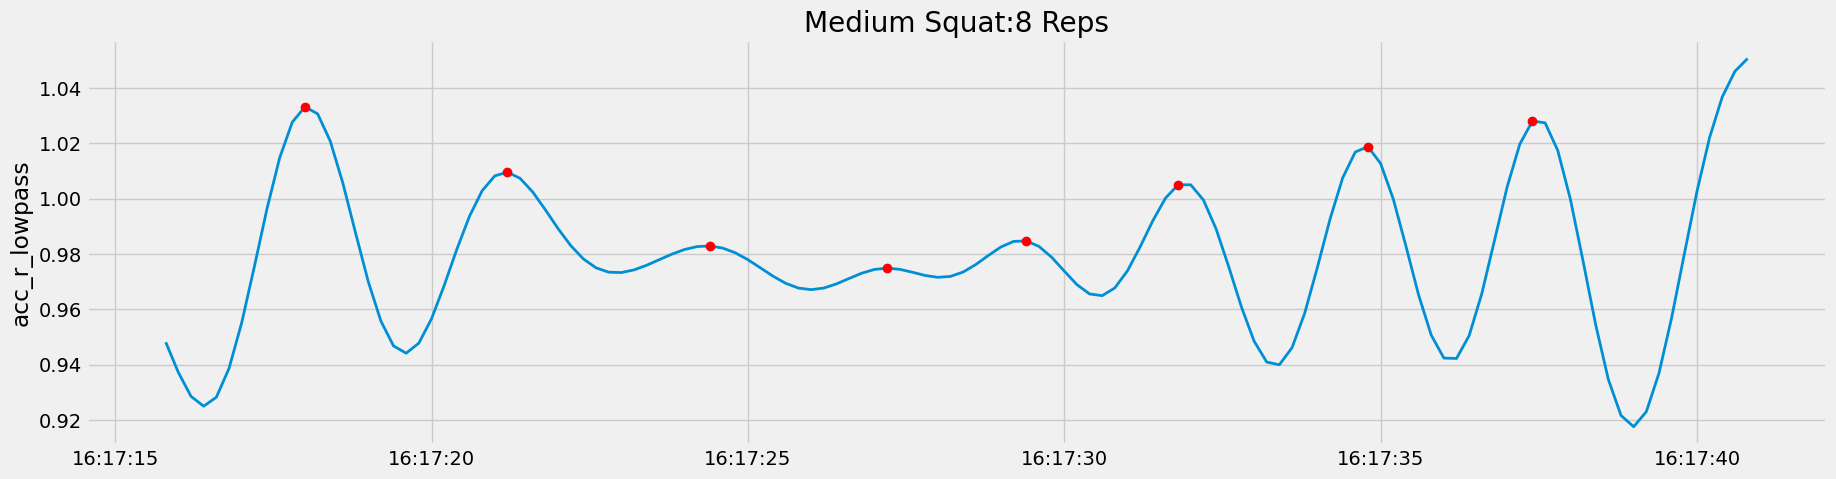

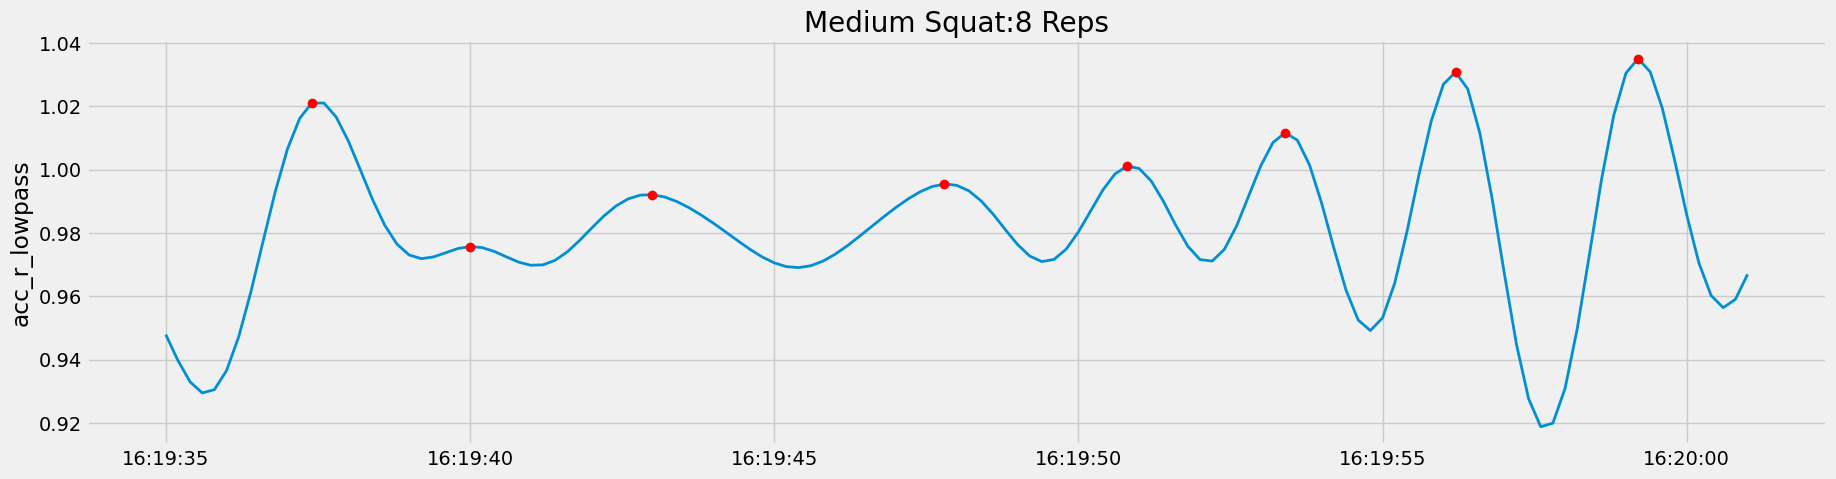

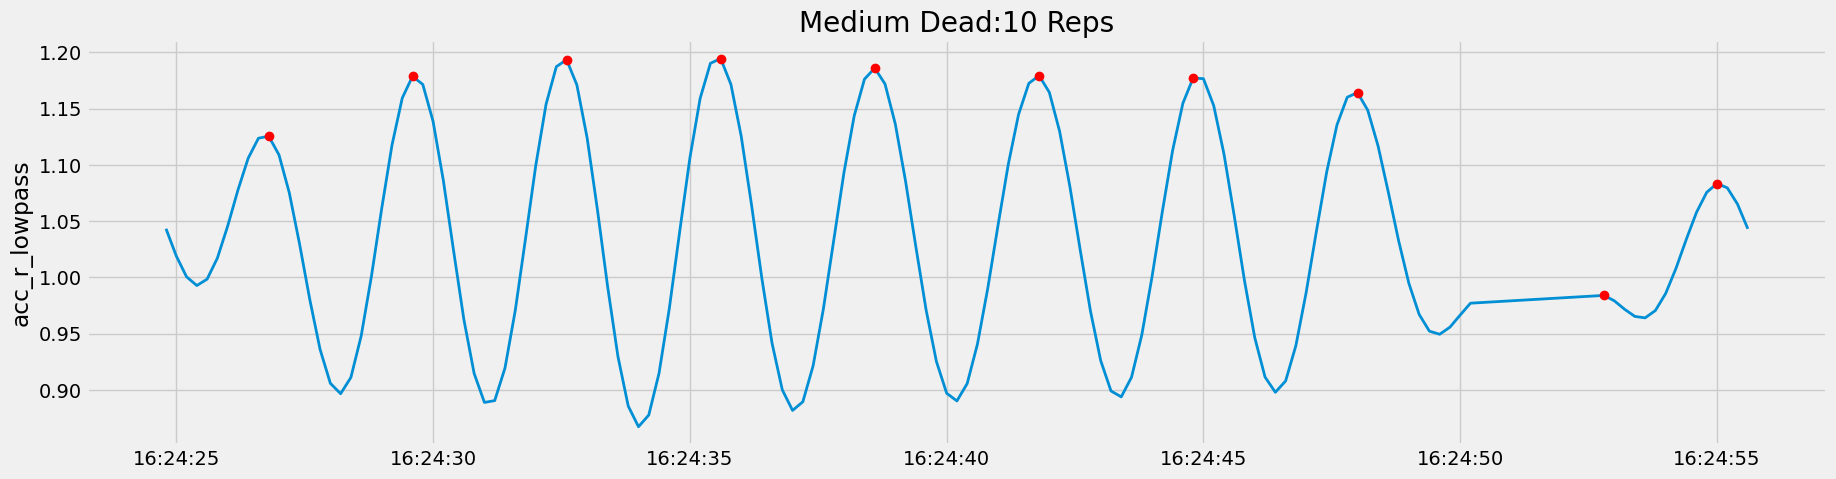

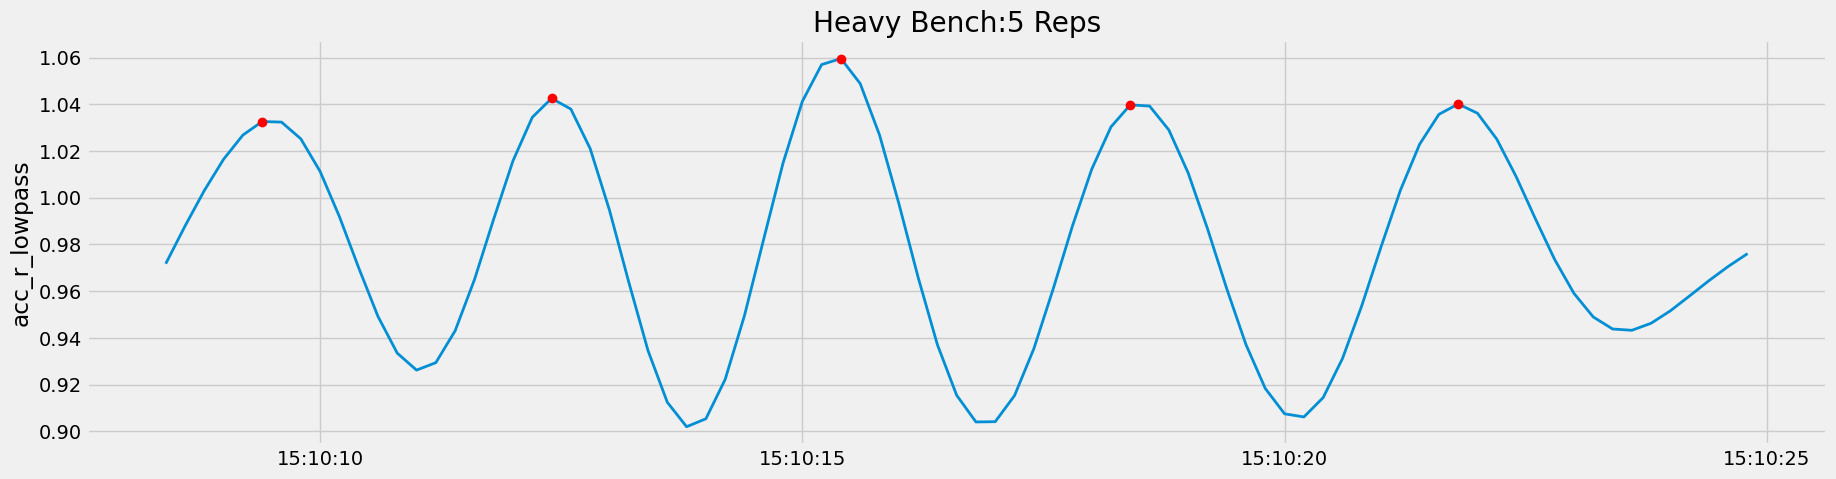

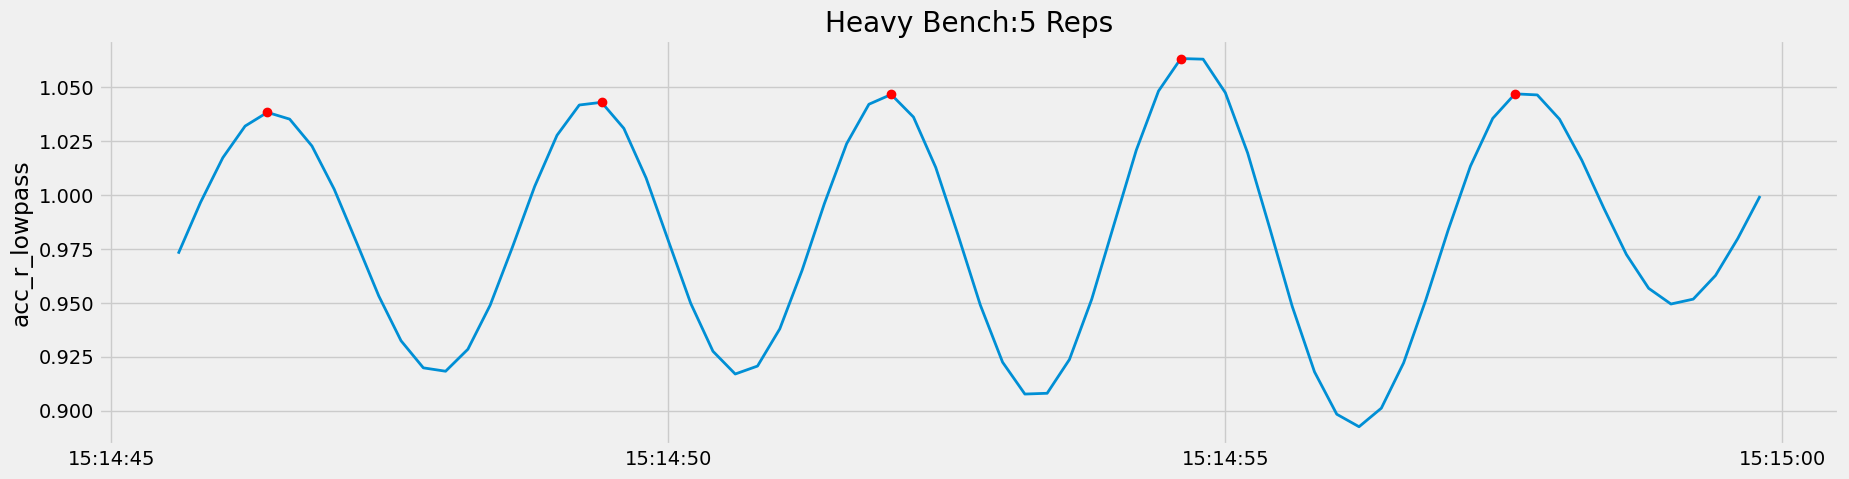

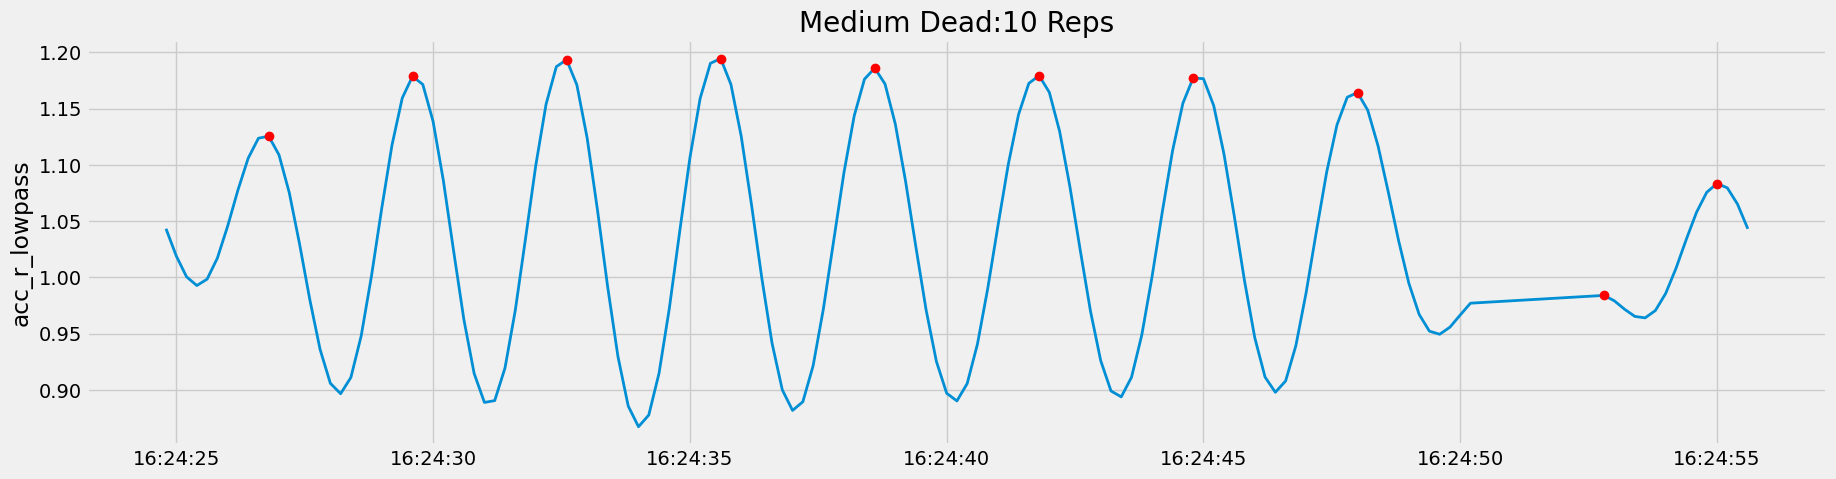

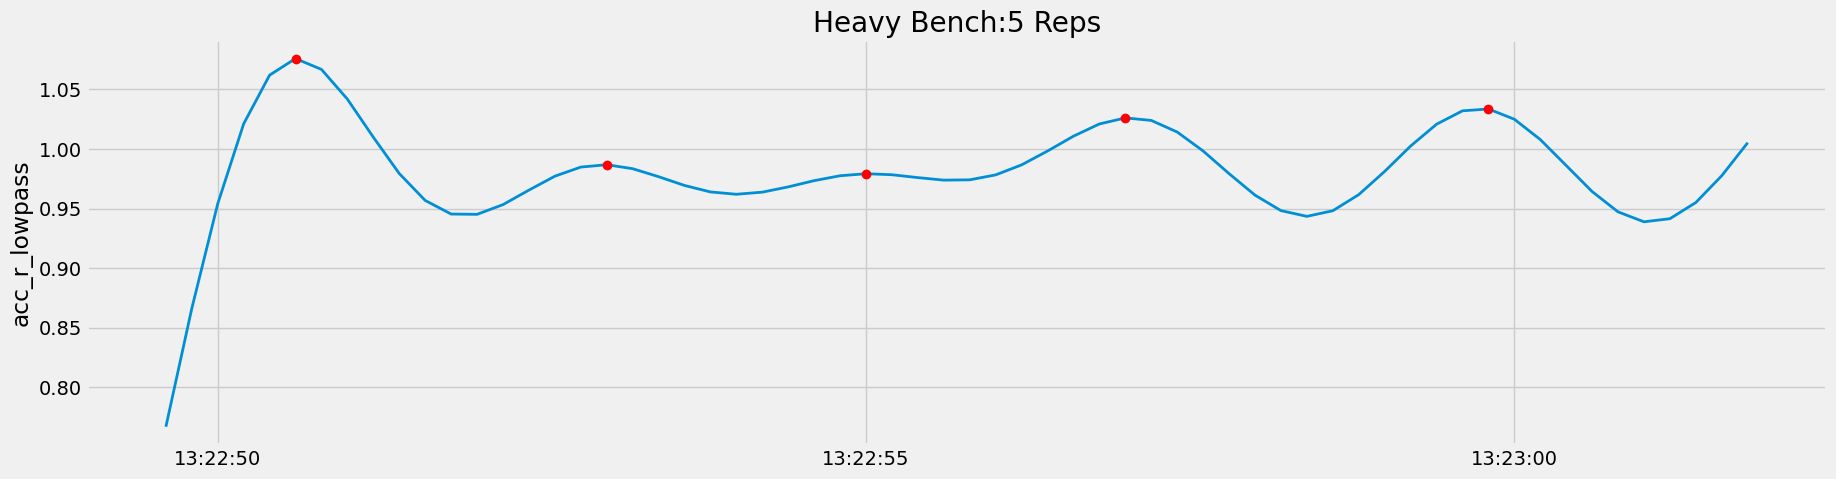

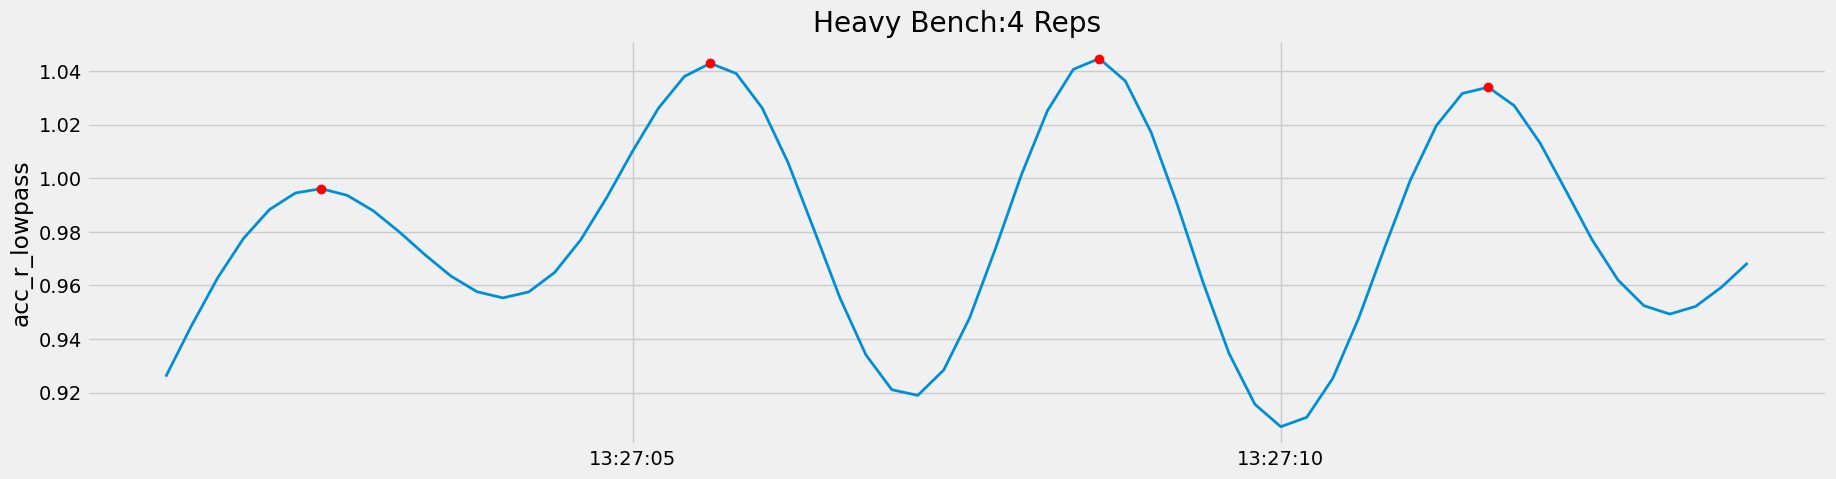

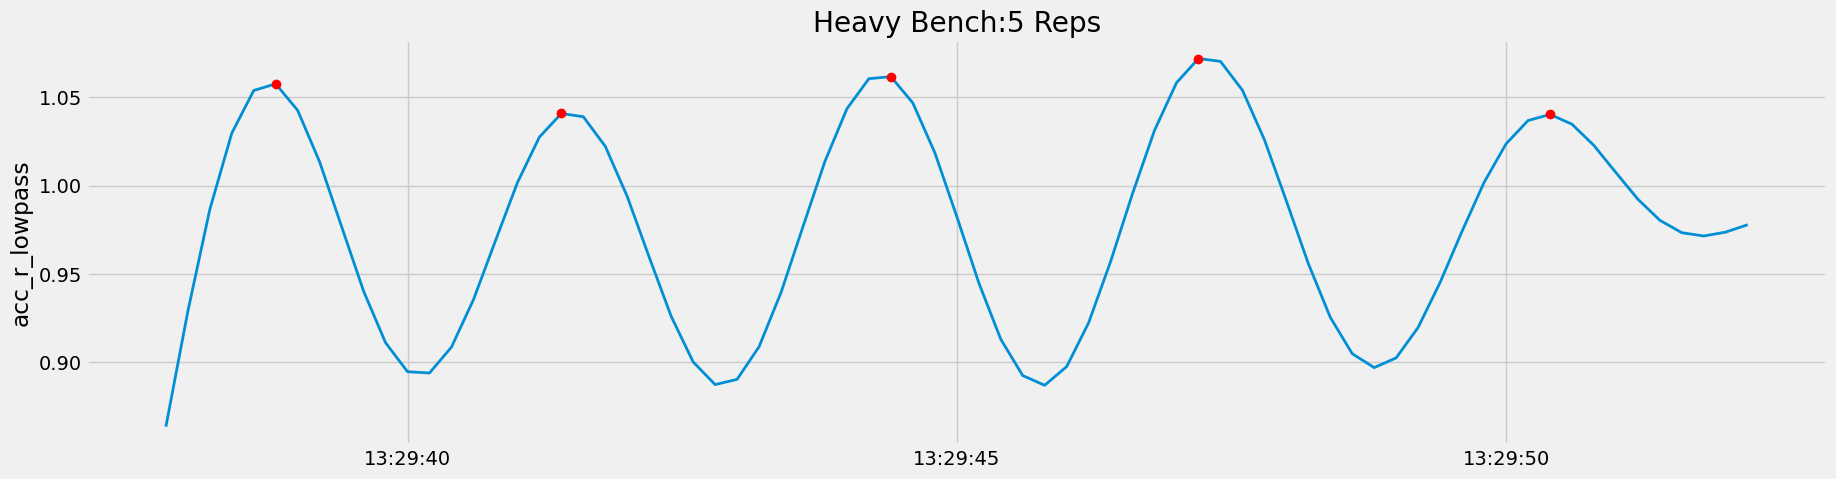

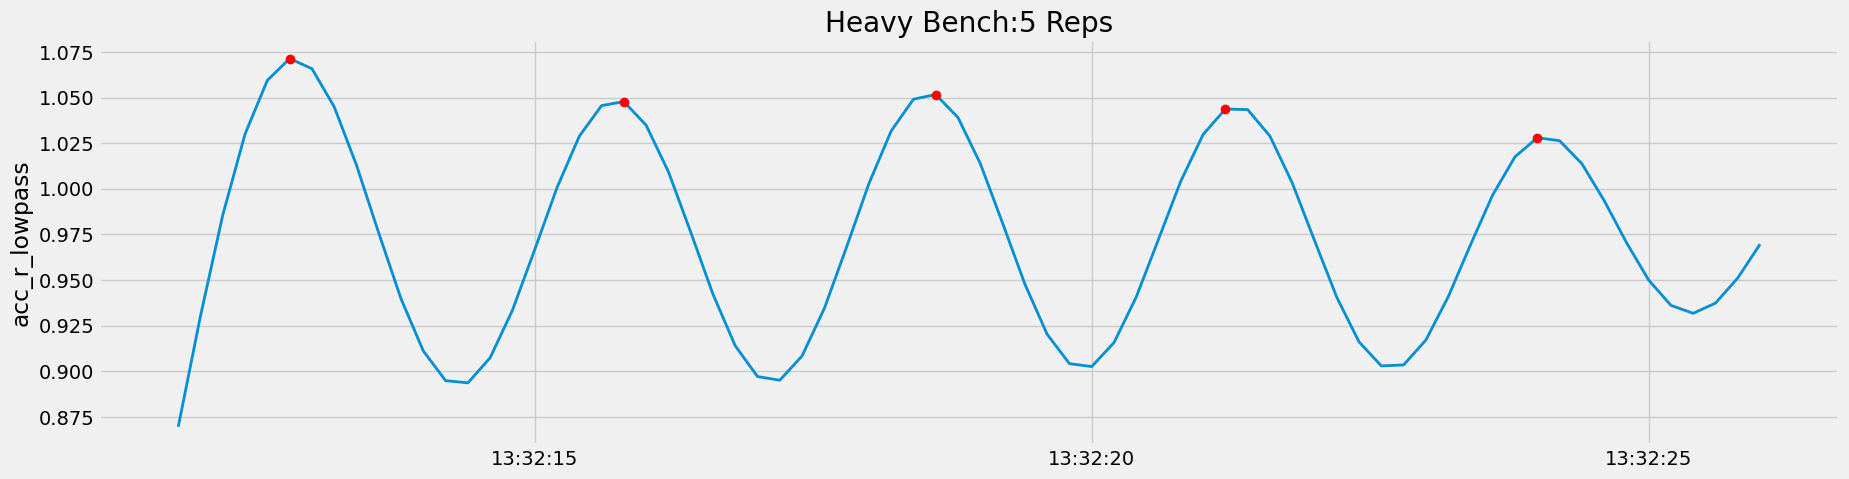

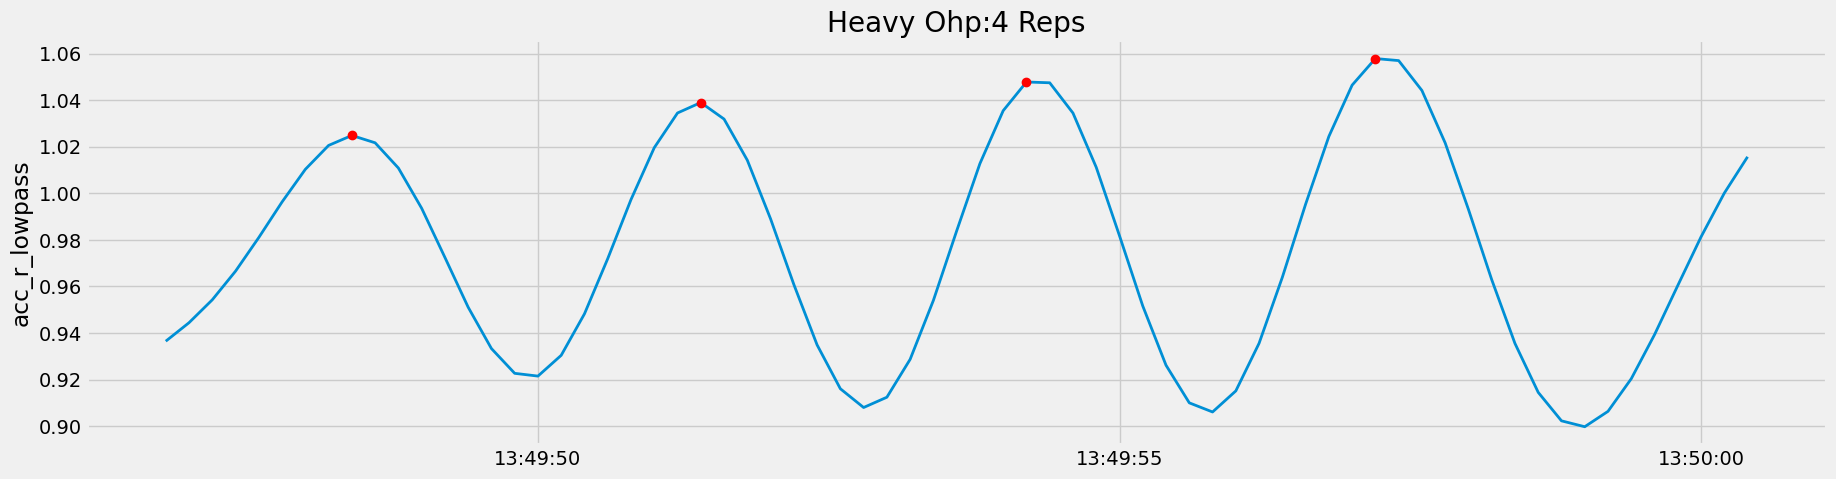

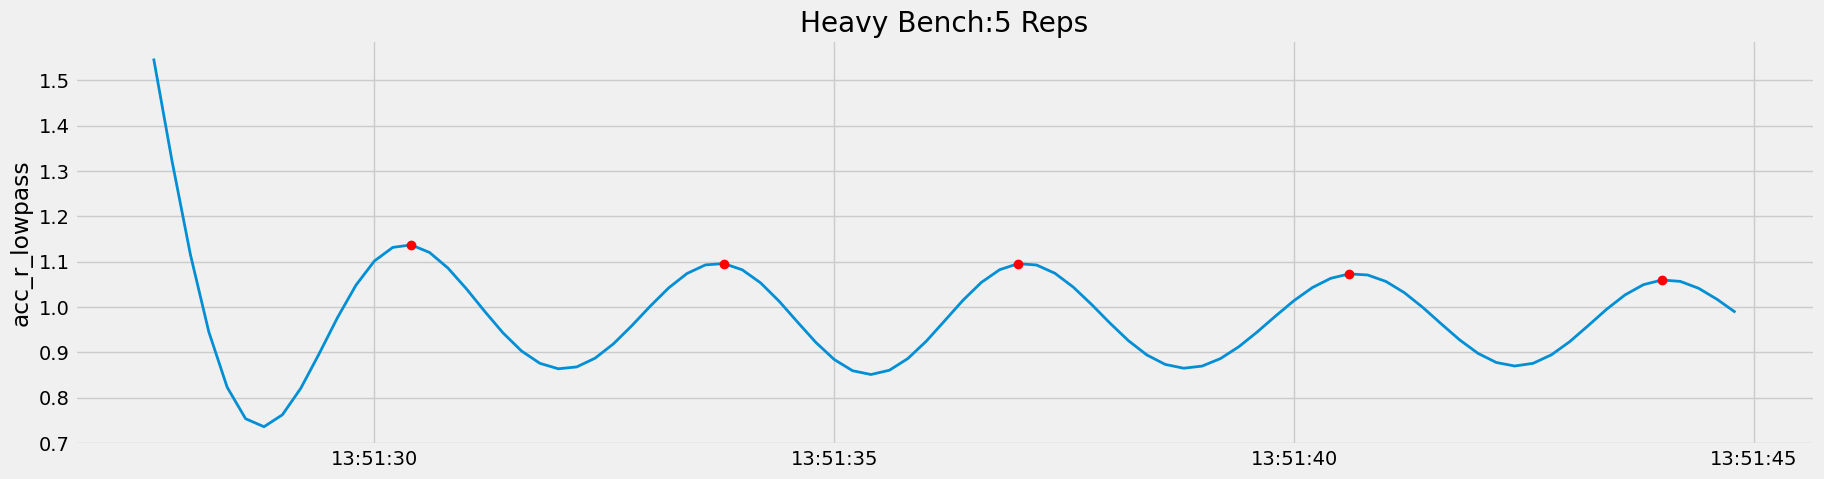

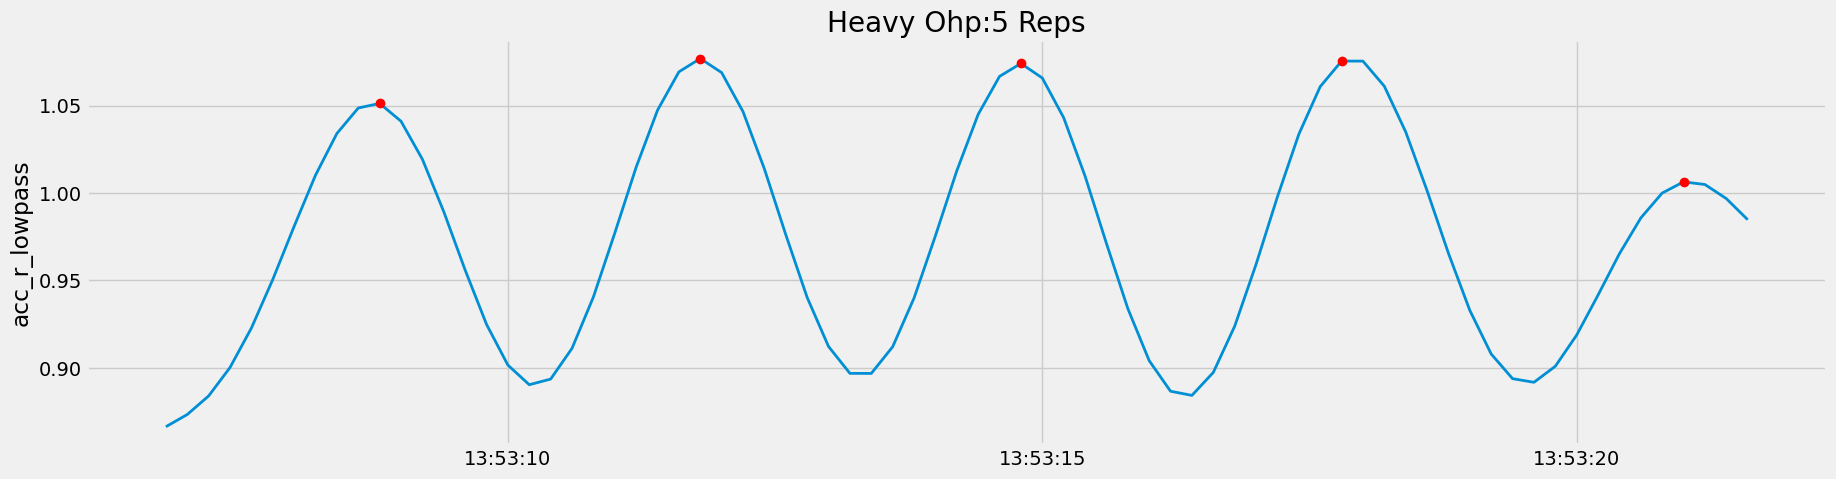

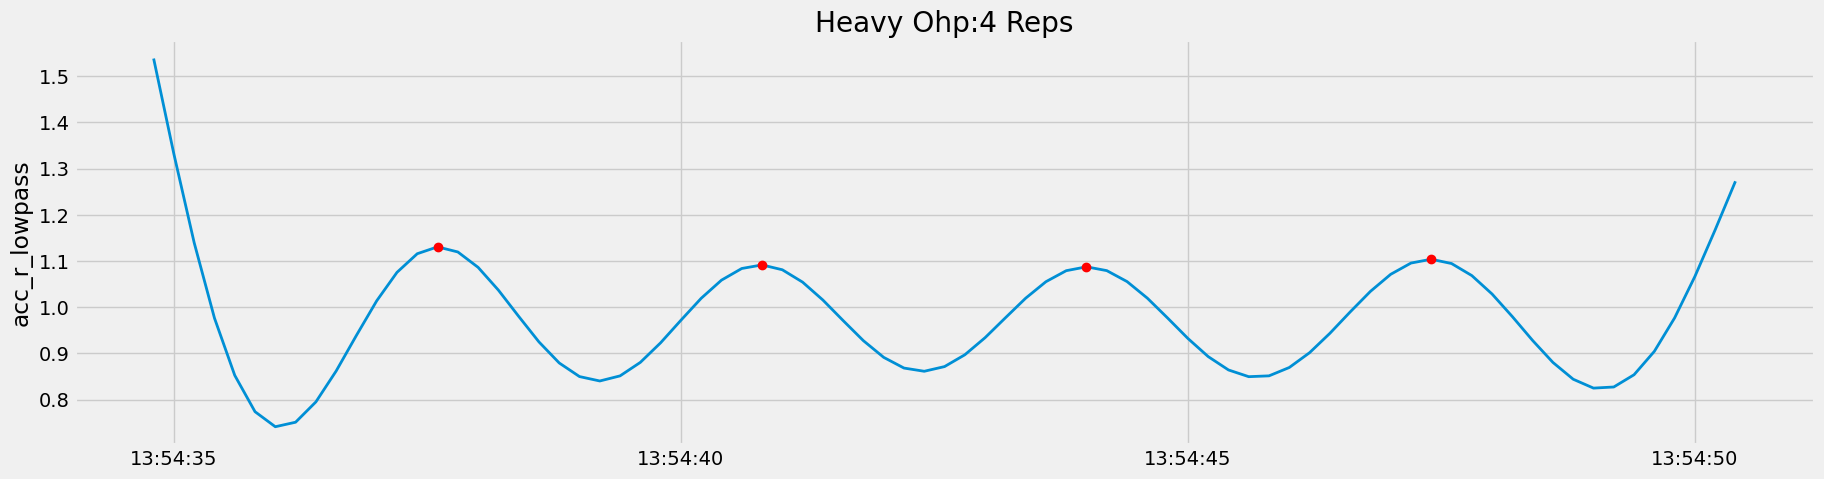

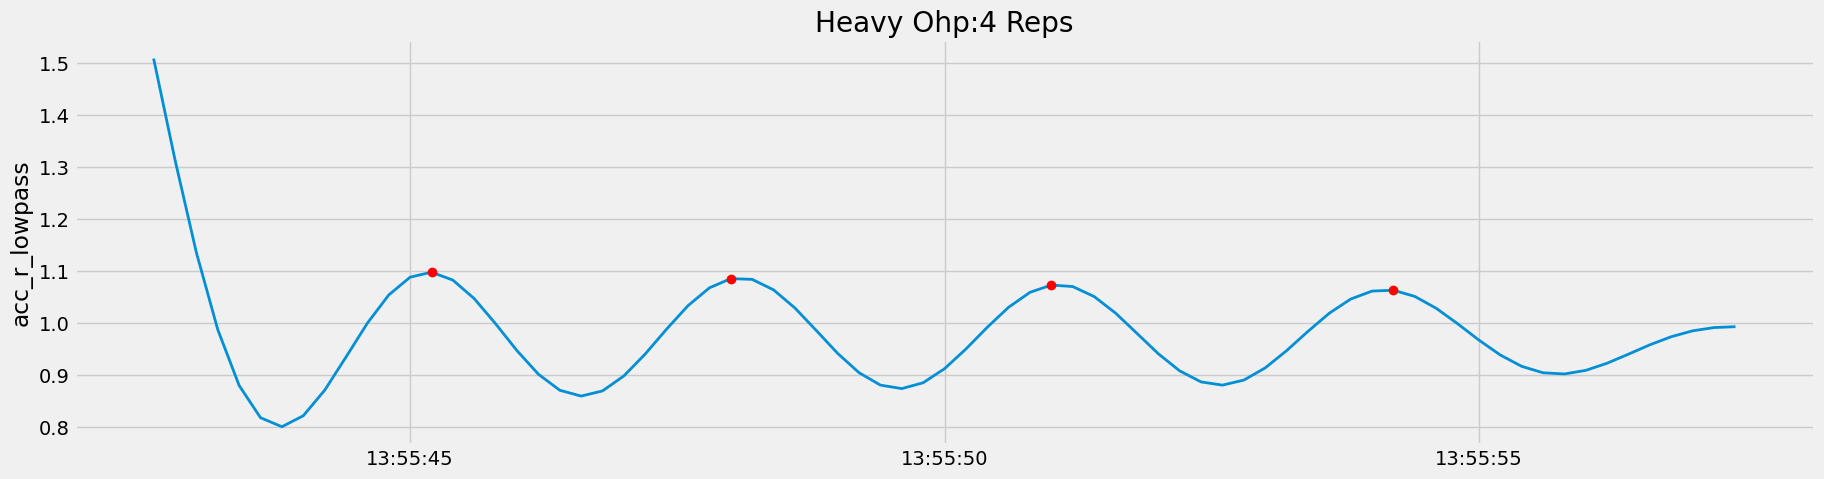

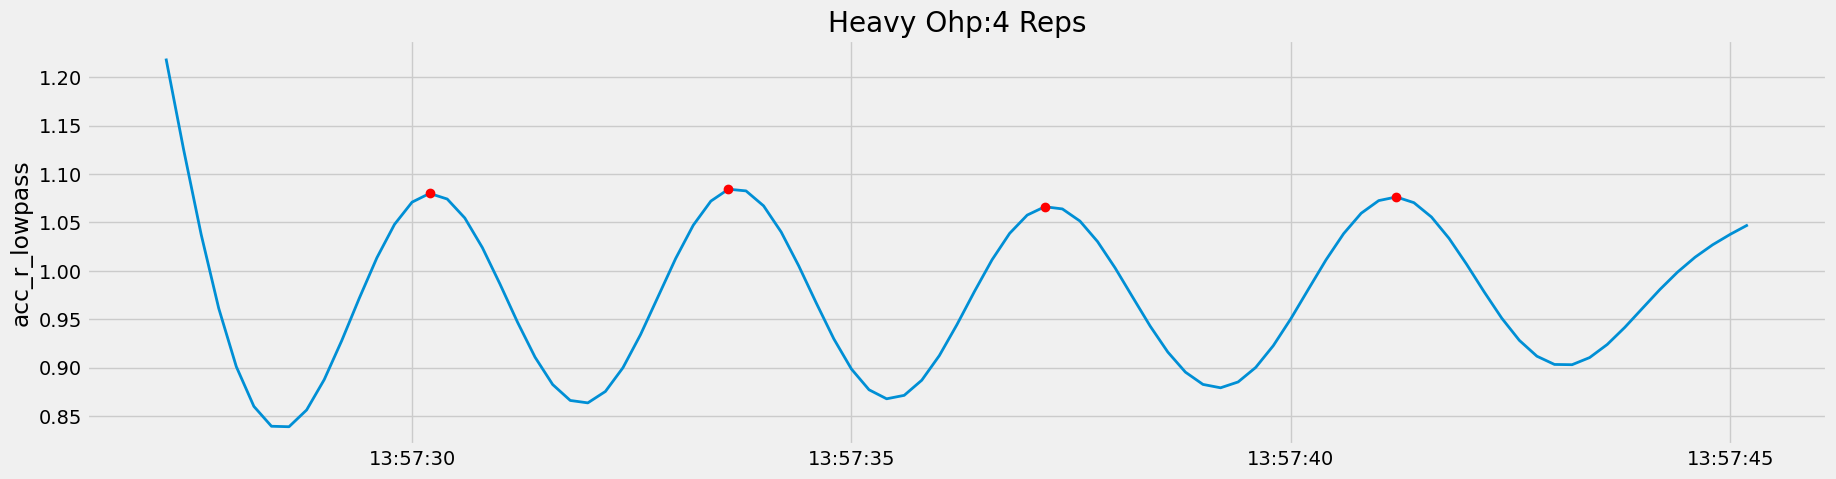

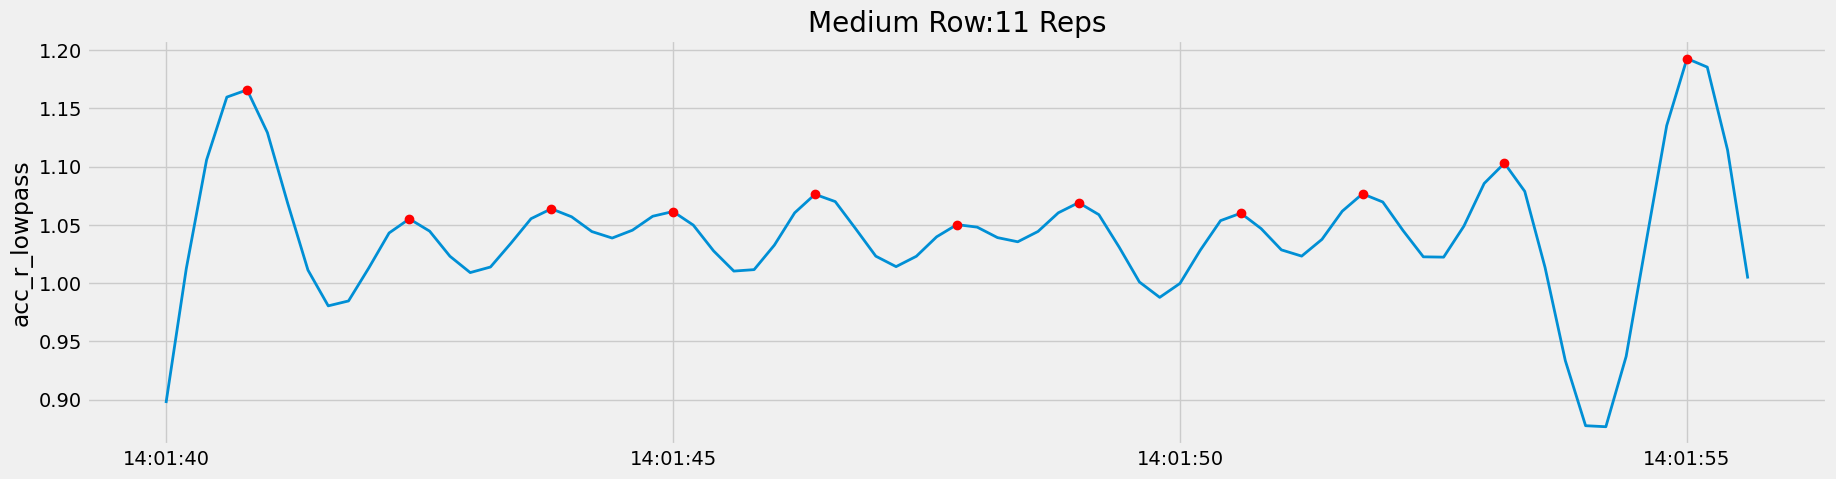

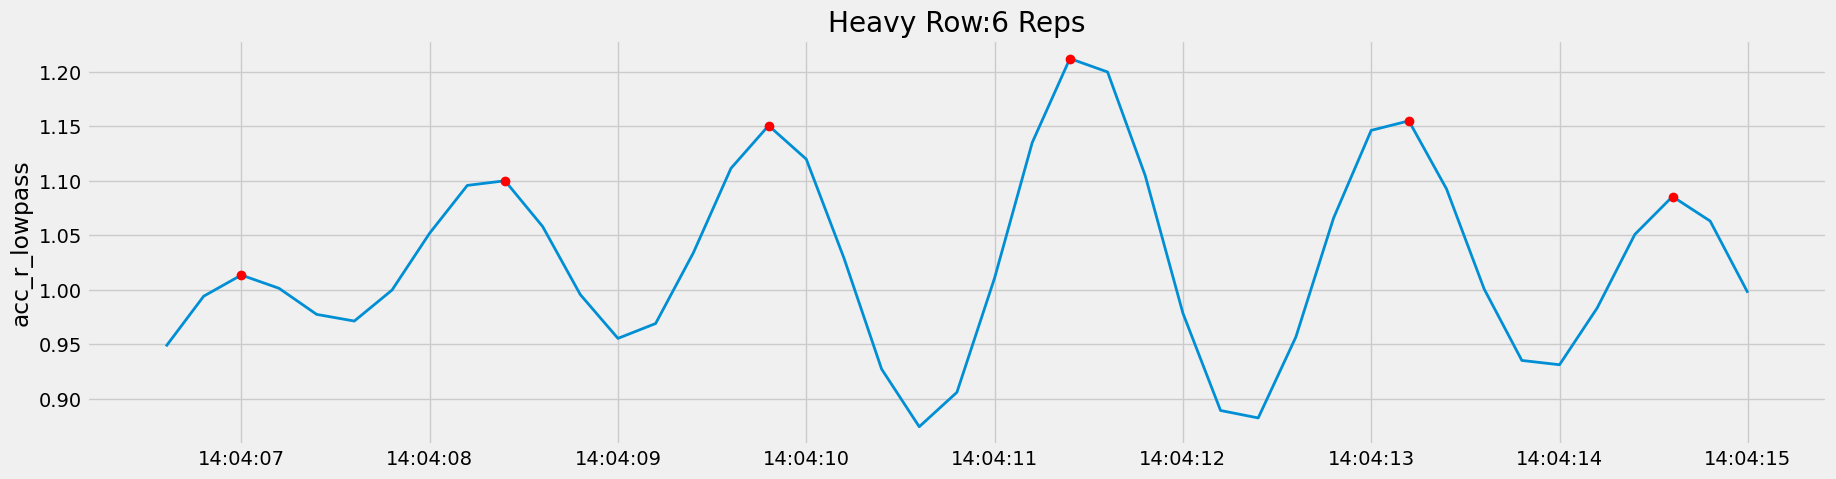

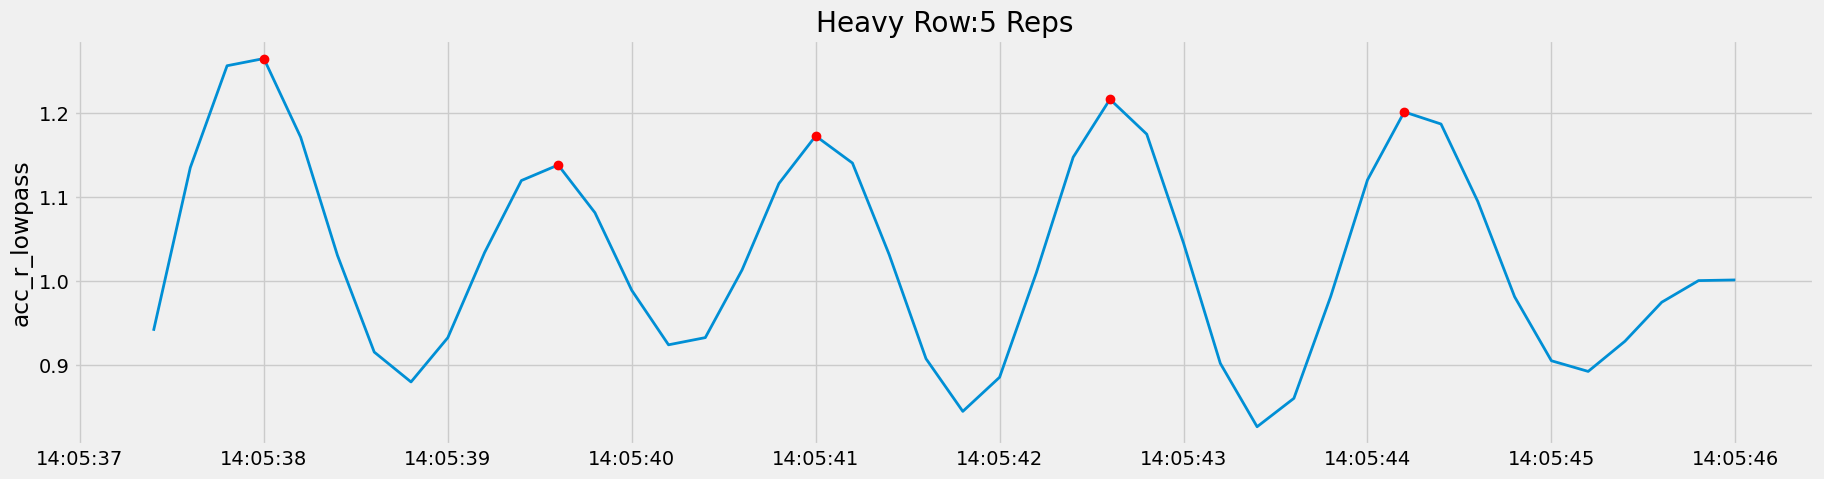

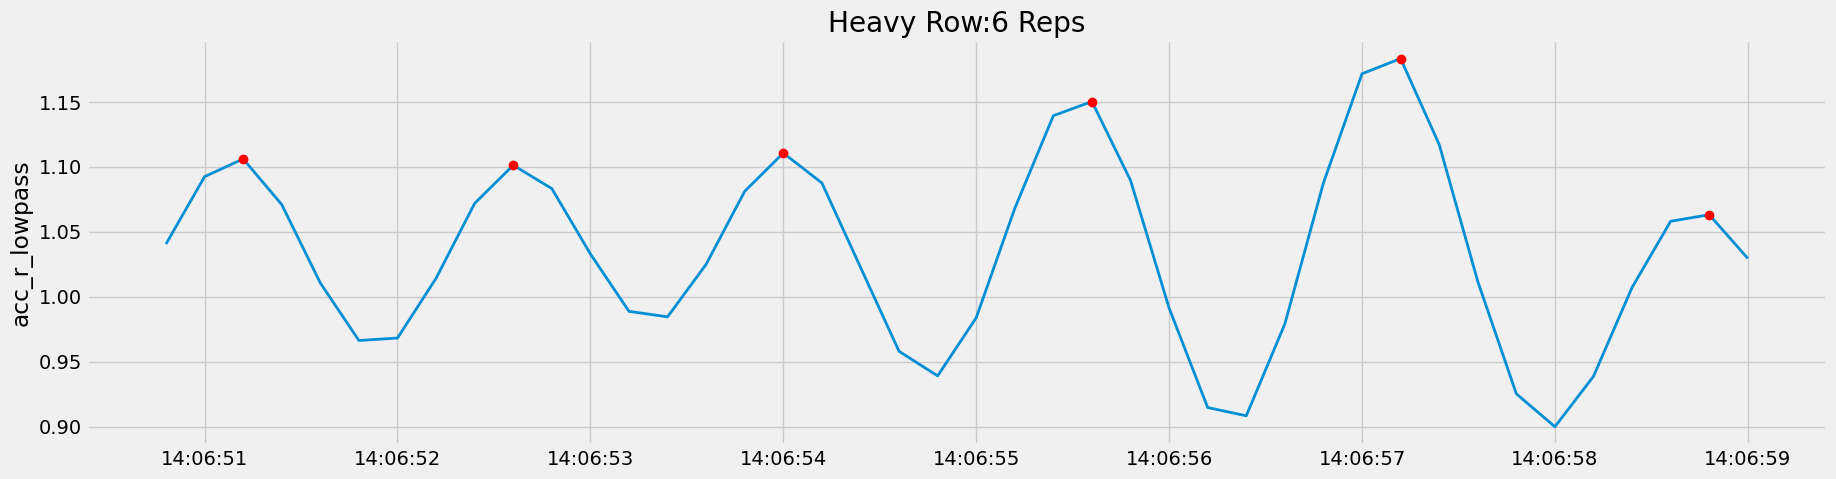

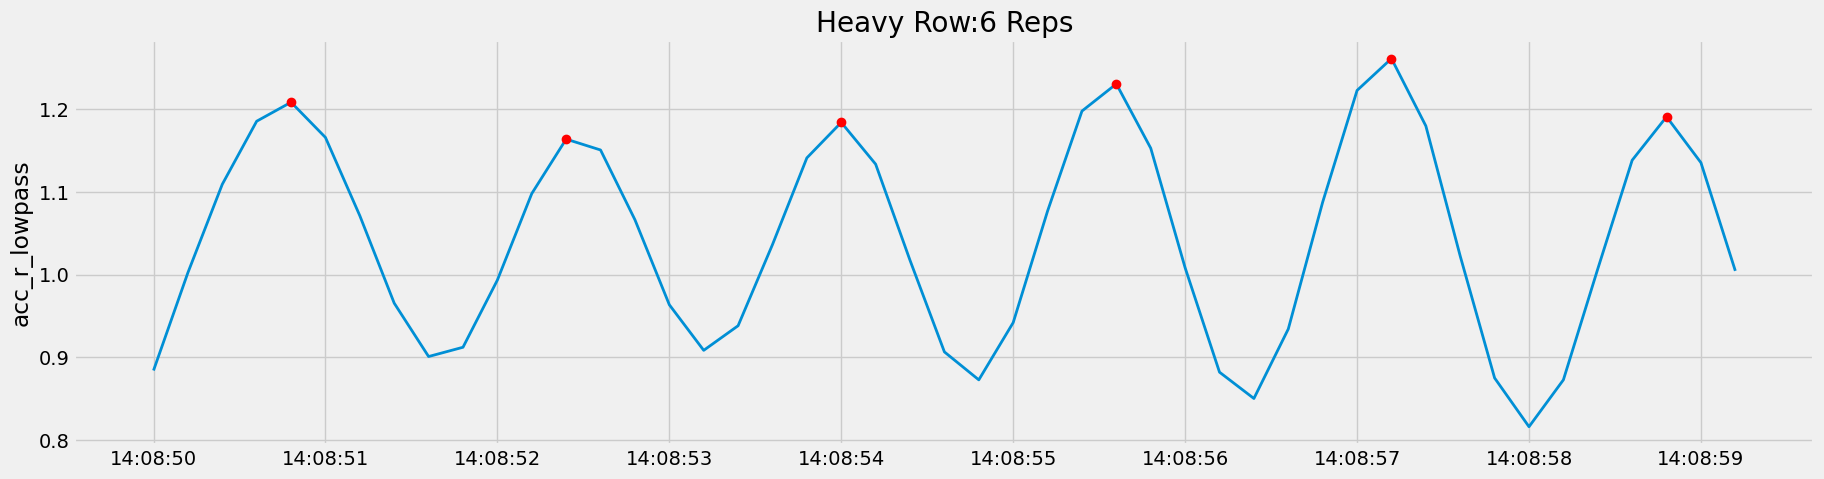

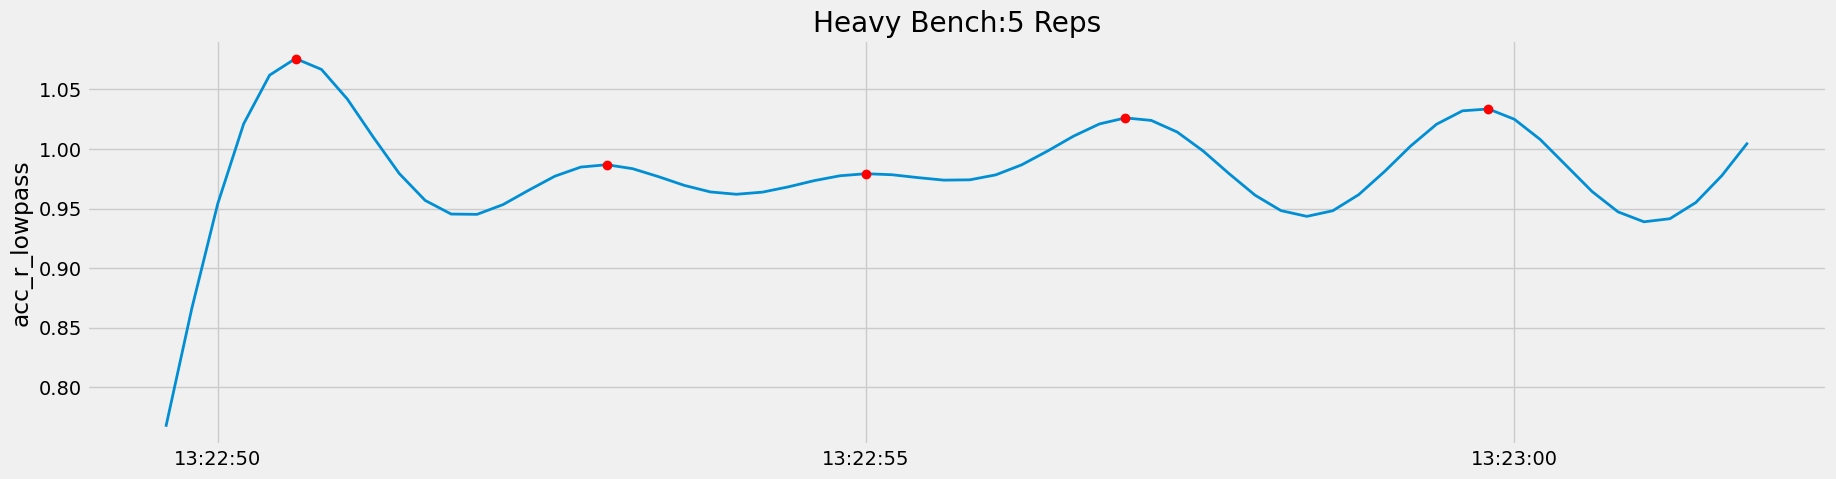

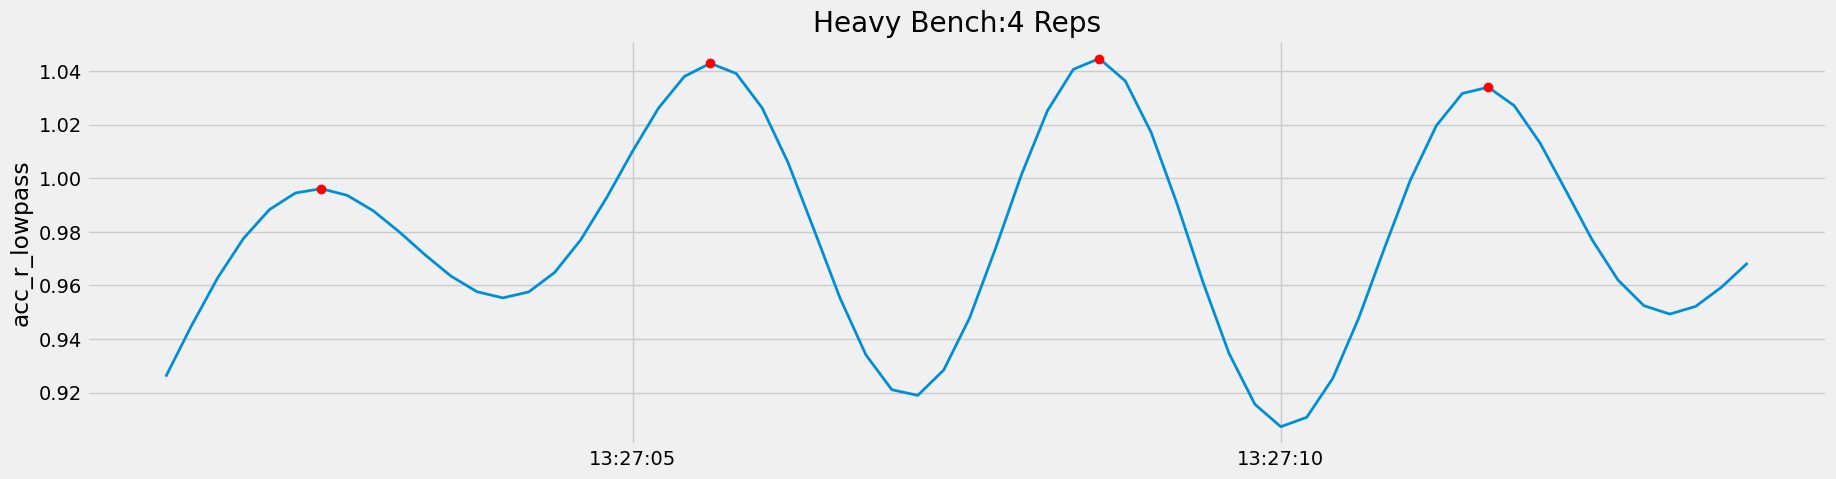

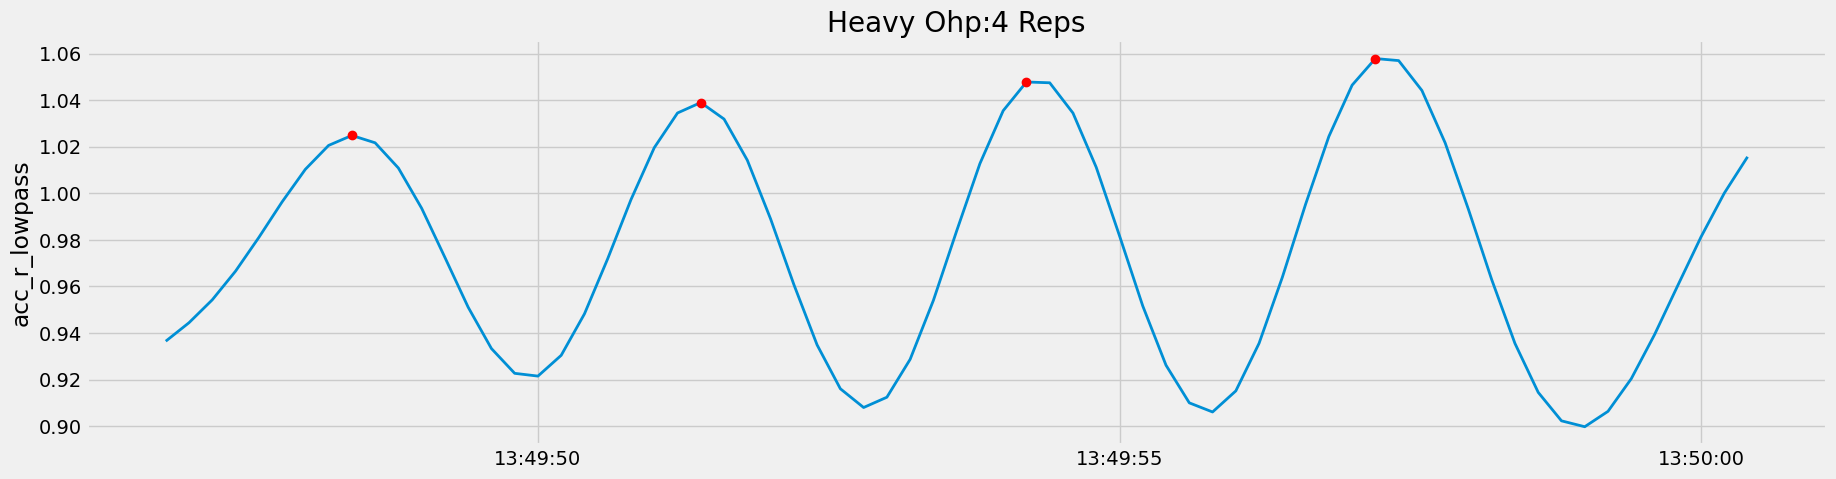

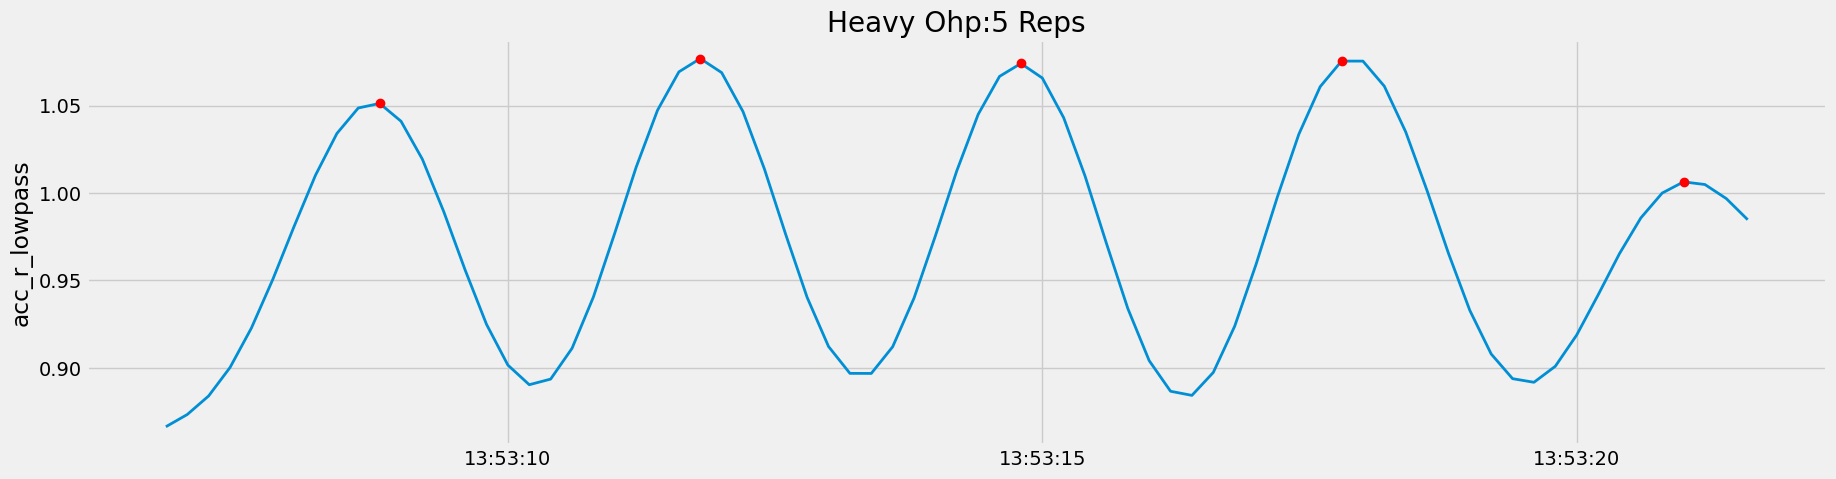

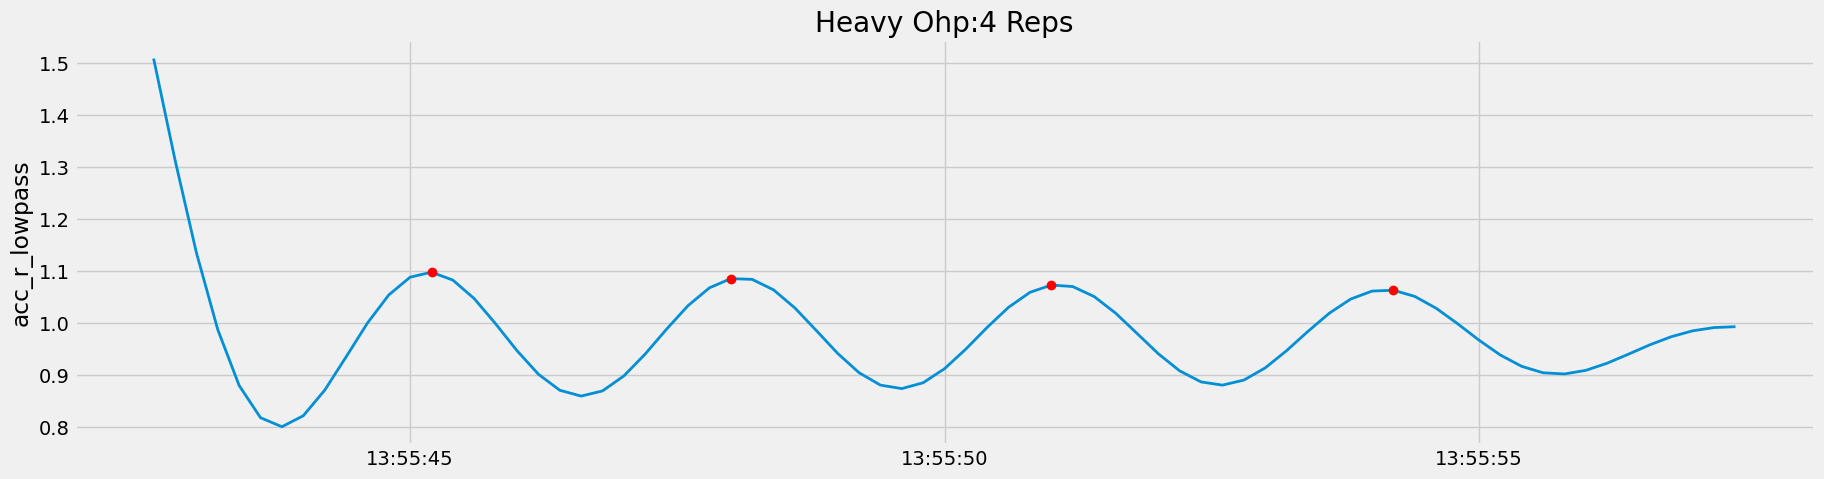

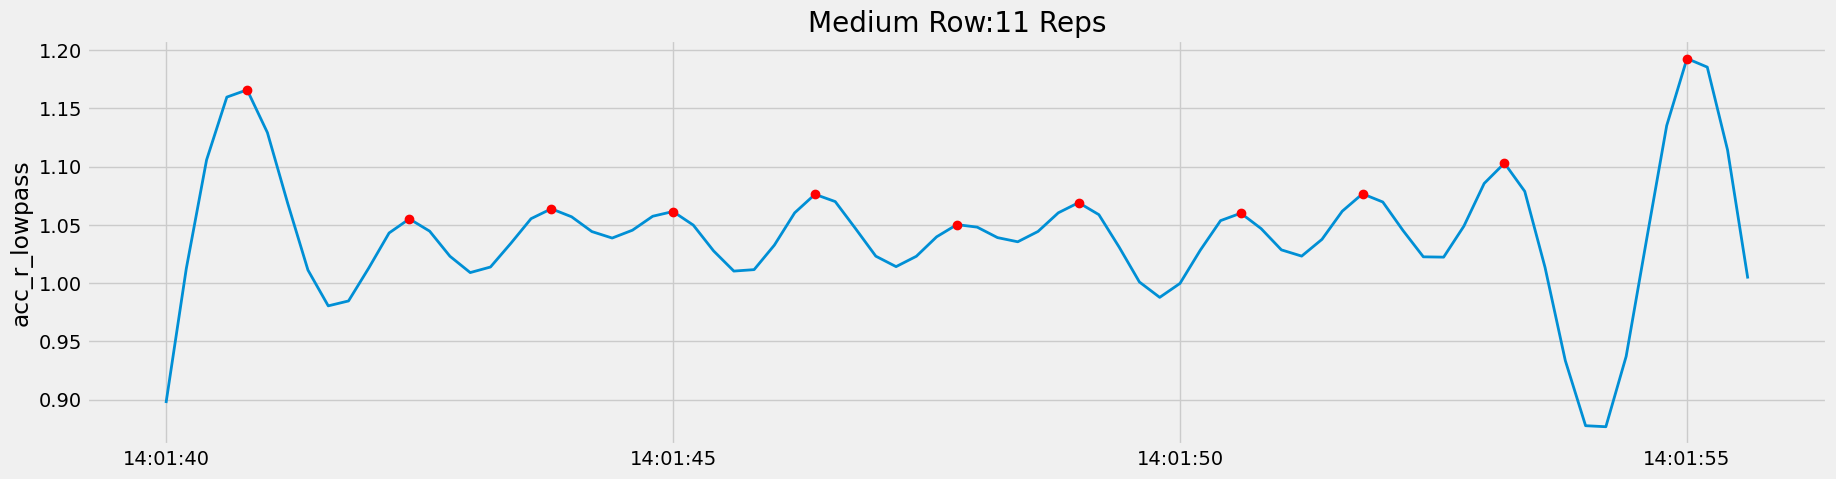

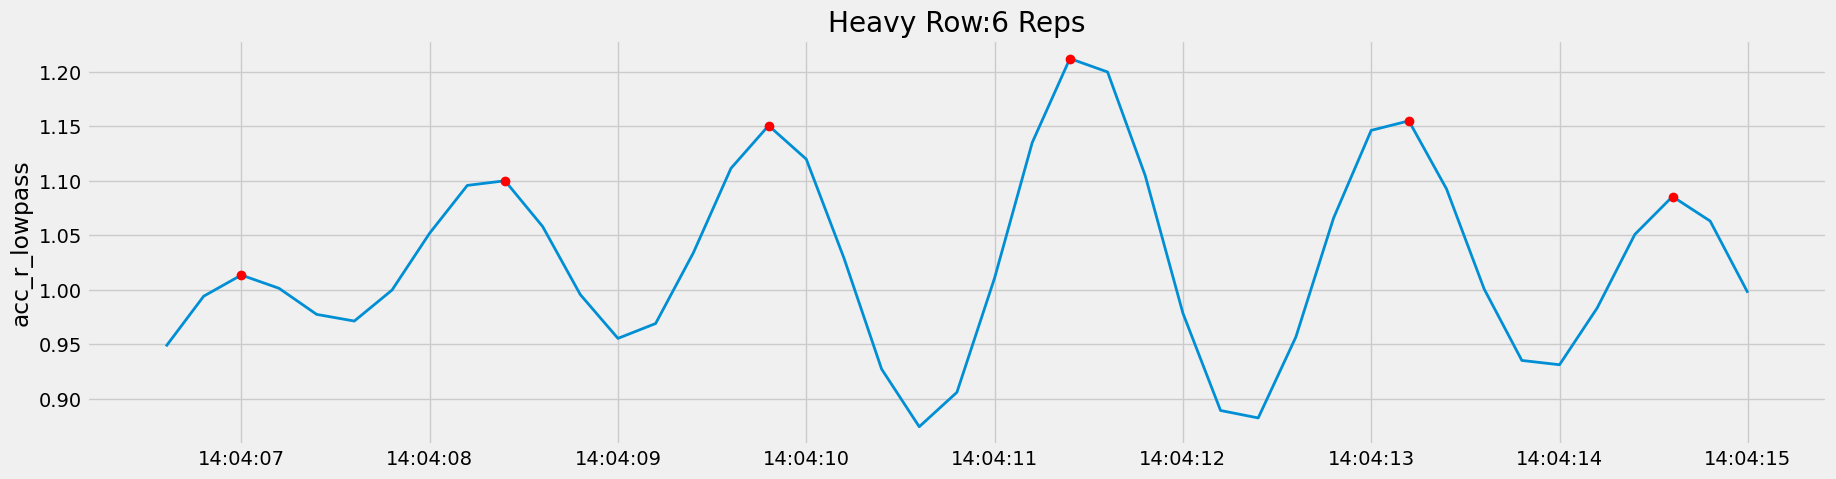

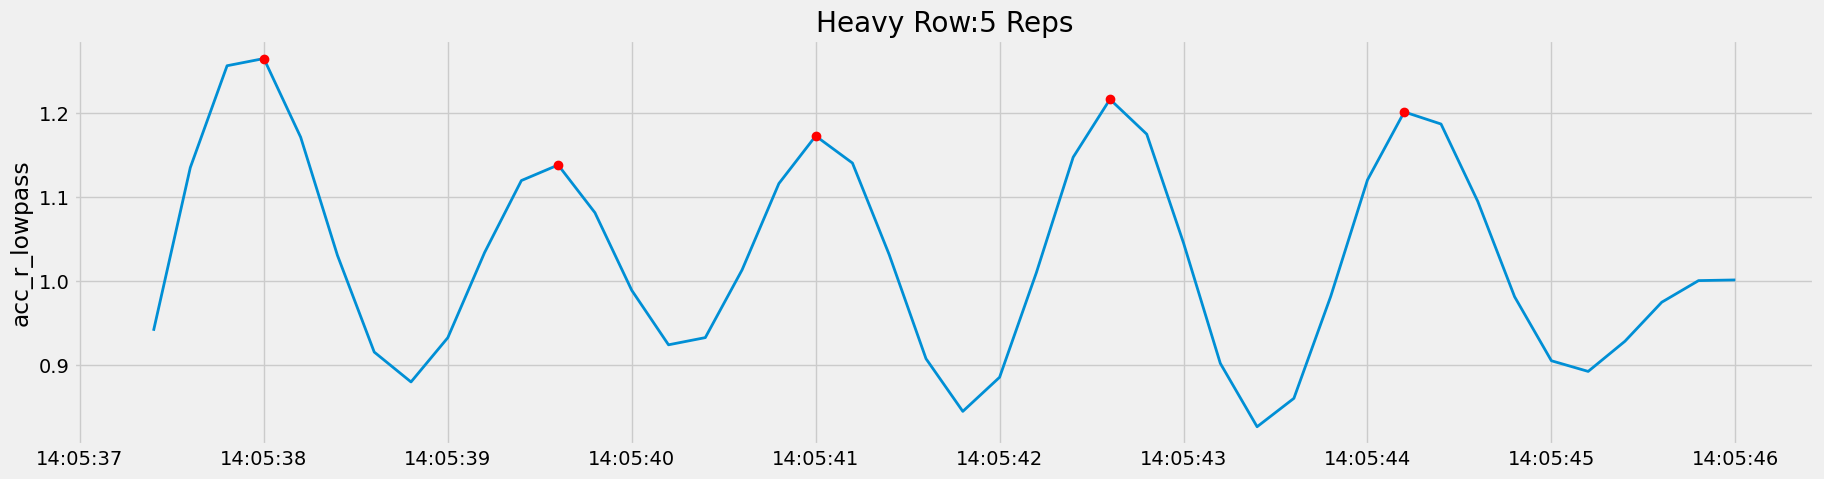

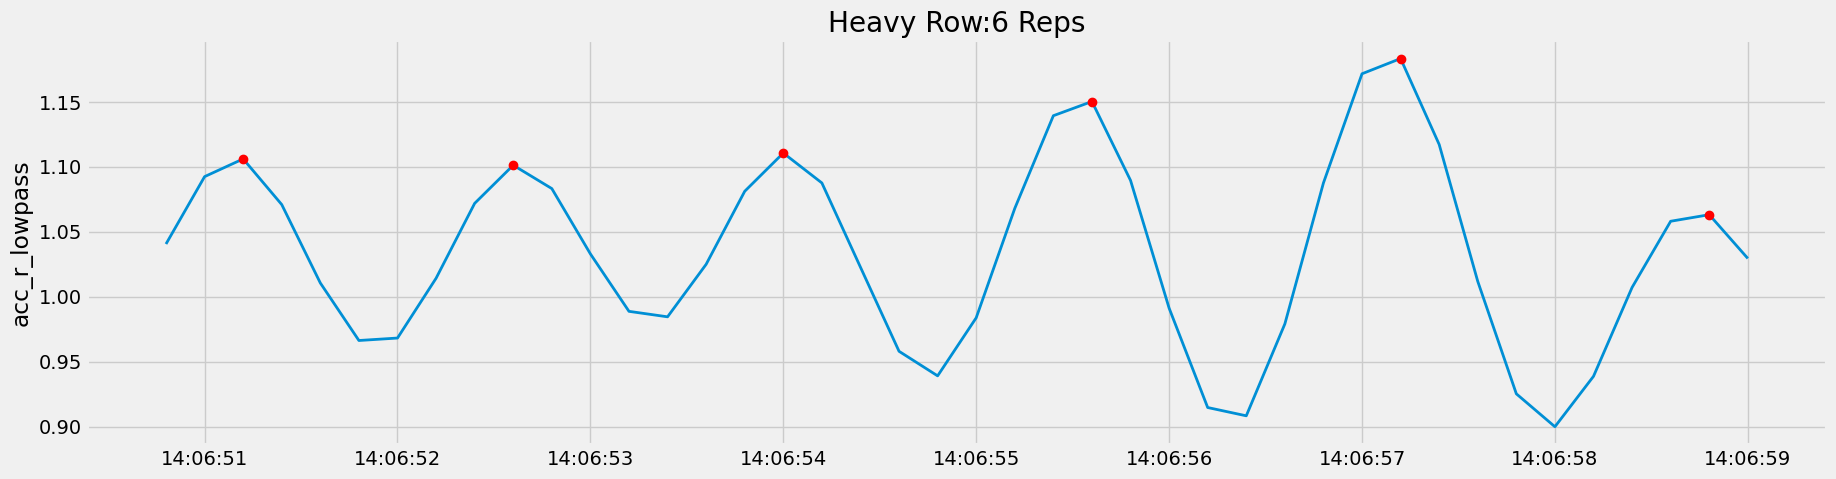

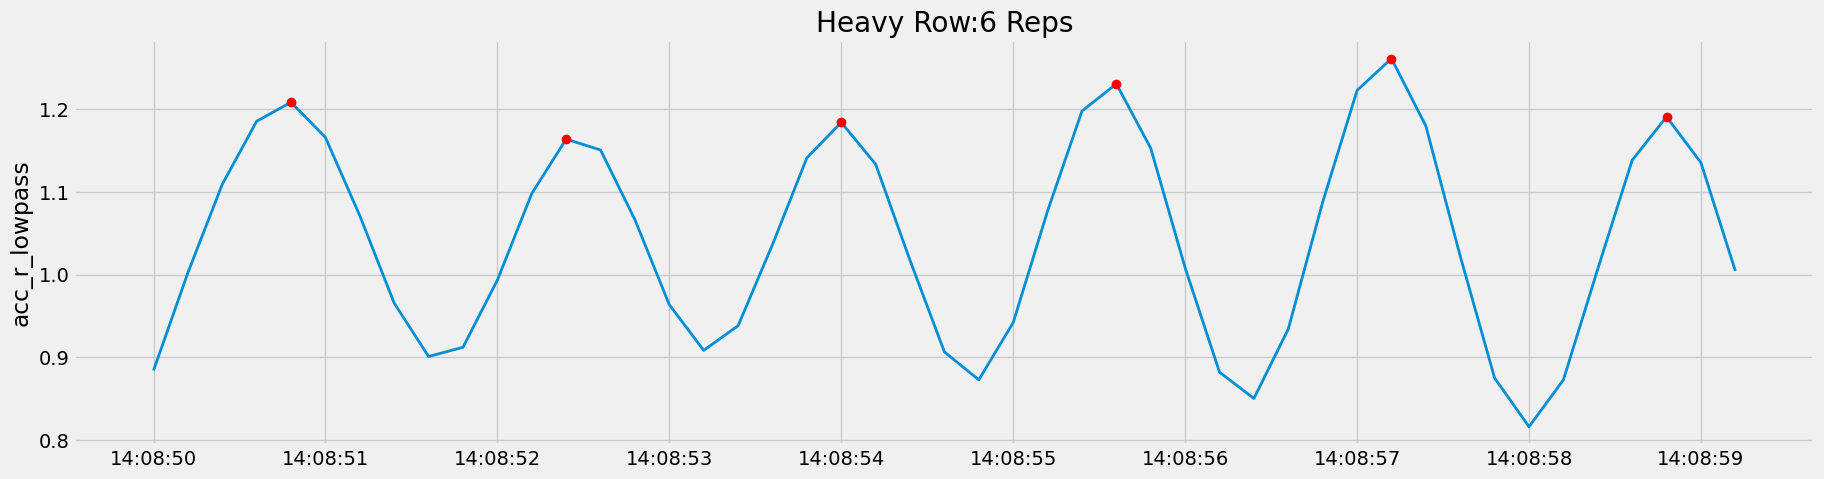

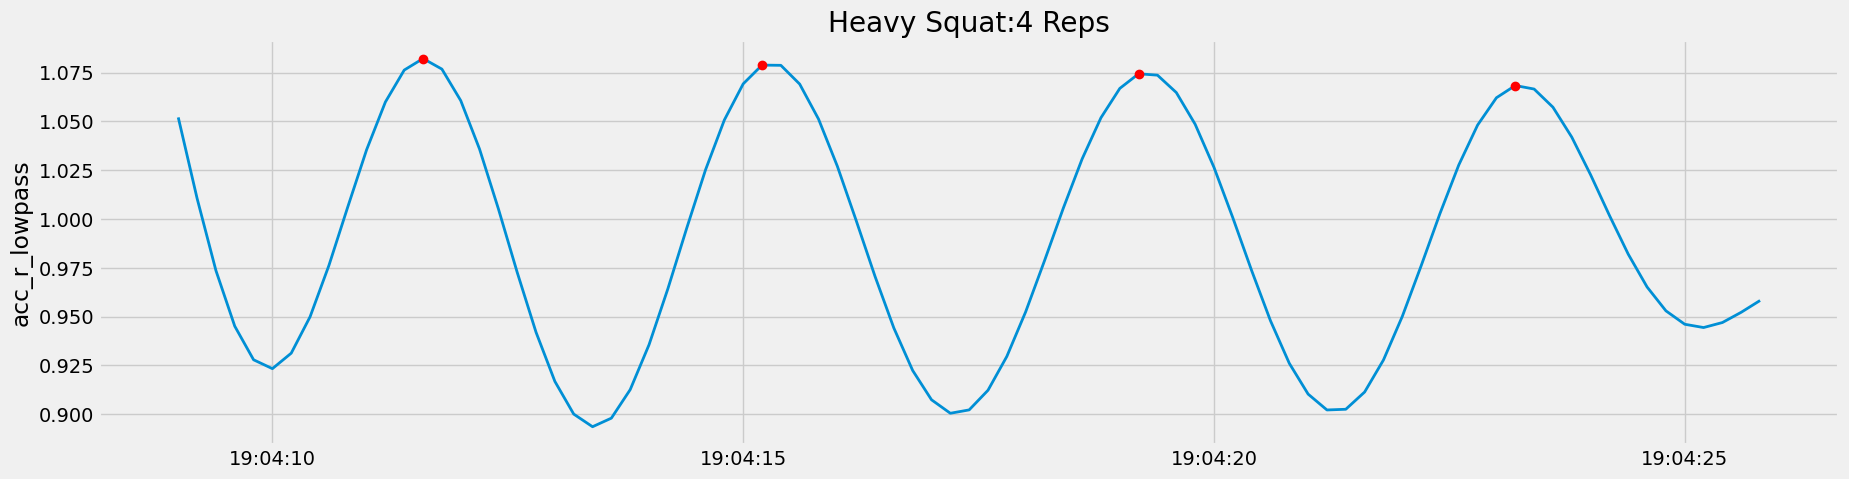

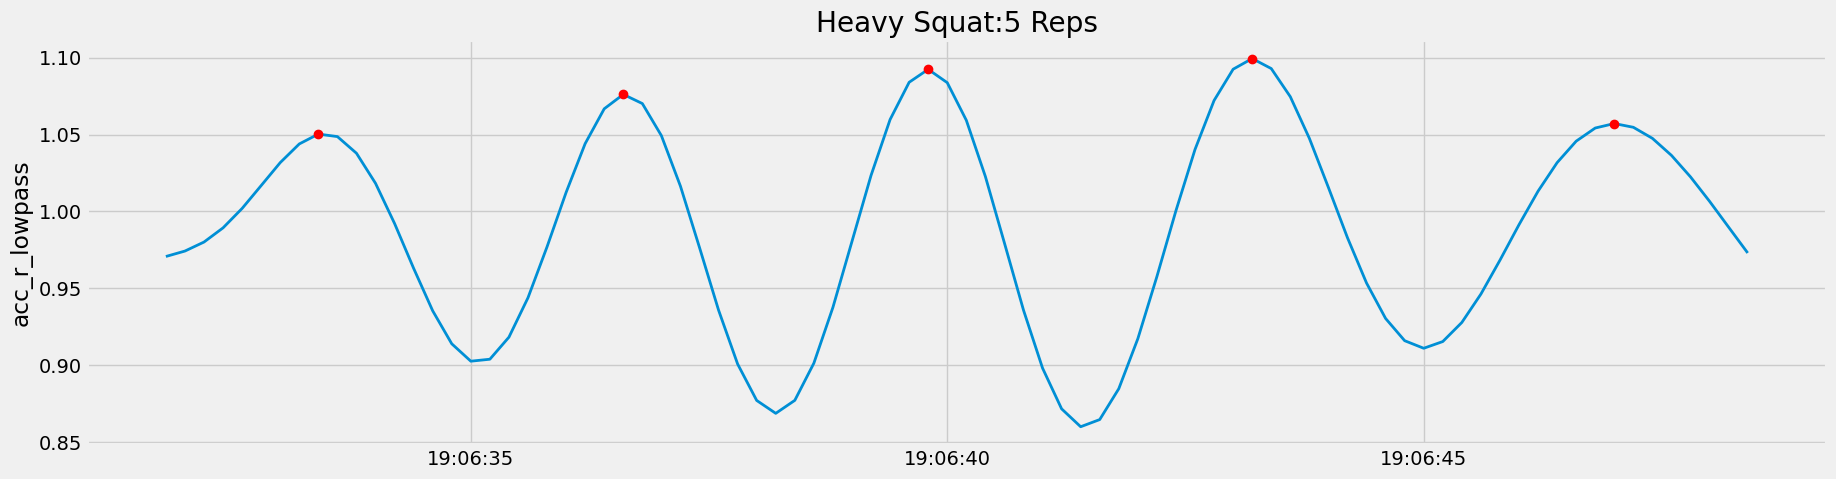

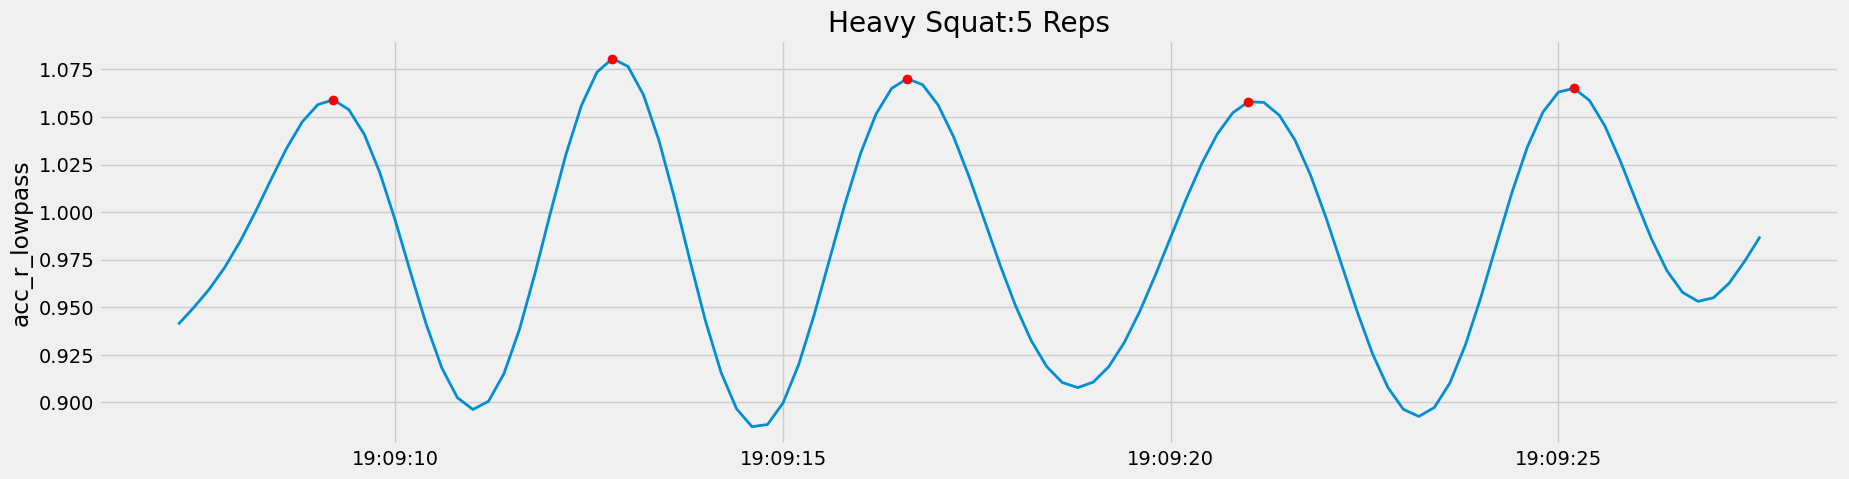

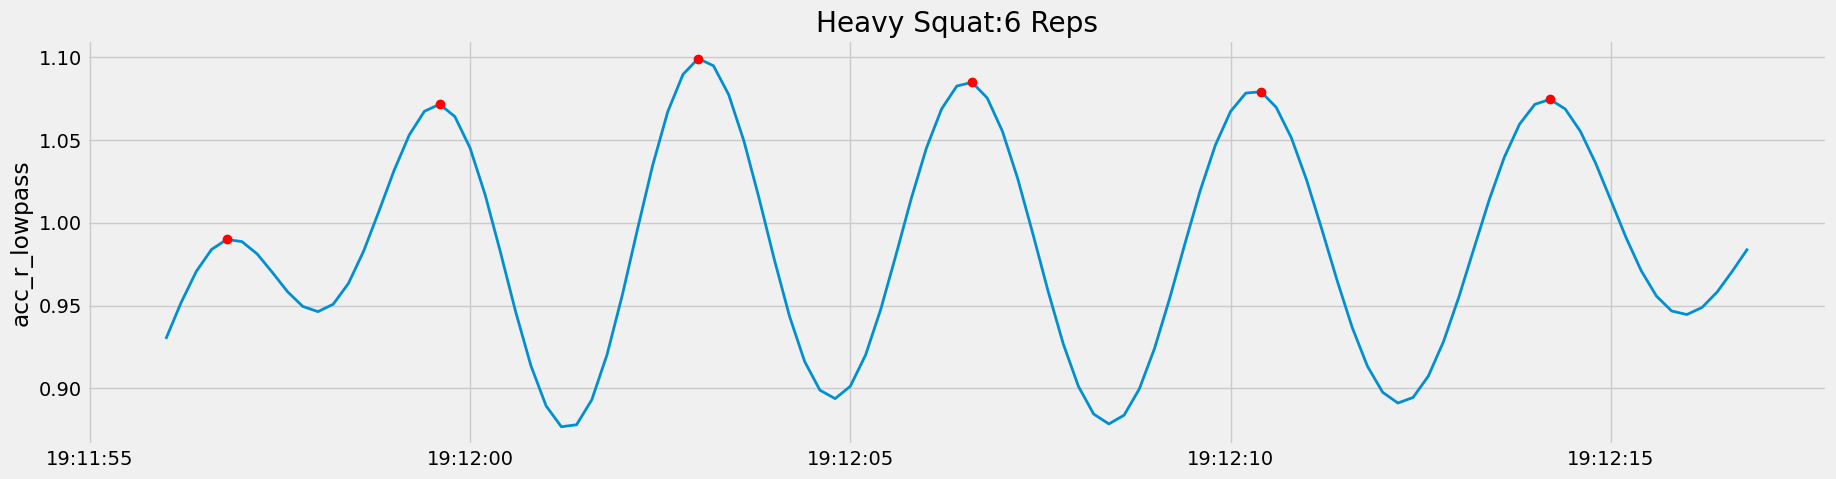

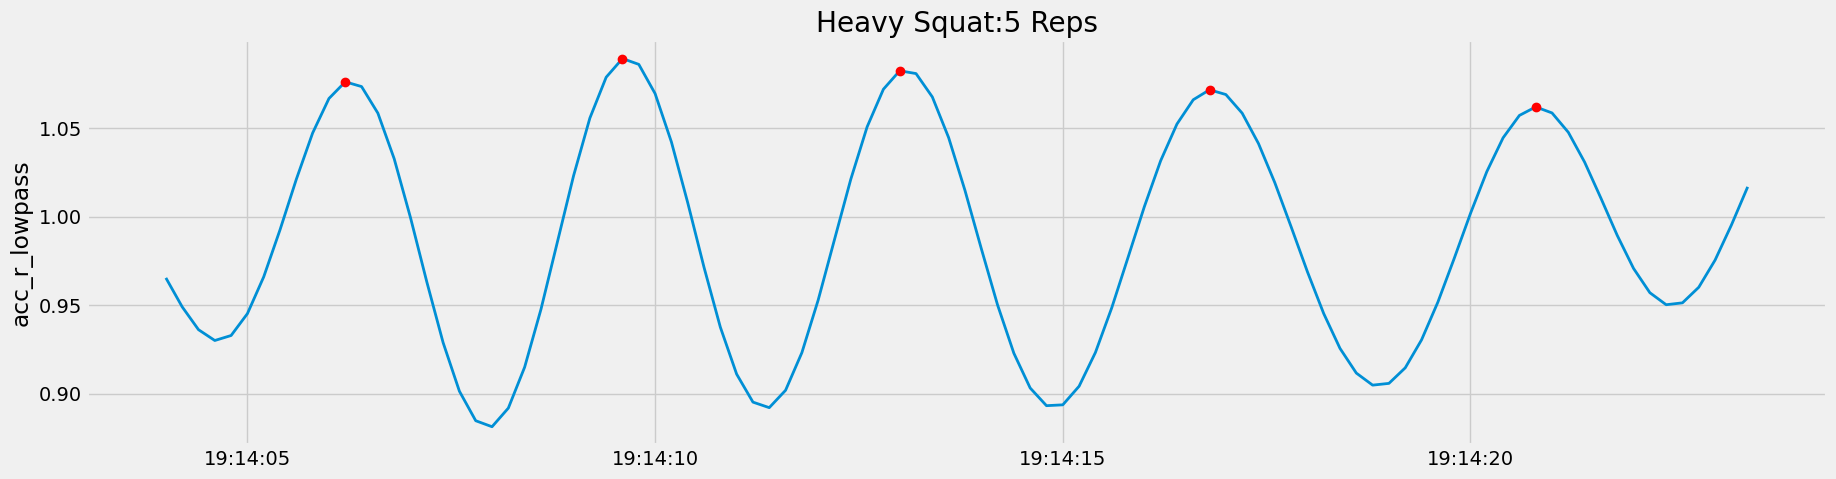

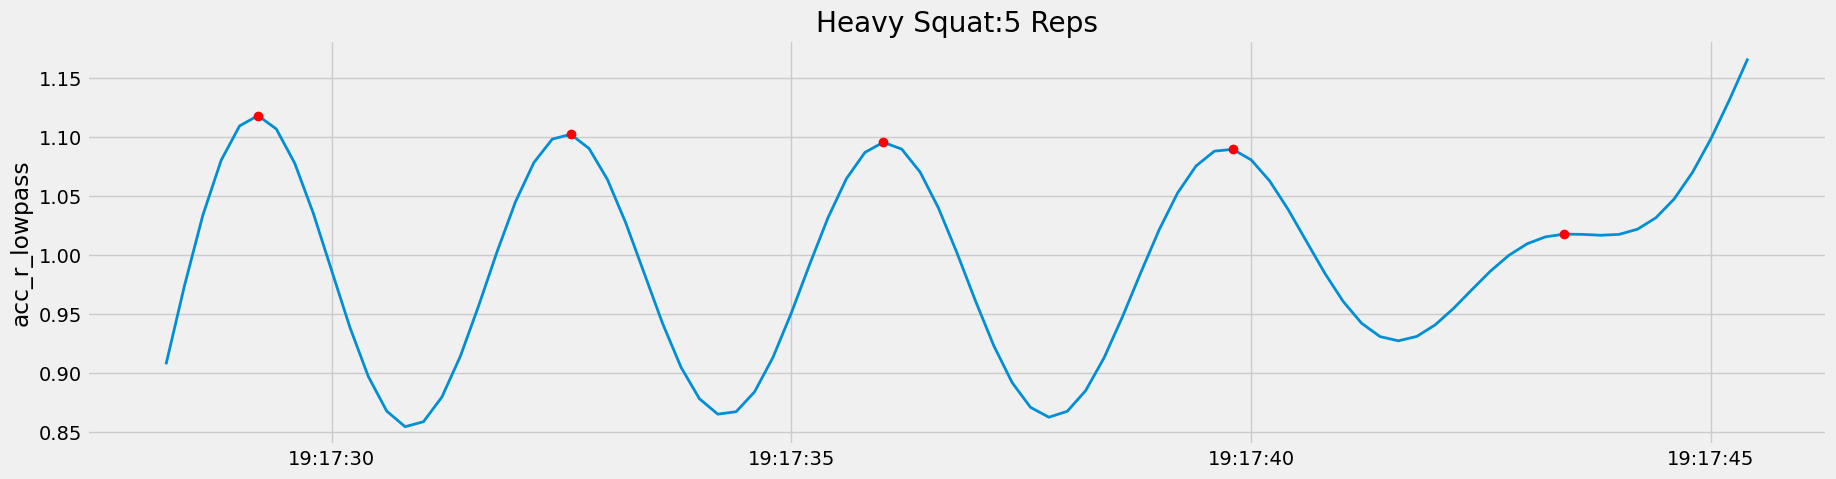

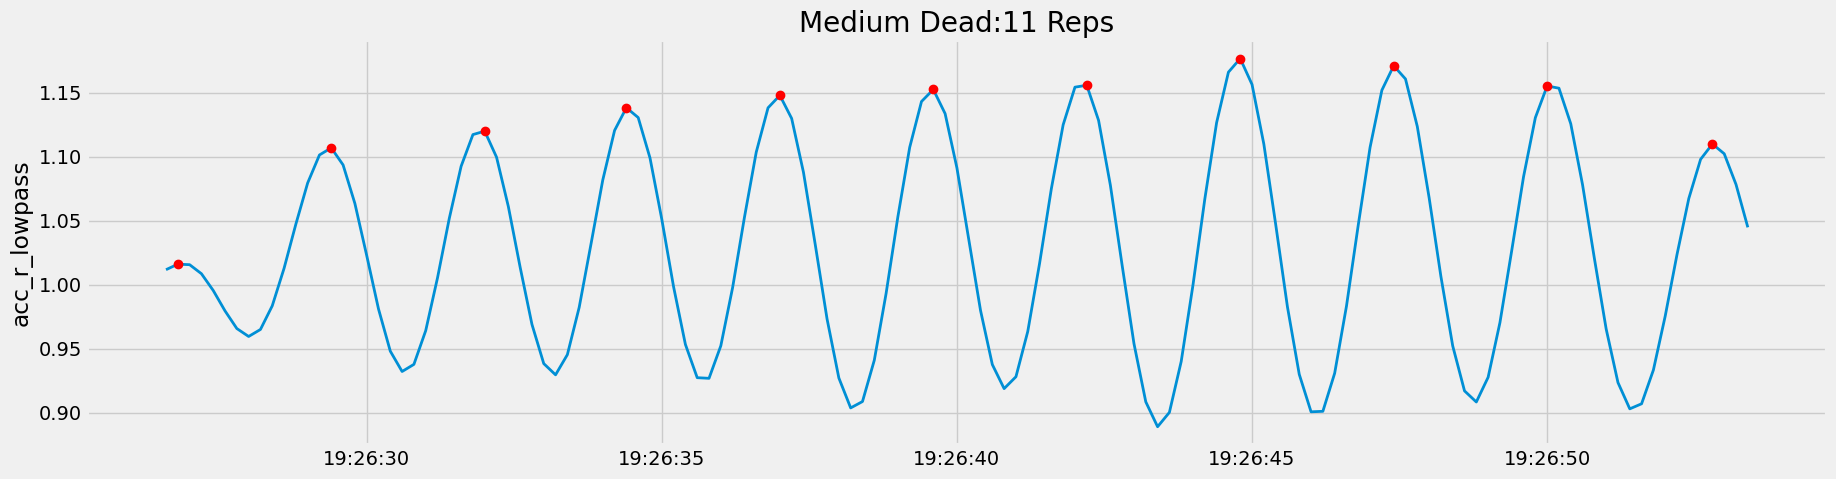

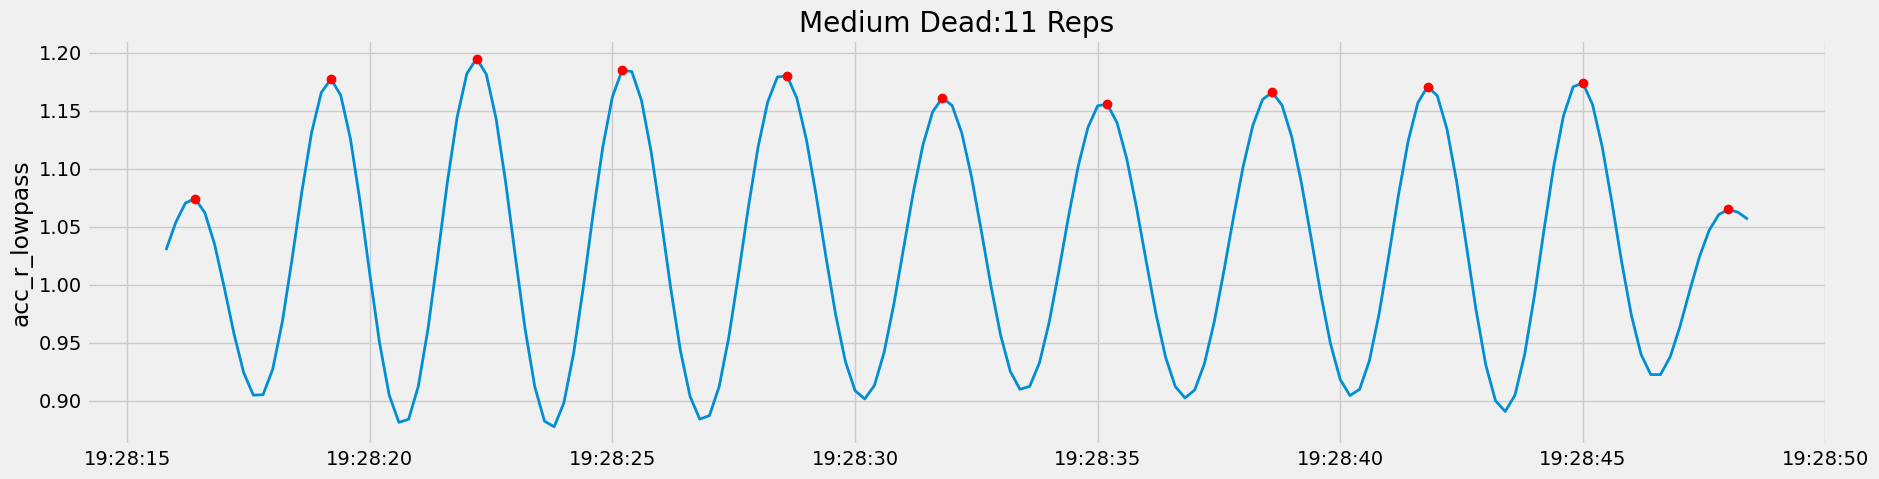

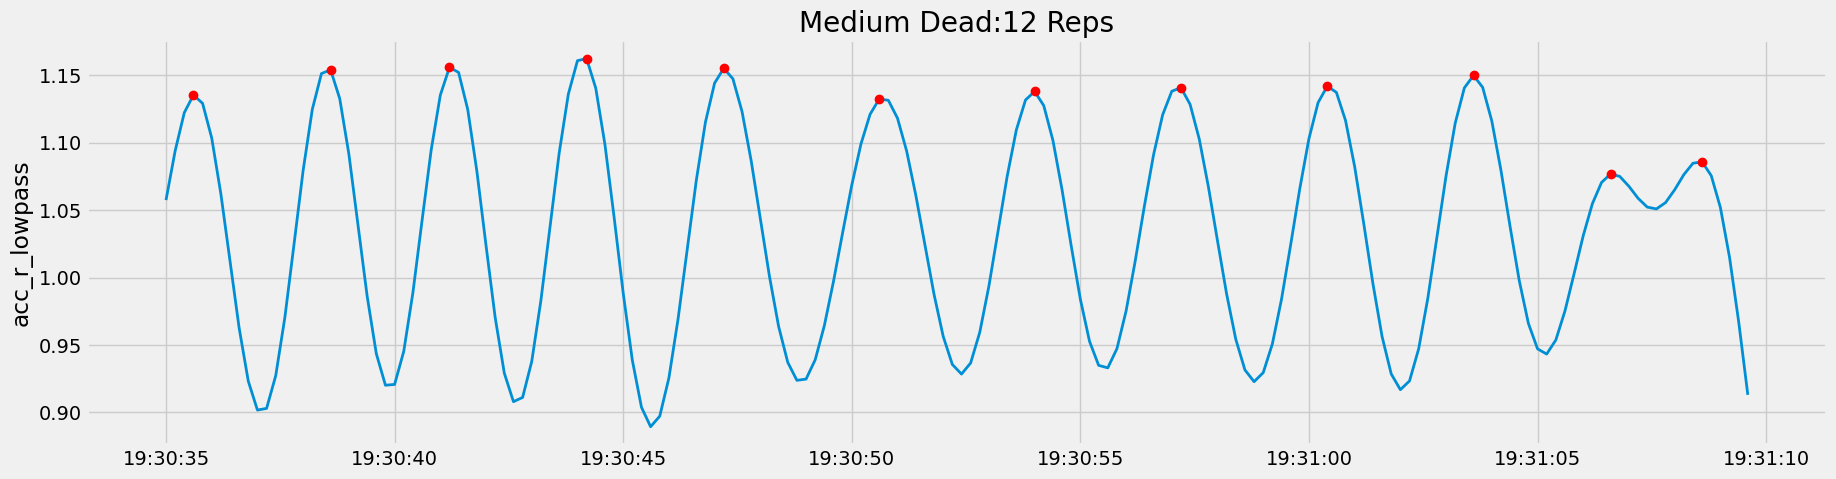

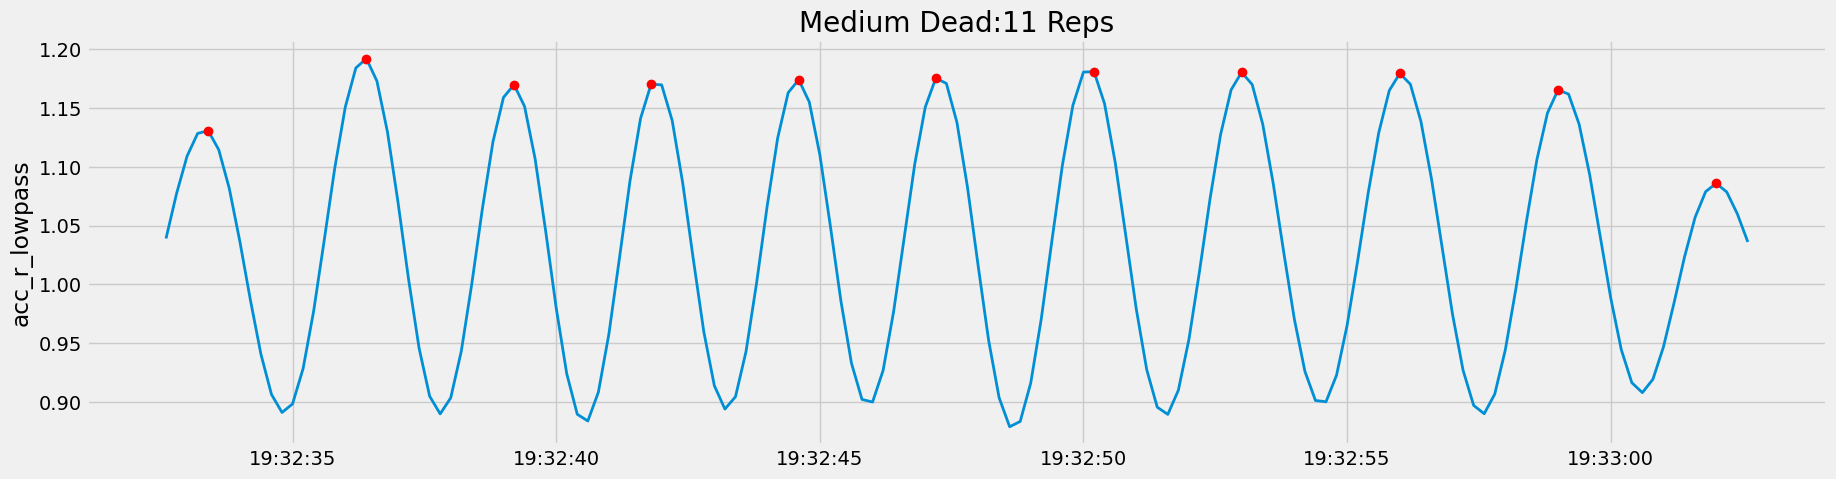

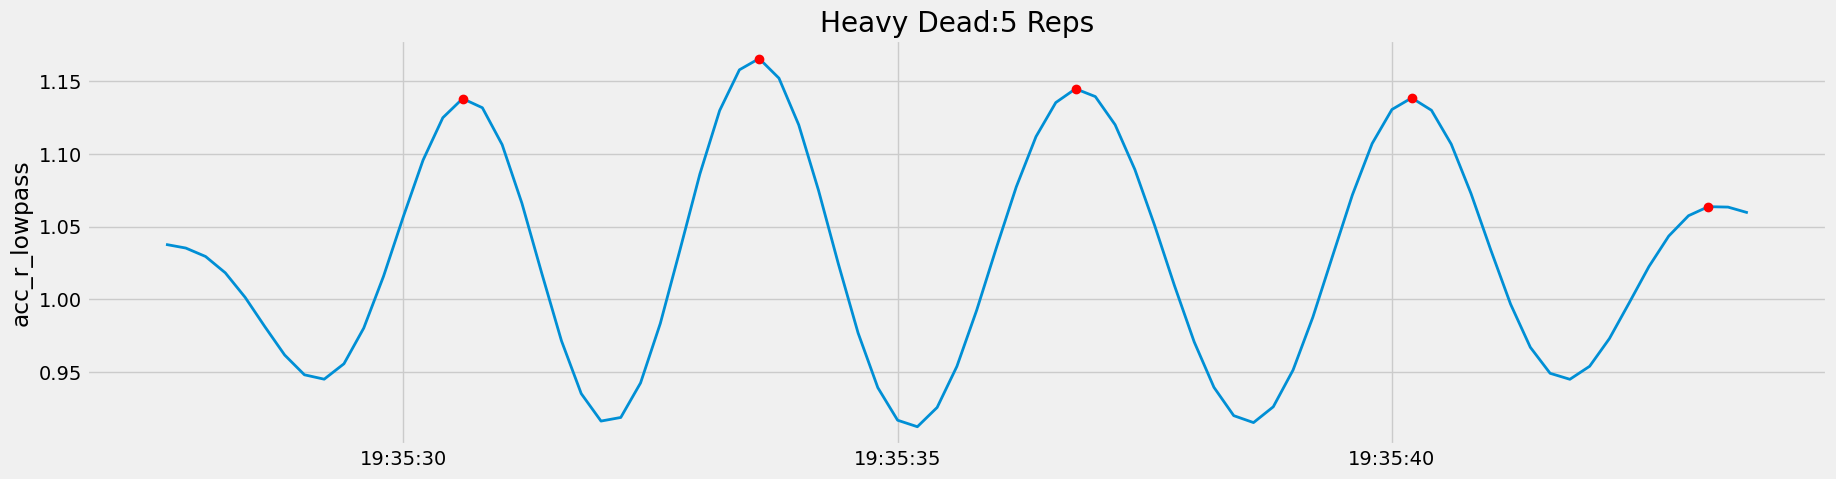

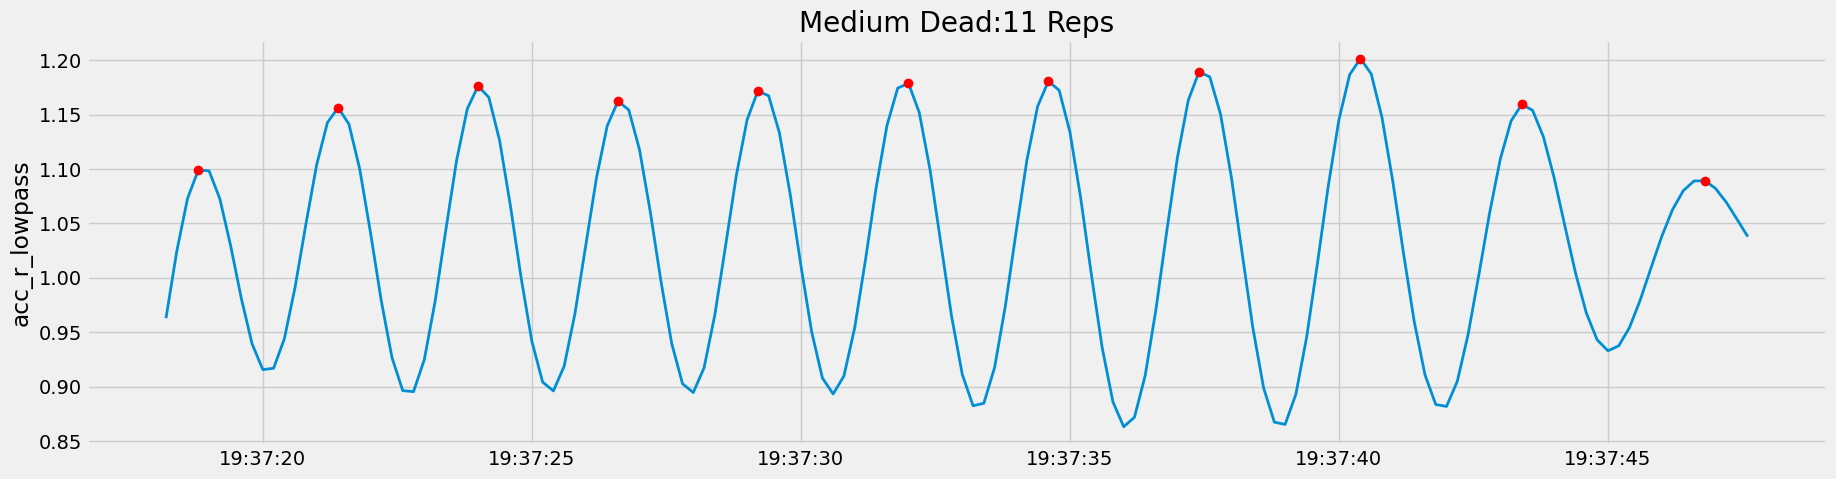

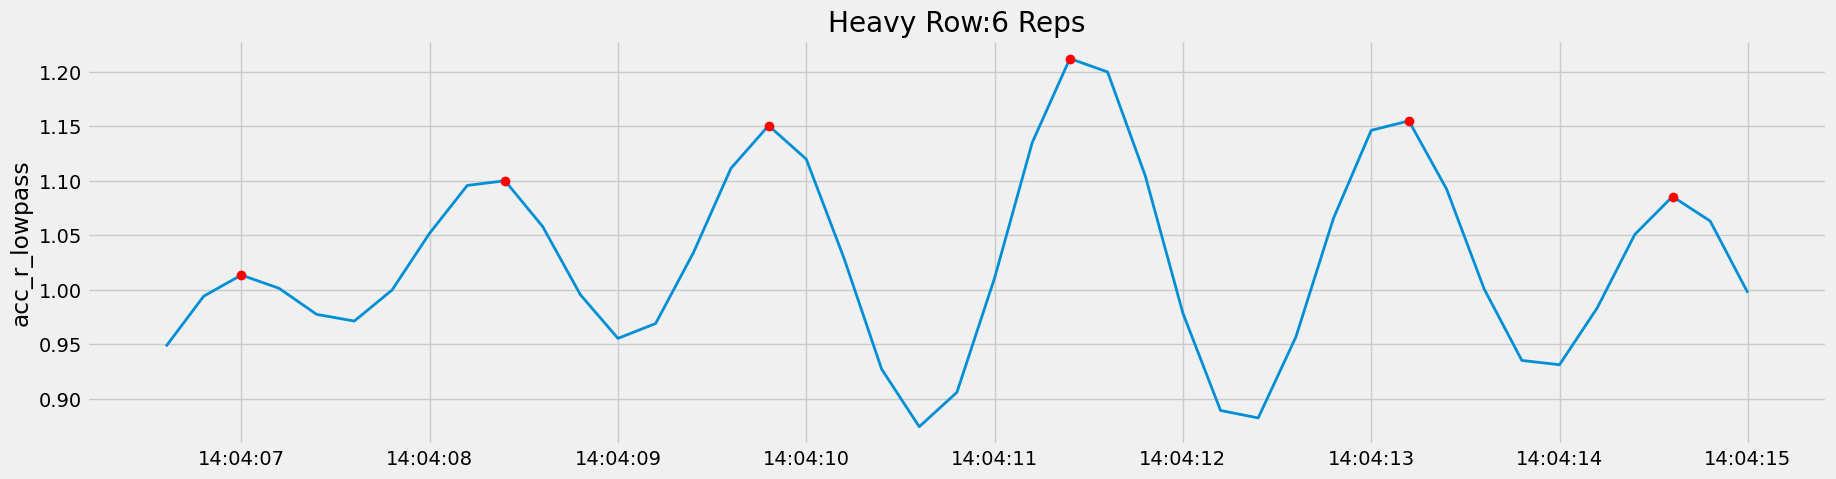

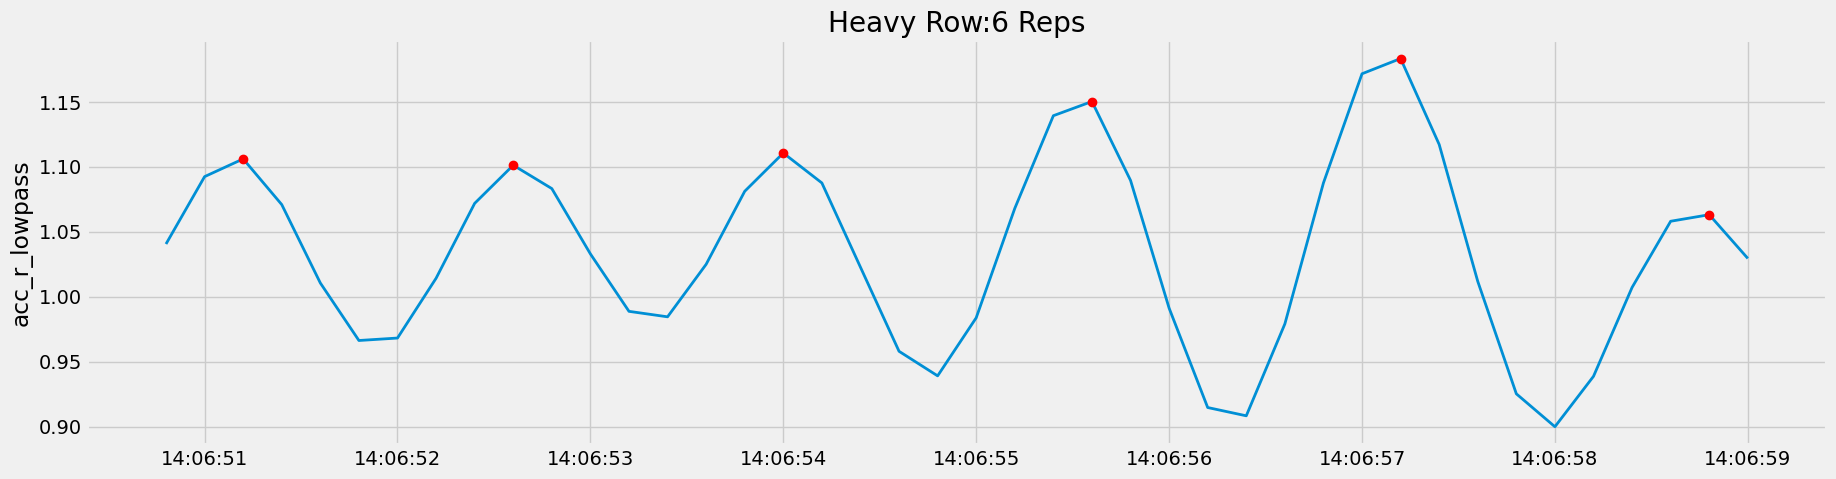

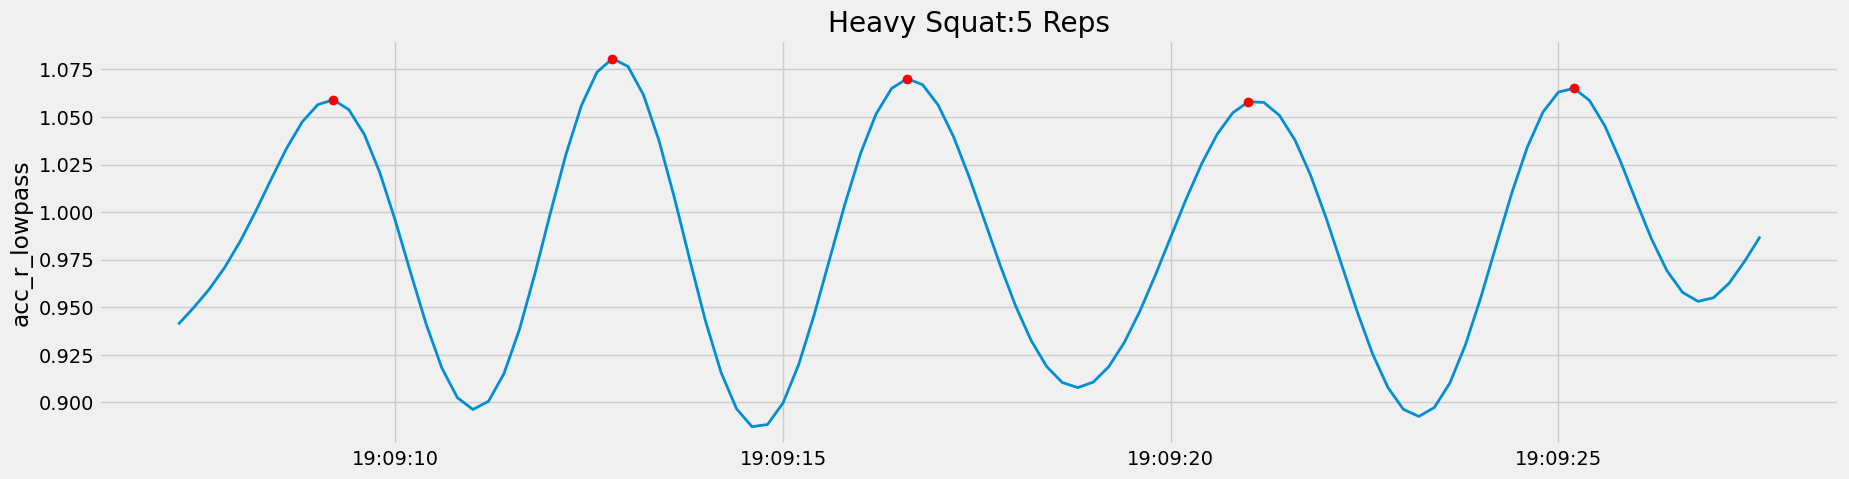

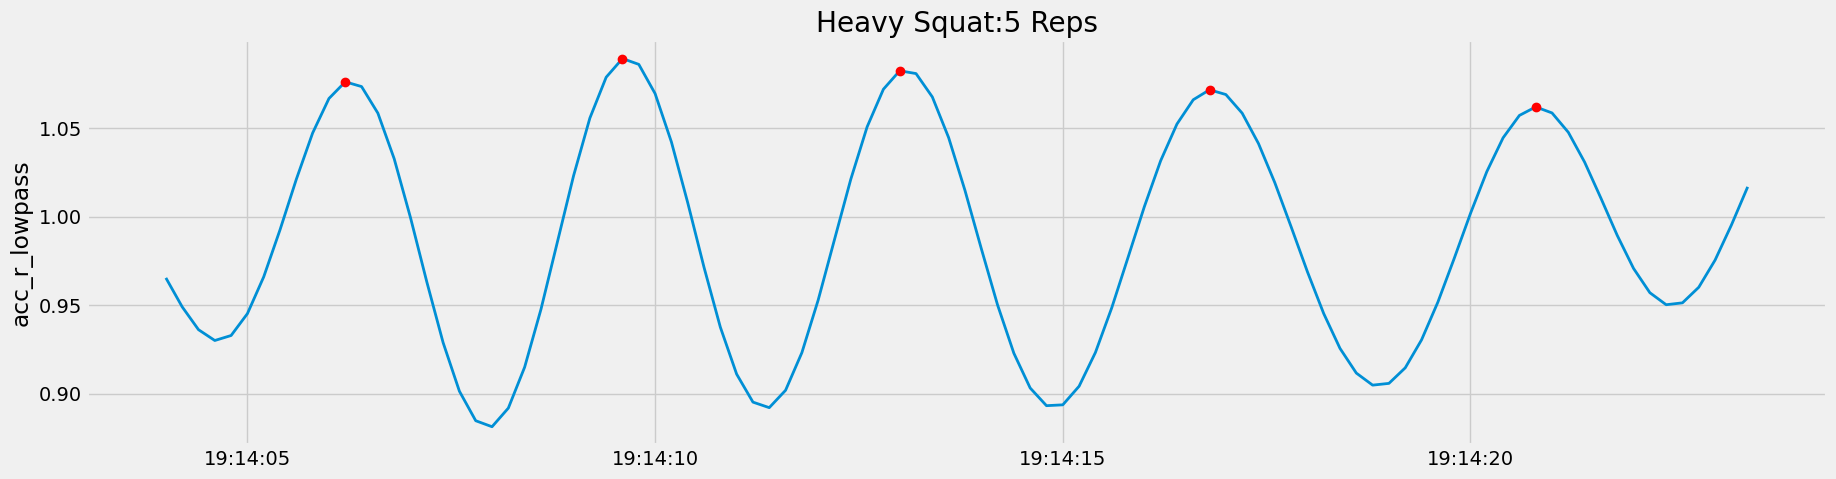

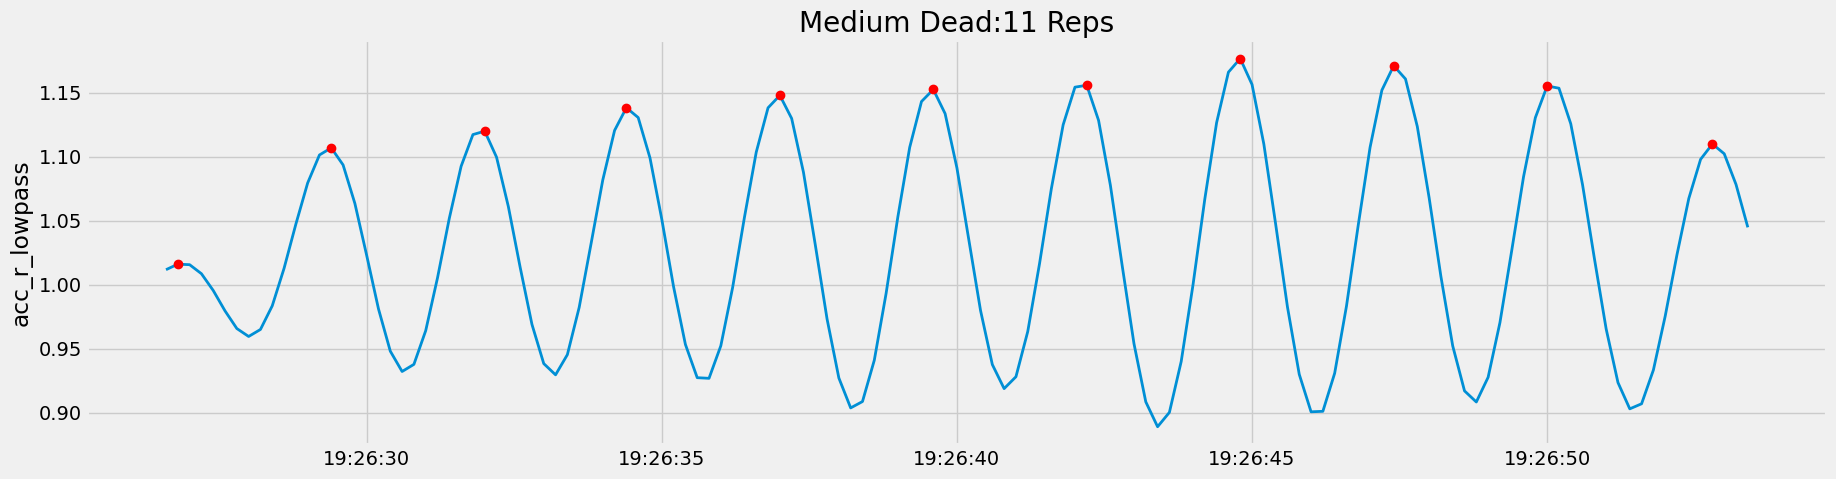

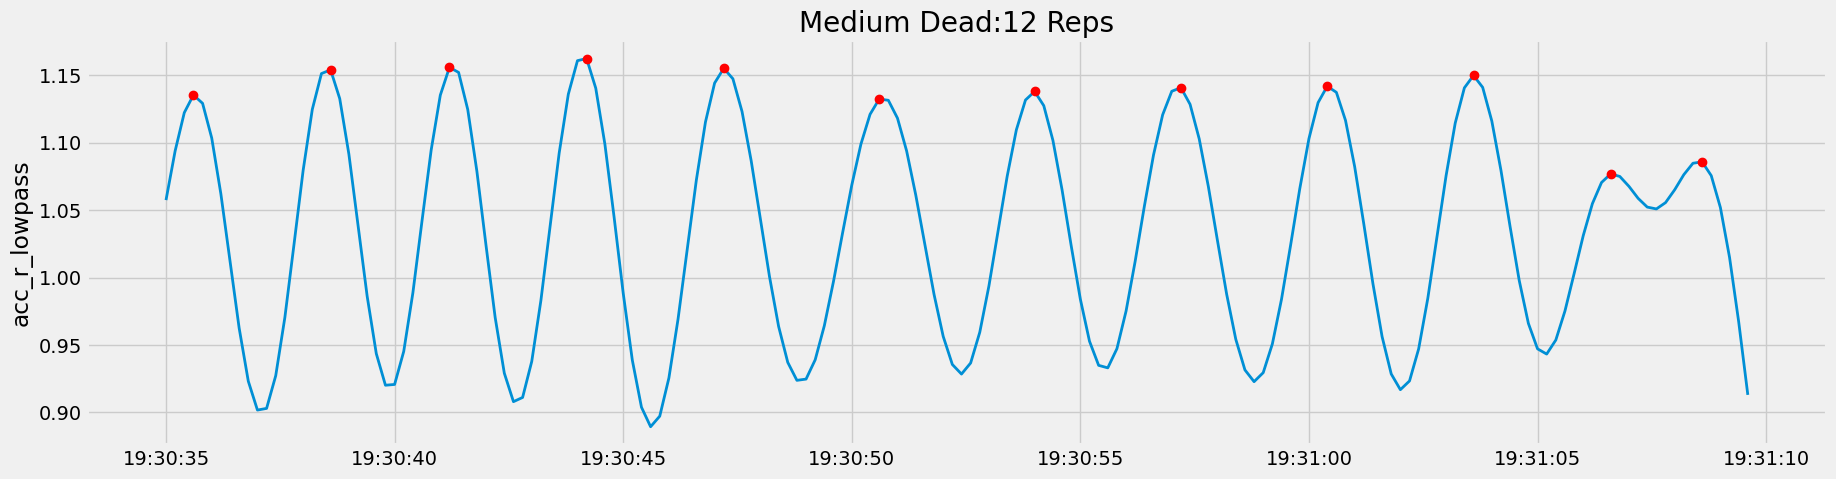

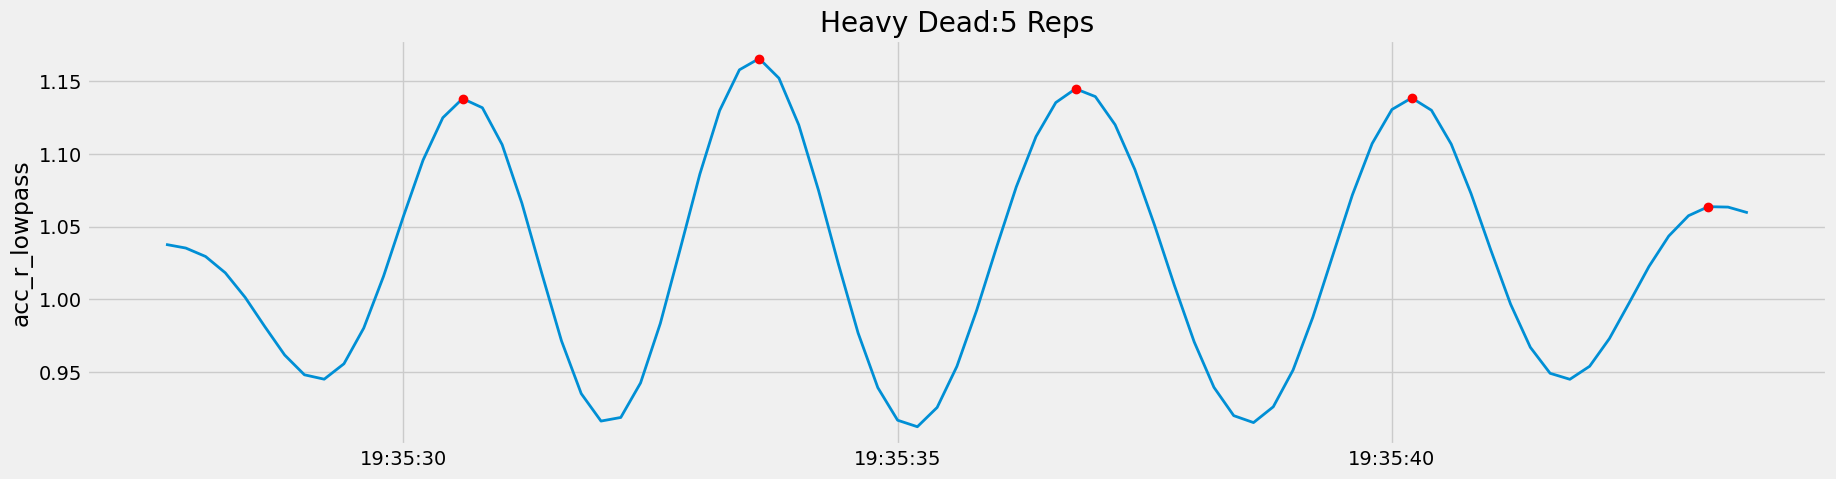

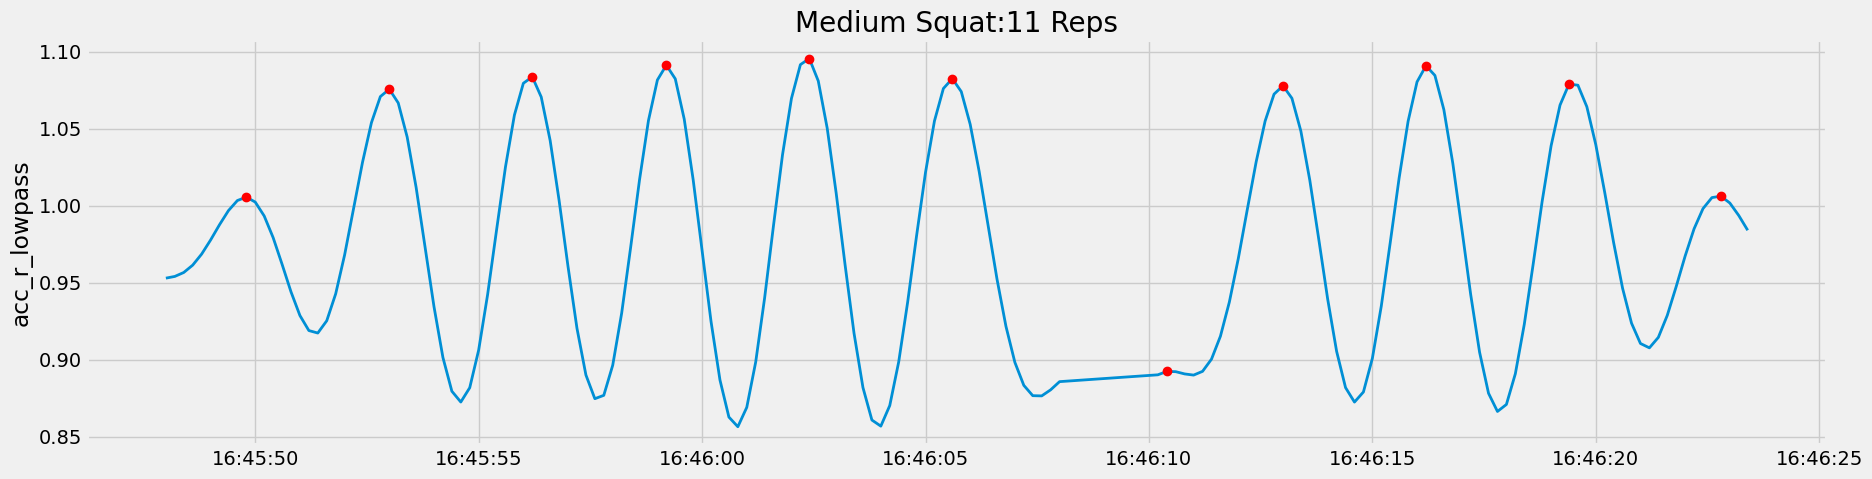

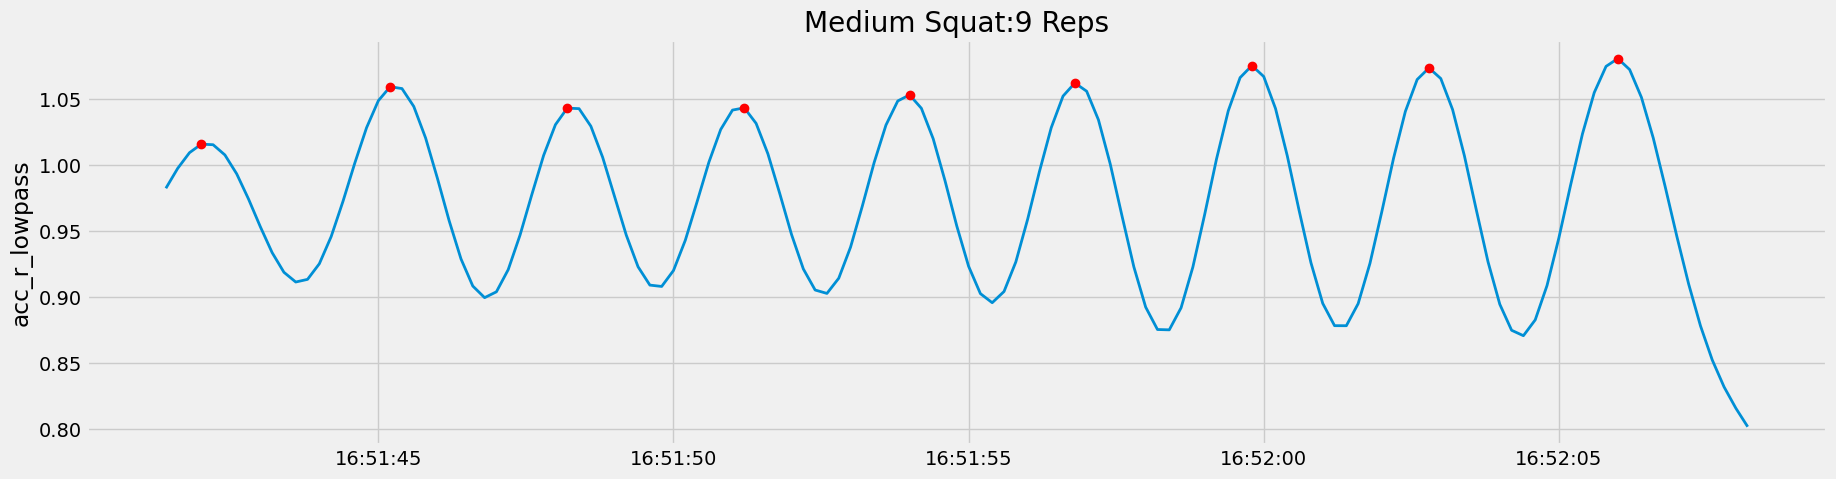

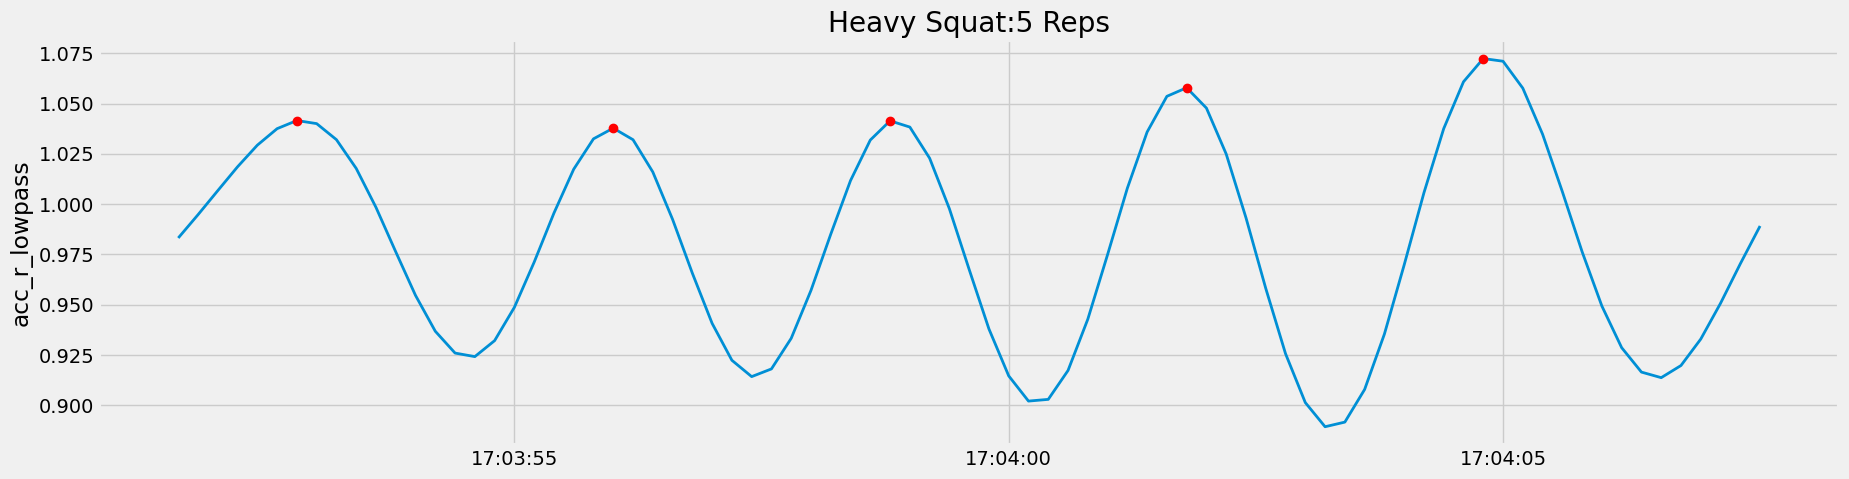

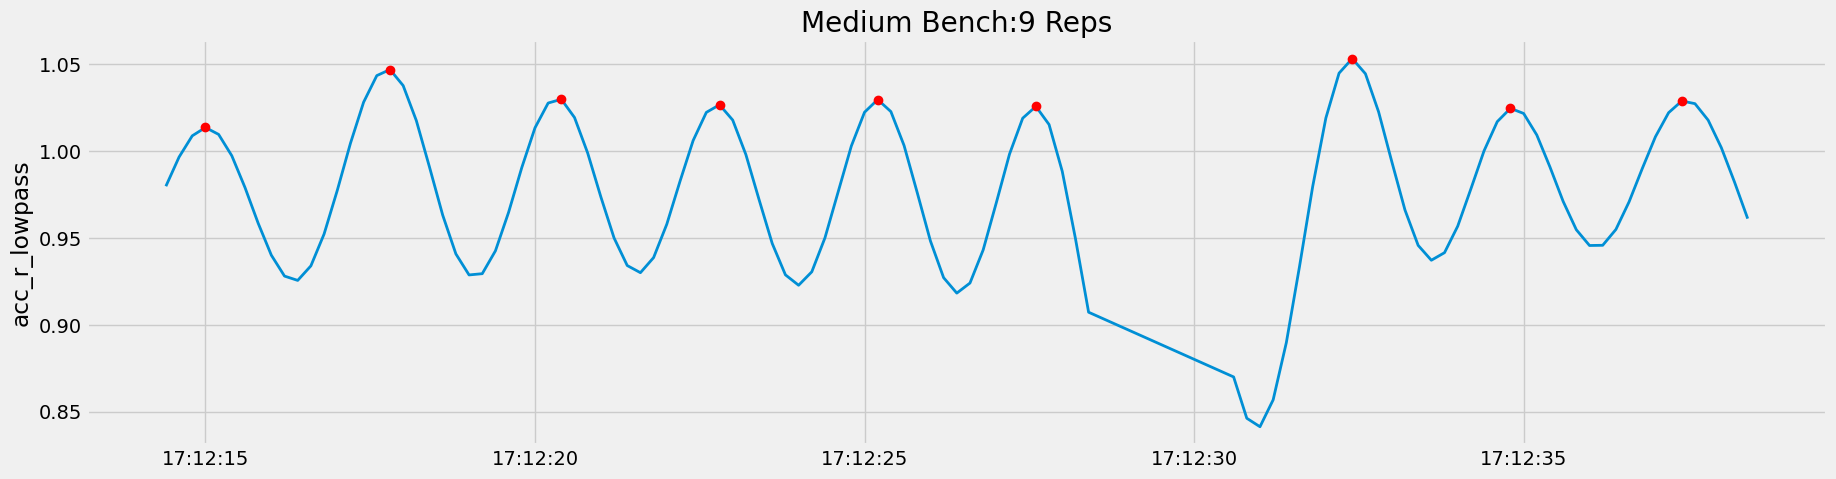

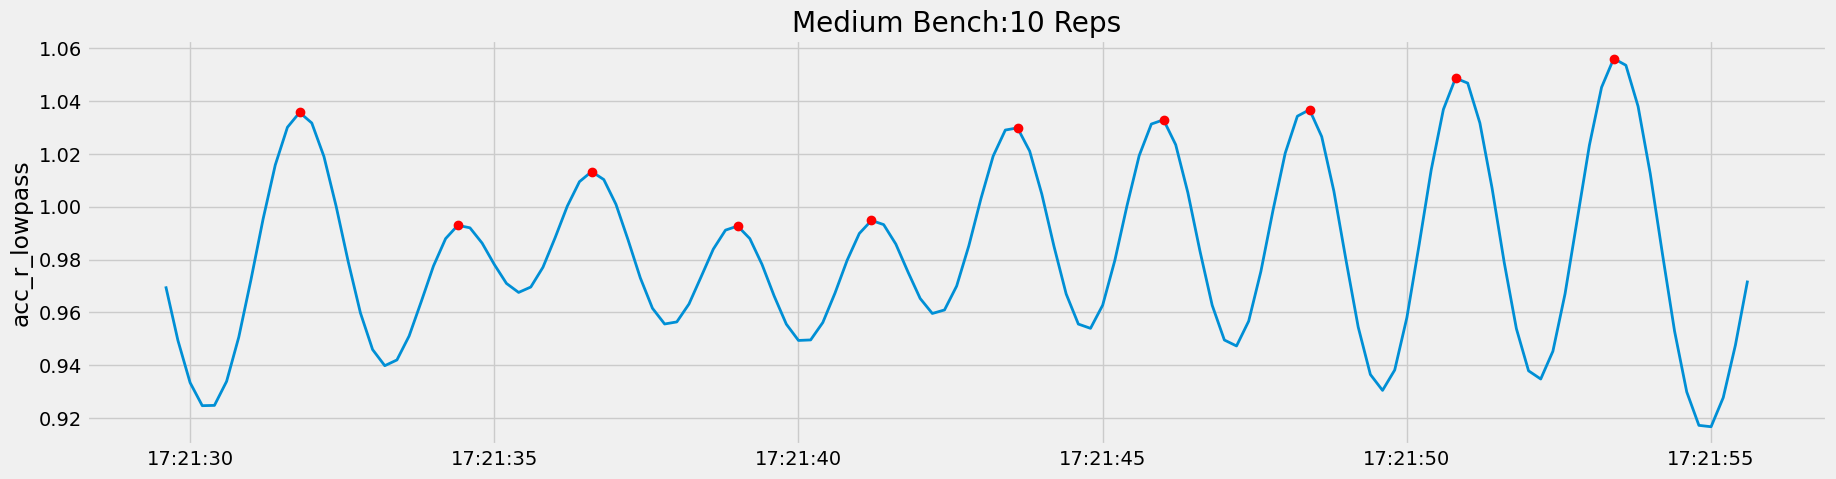

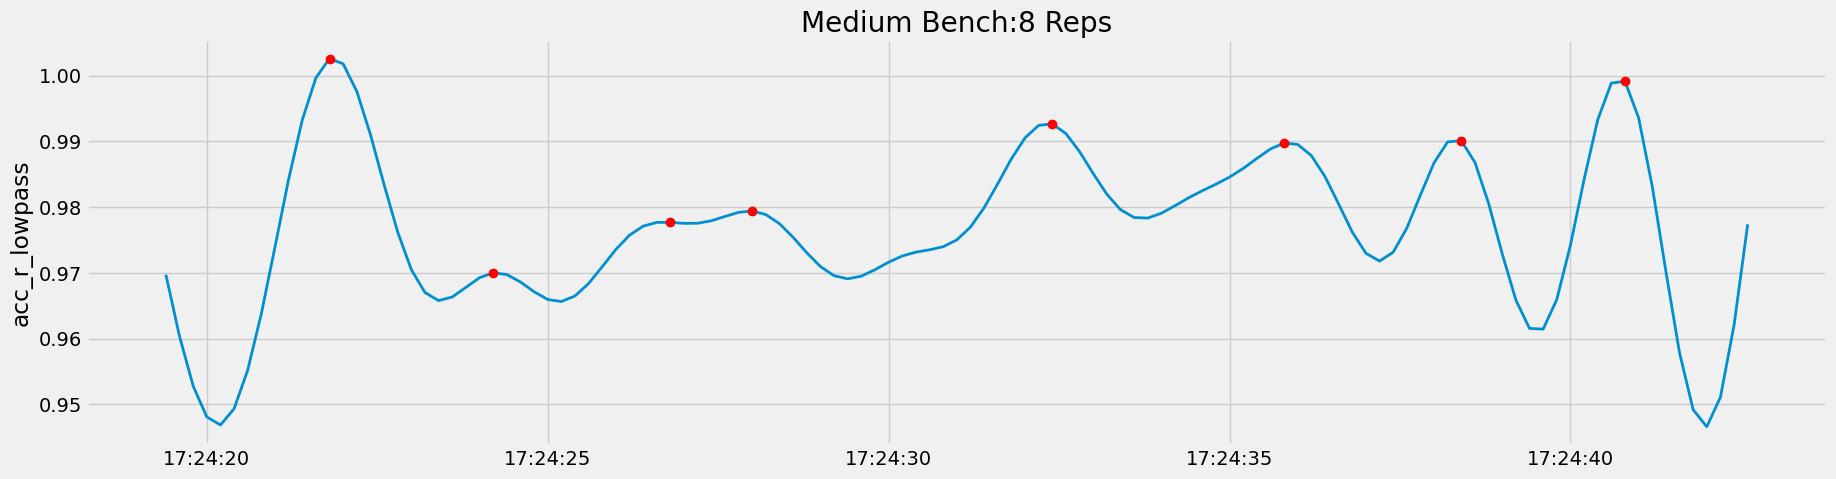

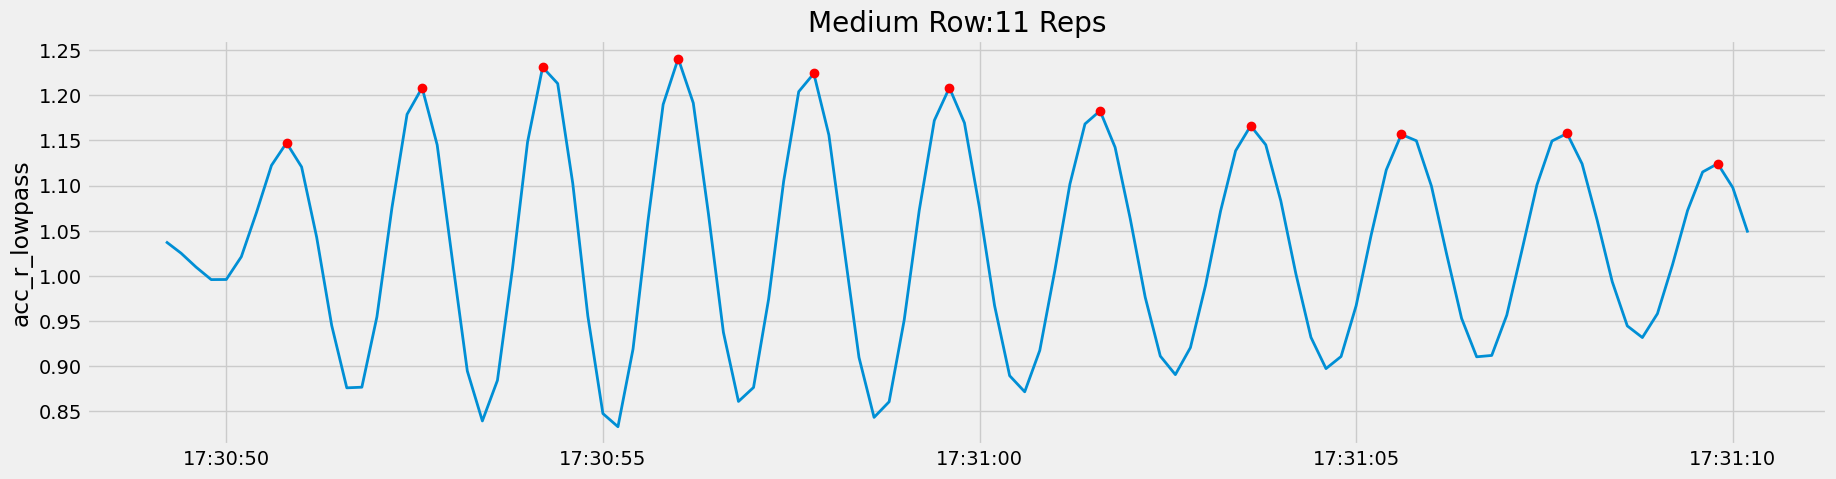

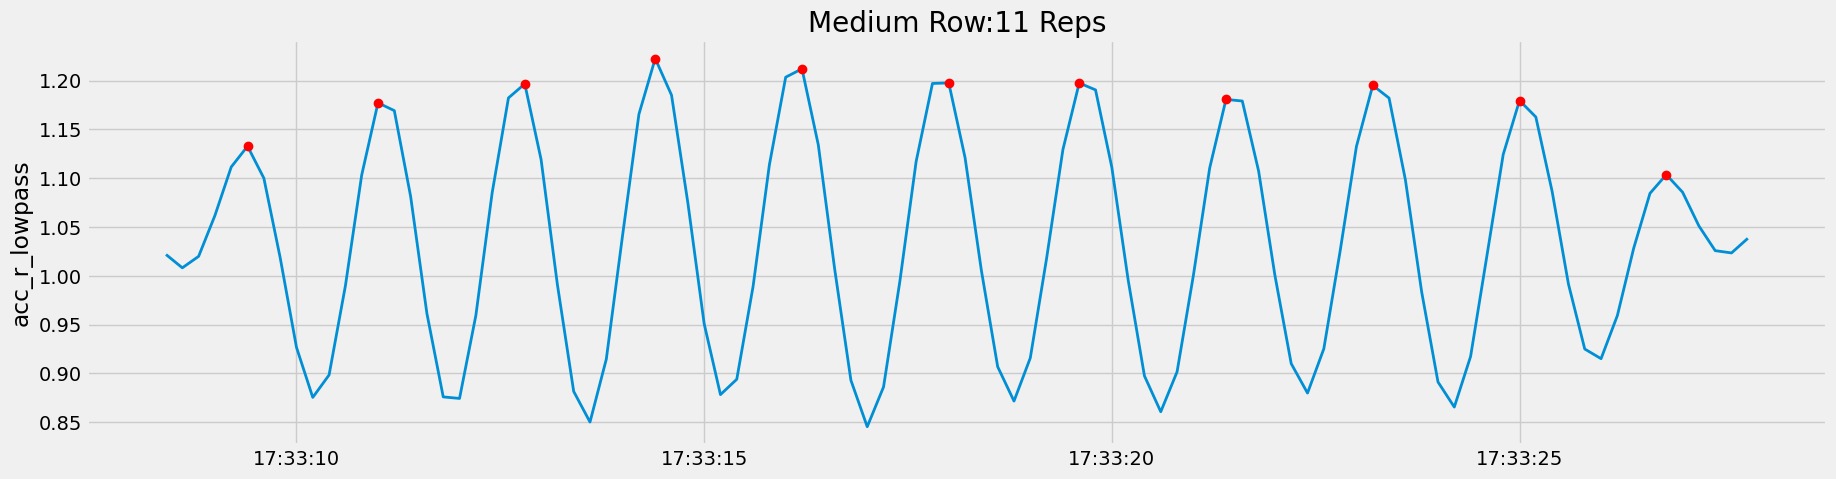

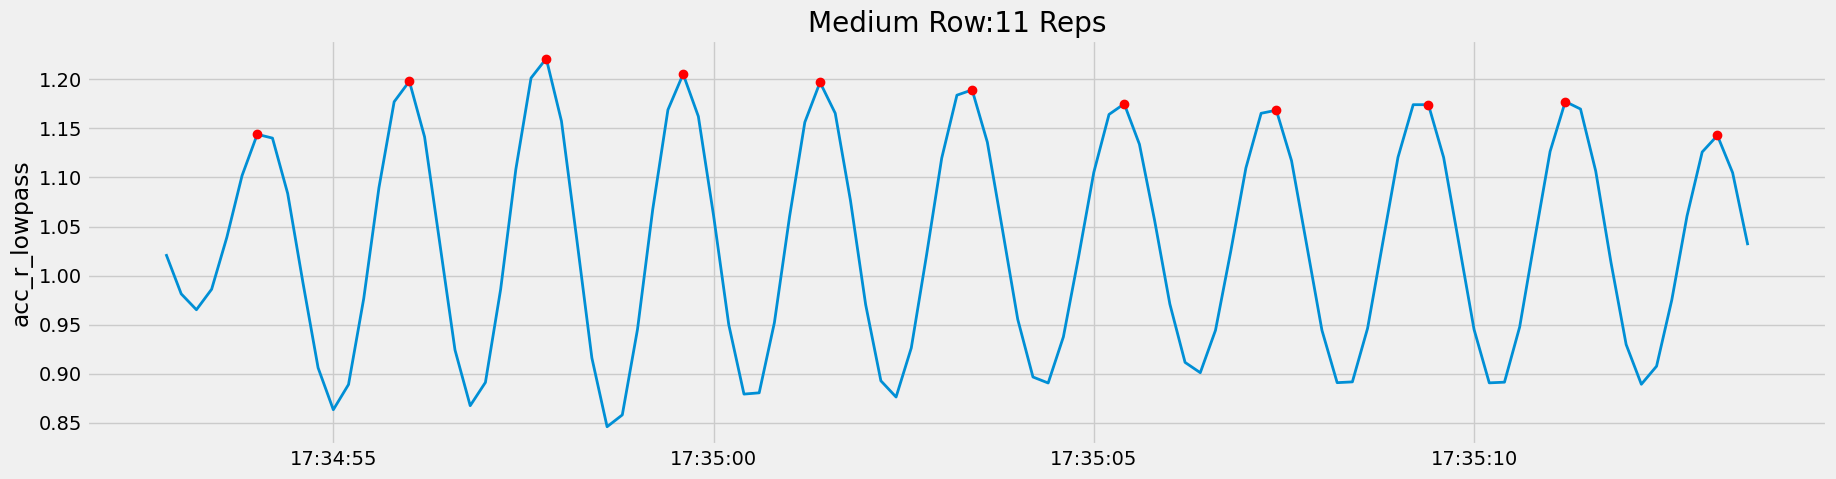

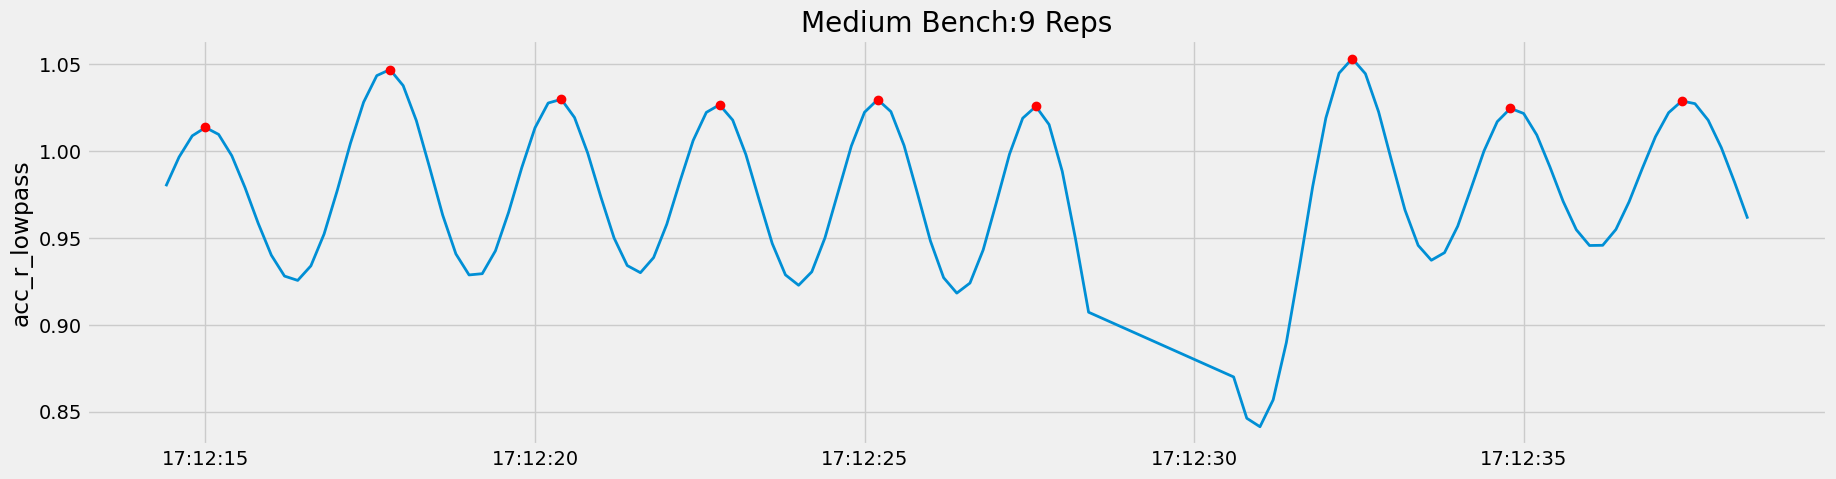

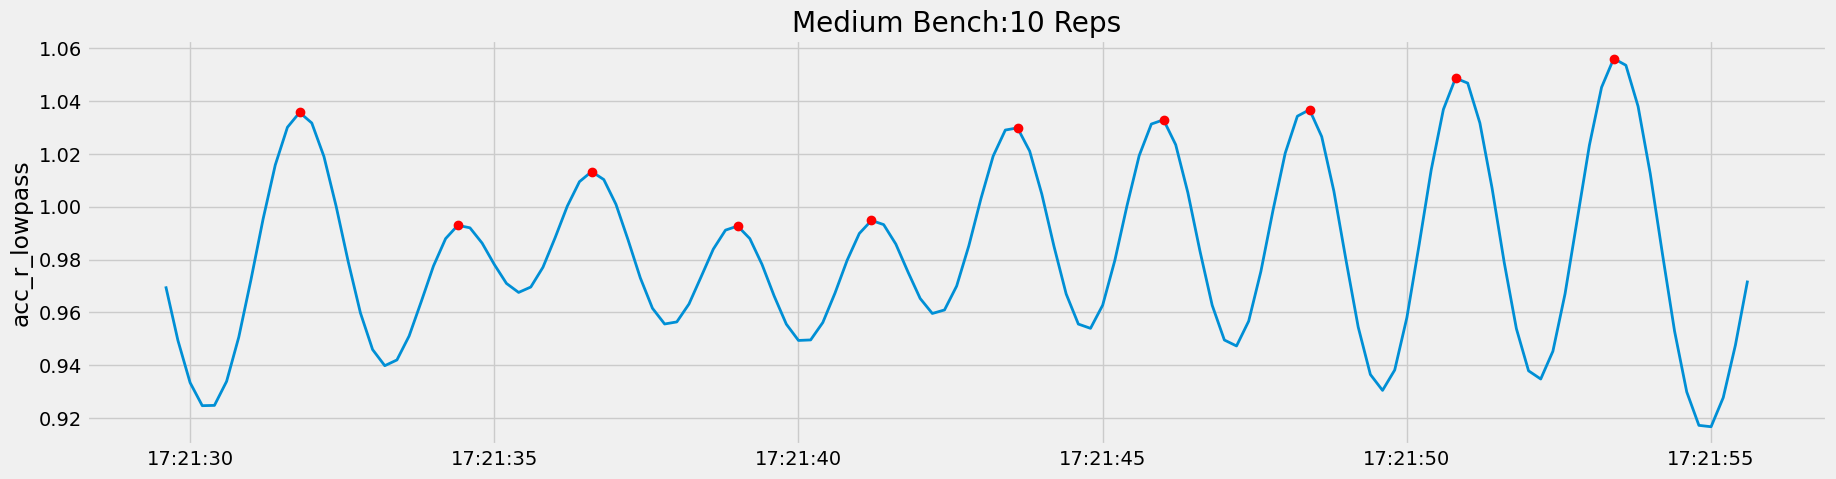

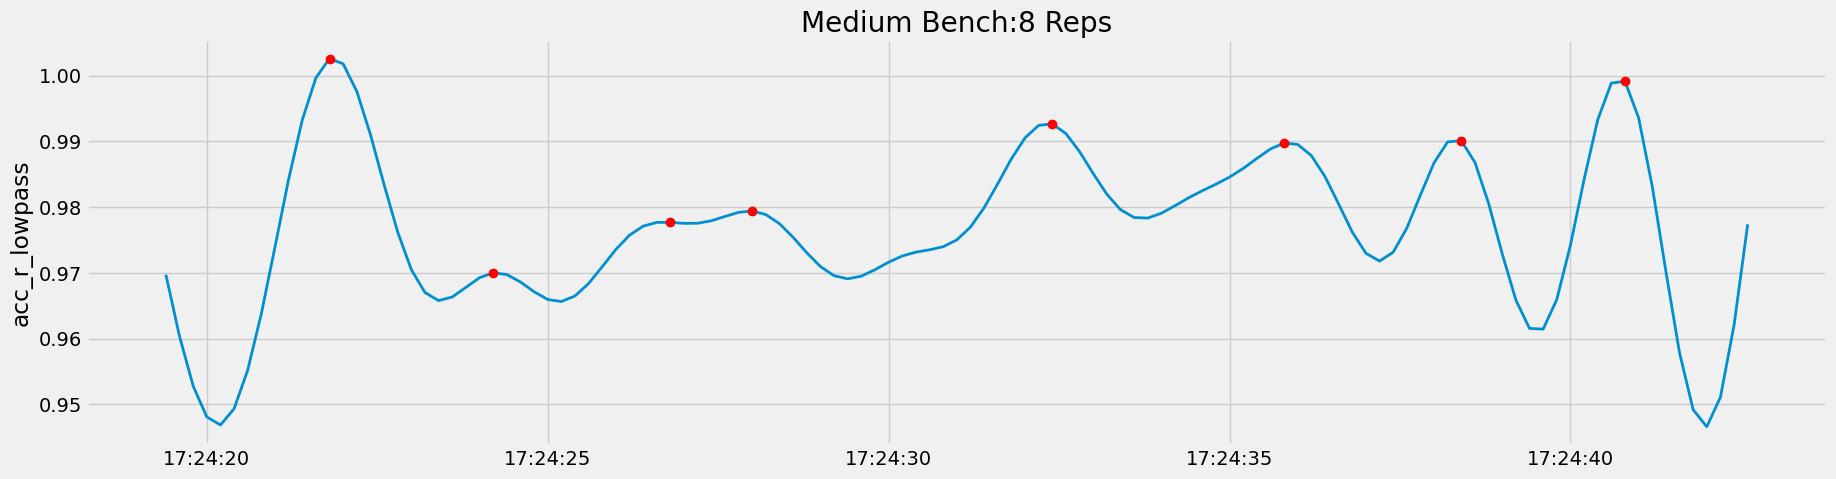

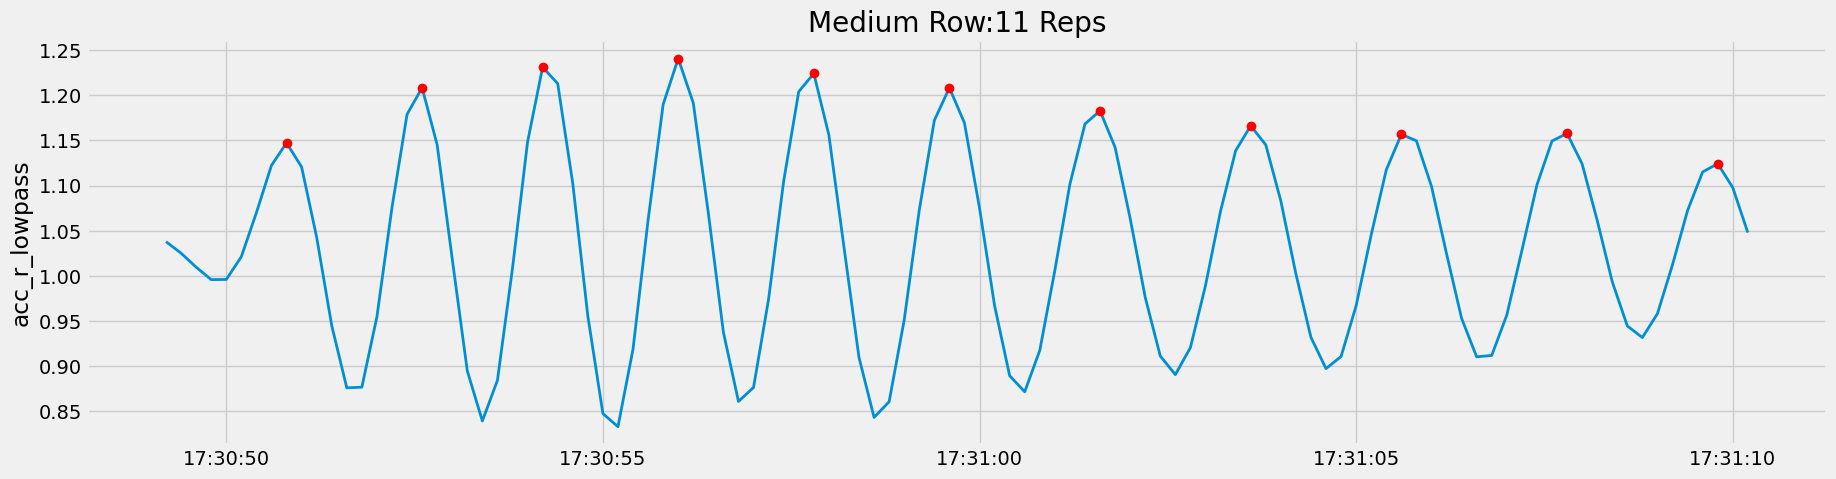

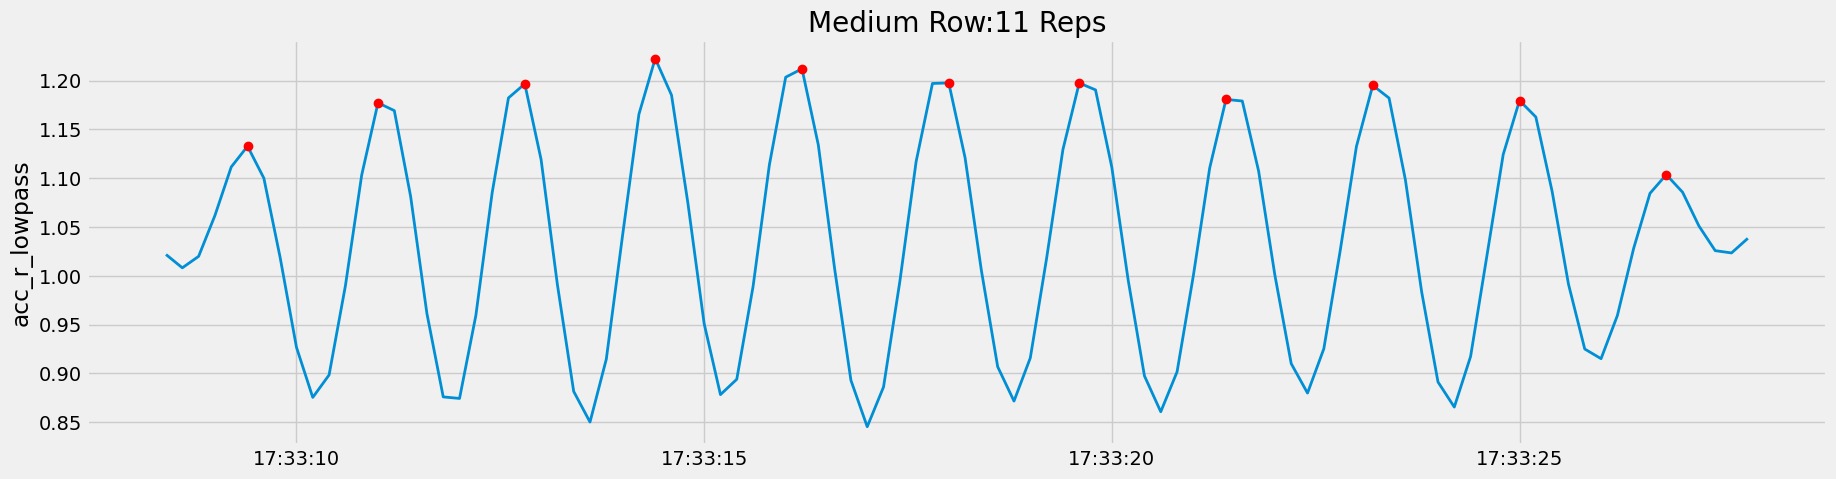

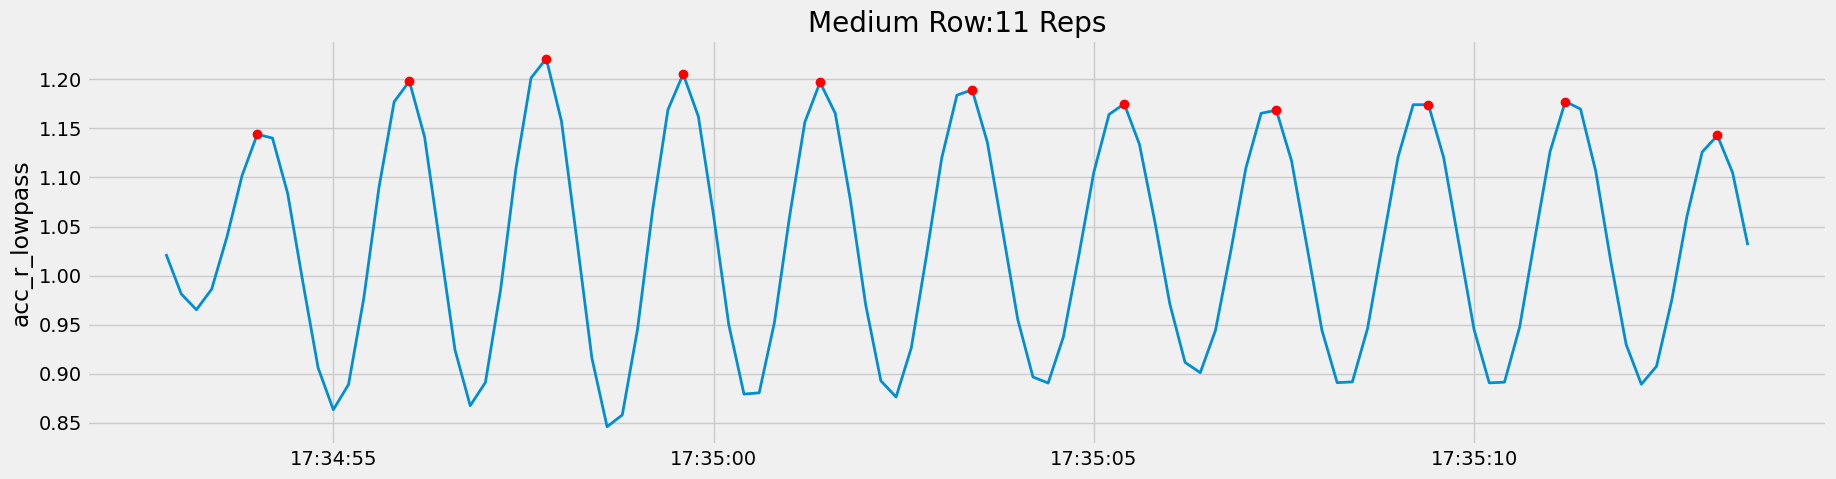

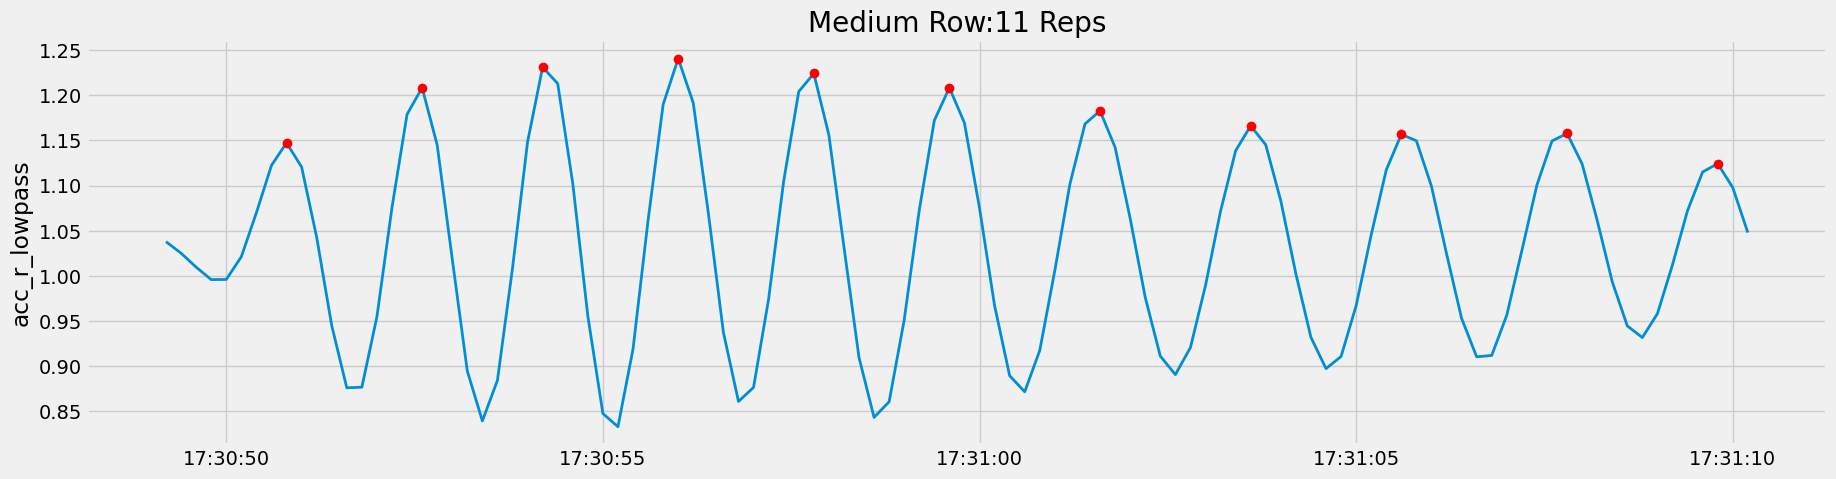

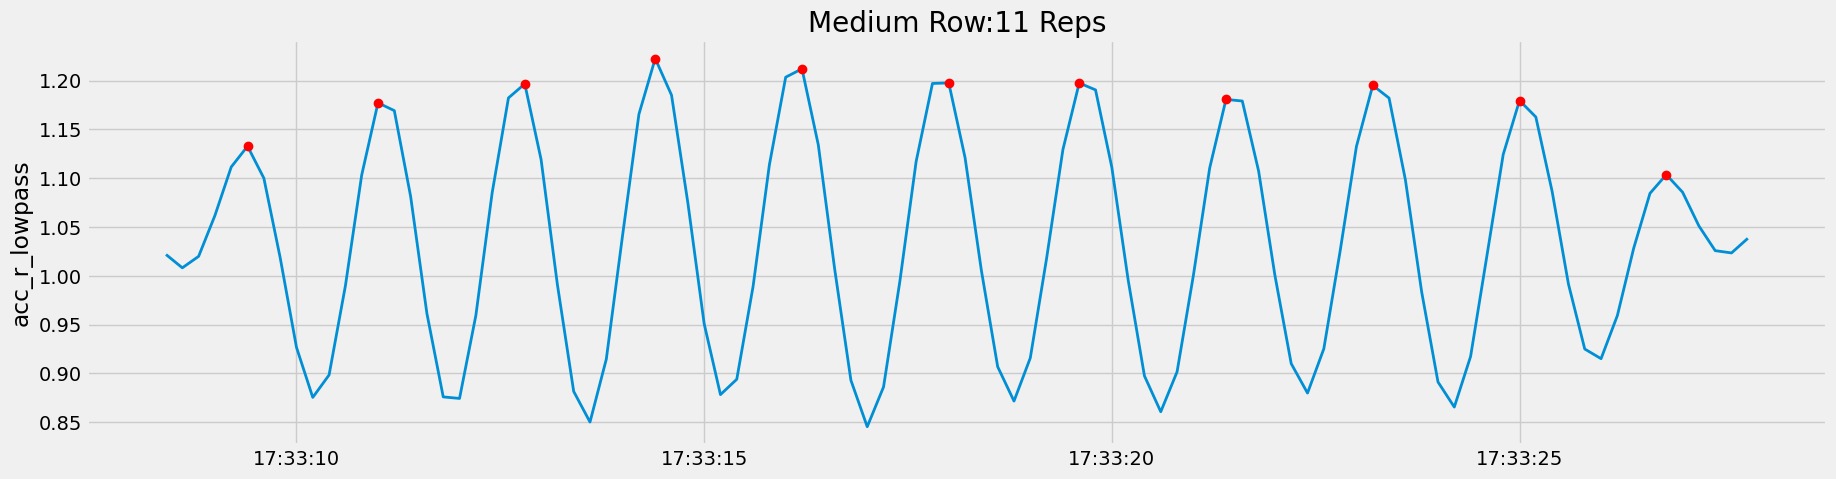

label category  set  reps  reps_pred
0   bench    heavy    1     5        5.0
1   bench    heavy    2     5        4.0
2   bench    heavy    3     5        5.0
3   bench    heavy    4     5        5.0
4   bench    heavy   30     5        5.0
..    ...      ...  ...   ...        ...
80  squat   medium   28    10        8.0
81  squat   medium   29    10        8.0
82  squat   medium   38    10        7.0
83  squat   medium   63    10       11.0
84  squat   medium   64    10        9.0

[85 rows x 5 columns]

In [23]:
for s in df['set'].unique():
    subset = df[df['set']==s]
    column = 'acc_r'
    cutoff = 0.4
    
    if subset['label'].iloc[0] == 'squat':
        cutoff = 0.35
    if subset['label'].iloc[0] == 'row':
        cutoff = 0.65
        col = 'gyr_x'
        
    if subset['label'].iloc[0] == 'ohp':
        cutoff = 0.35
    
    reps = count_repetitions(subset, cutoff=cutoff, column=column)
    rep_df.loc[rep_df['set']==s, 'reps_pred']=reps
rep_df

In [24]:
rep_df

label category  set  reps  reps_pred
0   bench    heavy    1     5        5.0
1   bench    heavy    2     5        4.0
2   bench    heavy    3     5        5.0
3   bench    heavy    4     5        5.0
4   bench    heavy   30     5        5.0
..    ...      ...  ...   ...        ...
80  squat   medium   28    10        8.0
81  squat   medium   29    10        8.0
82  squat   medium   38    10        7.0
83  squat   medium   63    10       11.0
84  squat   medium   64    10        9.0

[85 rows x 5 columns]

In [25]:
error = mean_absolute_error(rep_df['reps'],rep_df['reps_pred']).round(2)

<ipython-input-27-eb562d8c9b30>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  rep_df.groupby(['label','category'])['reps','reps_pred'].mean().plot.bar()


<AxesSubplot: xlabel='label,category'>

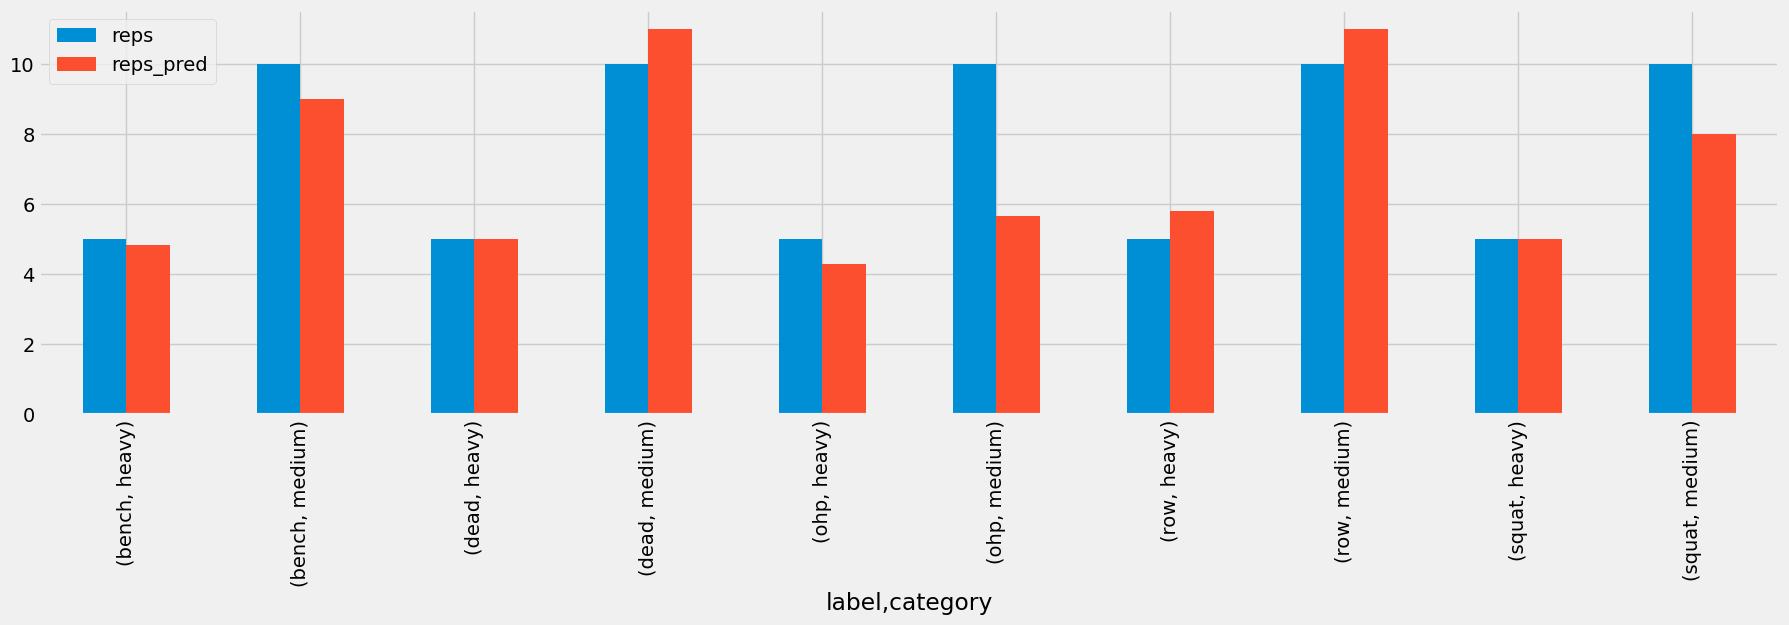

In [27]:
rep_df.groupby(['label','category'])['reps','reps_pred'].mean().plot.bar()

In [28]:
error

1.02